In [16]:
import os
import glob
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import re
import time
import bisect
from numba import jit
import cv2
import skimage 
import pandas as pd
from skimage import exposure
import glob
from skimage.restoration import rolling_ball

In [6]:
#Function to rescale images
def rescale_to_bits(im: np.ndarray, n_bits: int) -> np.ndarray:
    """
    Helper method to rescale an image to have values supported with a specific bit-depth (unsigned integer).
    """
    max_value = 2**n_bits - 1
    im = im - im.min()
    im = im * (max_value / im.max())
    im = np.round(im)
    return im

In [7]:
def colorize(im, color, clip_percentile=0.1):
    """
    Helper function to create an RGB image from a single-channel image using a 
    specific color.
    """
    # Check that we do just have a 2D image
    if im.ndim > 2 and im.shape[2] != 1:
        raise ValueError('This function expects a single-channel image!')
        
    # Rescale the image according to how we want to display it
    im_scaled = im.astype(np.float32) - np.percentile(im, clip_percentile)
    im_scaled = im_scaled / np.percentile(im_scaled, 100 - clip_percentile)
    im_scaled = np.clip(im_scaled, 0, 1)
    
    # Need to make sure we have a channels dimension for the multiplication to work
    im_scaled = np.atleast_3d(im_scaled)
    
    # Reshape the color (here, we assume channels last)
    color = np.asarray(color).reshape((1, 1, -1))
    return im_scaled * color


In [8]:
def gray2color(I,channel):
    """
    Compute color image from intensity in fluorescence in a given channel.
    Arguments:
    -----------
        I: np.ndarray
            Input fluorescence image (2D).
        channel: int
            Channel to code the image in (0: Red, 1: Green, 2: Blue).
    Returns:
    ----------- 
        I_color: np.ndarray
            The computed output image in color.
    """
    
    I_color = np.dstack((
        skimage.exposure.rescale_intensity(I if channel==0 else np.zeros_like(I)),
        skimage.exposure.rescale_intensity(I if channel==1 else np.zeros_like(I)),
        skimage.exposure.rescale_intensity(I if channel==2 else np.zeros_like(I)),
        ))
    return I_color

In [9]:
def subtract_background(image, radius=25, light_bg=False):
    # import libraries
    from skimage.morphology import white_tophat, black_tophat, disk 
    
    # generate structuring element
    str_el = disk(radius)
     
    # use appropriate filter depending on the background colour
    if light_bg:
        return black_tophat(image, str_el)
    else:
        return white_tophat(image, str_el)

In [ ]:
import os
import numpy as np
from PIL import Image

# Define the folder containing the images
folder_path = "D:/Easin_Microscopy_Images/IncellAnalyzer/Easin/20230309_ZF3/Easin_20x_ZF3/Easin_20x_ZF3_1"

# Define the well and site numbers
well_numbers = ["A-01", "A-02", ..., "H-12"]
site_numbers = ["fld 1", "fld 2", ..., "fld N"]

# Define the channels and their corresponding file name keywords
channels = ["Blue - FITC", "Red - Cy5", "UV - DAPI"]
channel_keywords = ["wv Blue - FITC", "wv Red - Cy5", "wv UV - DAPI"]

# Loop through all the wells and sites
for well in well_numbers:
    for site in site_numbers:
        try:
            # Loop through all the channels
            channels_data = []
            for i, channel in enumerate(channels):
                # Define the file name of the image for this channel, well, and site
                file_name = "{}({} {} {})".format(well, site, channel_keywords[i], channel)
                file_path = os.path.join(folder_path, file_name)

                # Load the image for this channel, well, and site
                image = np.asarray(Image.open(file_path))
                channels_data.append(image)

            # Merge the images for all channels into a single color image
            color_image = np.dstack(channels_data)

            # Save the color image with the same file name as the first channel's image
            save_file_name = "{}({} color)".format(well, site)
            save_file_path = os.path.join(folder_path, save_file_name)
            Image.fromarray(color_image).save(save_file_path)

        except FileNotFoundError:
            # Skip this well or site if the image file is not found
            continue

In [9]:
import os
import re
import os.path 
t1 = time.perf_counter()

# Define the folder containing the images
pathIn = r"D:/Easin_Microscopy_Images/IncellAnalyzer/Easin/Easin_ZF3_20230317_2"
pathOut = r"D:/Easin_processed_images"+ '/'+os.path.basename(pathIn)


isExist = os.path.exists(pathOut) # Check whether the specified path exists or not
if not isExist:
    os.makedirs(pathOut)
    print("The new directory is created!")    

def prepend(list, str):
    str += '{0}'
    list = [str.format(i) for i in list]
    return(list)

# Define the well and site numbers
well_numbers_list = []
site_number_list = []

# Loop through all the files in the folder
for file_name in os.listdir(pathIn):
    # Check if the file name matches the expected pattern
    if "(" in file_name and ")" in file_name:
        # Extract the well and site numbers from the file name
        well, site = file_name.split("(")[:2]
        well_numbers_list.append(well.strip())
        well_names_unique = sorted(set(well_numbers_list))
        site_number_list.append(re.search('\d+', site).group())
        min_site_number = int(min(site_number_list))
        max_site_number = int(max(site_number_list))
        
# Remove duplicates (set) and sort(sorted) the well and site numbers
well_numbers = sorted(list(set(well_numbers_list)))
site_numbers = sorted(set(prepend(site_number_list, 'fld ')))

image_type = '.tif'

# Define the channels and their corresponding file name keywords
channels = ["green", "red", "blue"]
channel_keywords = ["wv Blue - FITC", "wv Red - Cy5", "wv UV - DAPI"]

# Loop through all the wells and sites
for well in well_numbers:
    for site in site_numbers:
        im = []
        for i, channel in enumerate(channels):
            # Define the file name of the image for this channel, well, and site
            file_name = "{}({} {}){}".format(well, site, channel_keywords[i], image_type)
            file_path = pathIn +'/'+ file_name
               
            try:
                im = plt.imread(file_path)
                assert im.dtype == np.uint16
            except FileNotFoundError:
                print(f"Skipping well {well}, site {site} for channel {channel}")
                continue
                
            im = rescale_to_bits(im, 8)
            #check which channel it is and colorize accordingly
            save_file_name = "{} ({}, {}).tiff".format(well, site, channel_keywords[i])
            save_file_name_path = pathOut + '/' + save_file_name
            if channel == 'green':
                im_g = colorize(im[...,], (0, 1, 0),clip_percentile=0.01)
                plt.imsave(save_file_name_path, im_g,format='TIFF')
            elif channel == 'red':
                im_r = colorize(im[...,], (1, 0, 0),clip_percentile=0.01)
                plt.imsave(save_file_name_path, im_r,format='TIFF')
            else :
                im_b = colorize(im[...,], (0, 0, 1),clip_percentile=0.01)
                plt.imsave(save_file_name_path, im_b,format='TIFF')

        save_file_name_rg = "{} ({}) rg.tiff".format(well, site)
        save_file_name_path_rg = pathOut + '/' + save_file_name_rg
        merge1 = np.clip(im_r + im_g , 0, 1)
        plt.imsave(save_file_name_path_rg, merge1,format='TIFF') #Saving the 2 colors merged file
        
        save_file_name_rgb = "{} ({}) rgb.tiff".format(well, site)
        save_file_name_path_rgb = pathOut + '/' + save_file_name_rgb
        merge2 = np.clip(im_r + im_g + im_b , 0, 1)
        plt.imsave(save_file_name_path_rgb, merge2,format='TIFF') #Saving the 3 colors merged file

t2 = time.perf_counter()
print(t2-t1) #Get an average on the run time


KeyboardInterrupt: 

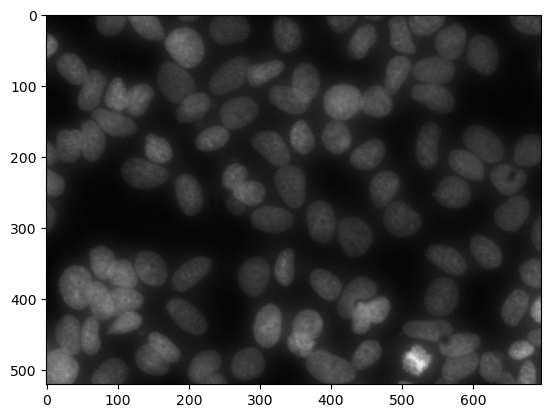

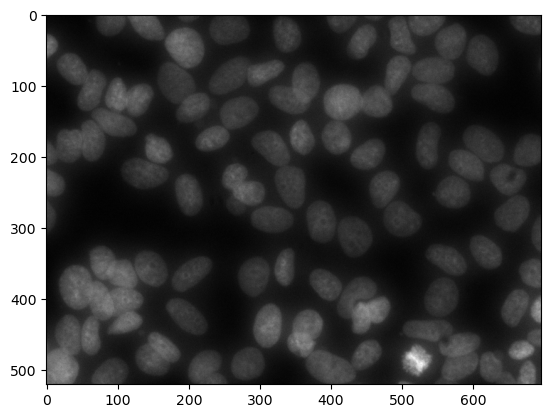

ValueError: Images of type float must be between -1 and 1.

In [141]:
#folder_path = r"V:/Laboratoires/Lécuyer/Juan-Carlos/HCS/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_F08_s4_w3.TIF"
#print(folder_path)
#well = 'B - 02'
#site = 'fld 1'
#channel_keywords = ["wv Blue - FITC", "wv Red - Cy5", "wv UV - DAPI"]
#channel = "Red - Cy5"
#image_type = '.tif'
#file_name ="{}({} {}){}".format(well, site, channel_keywords[1], image_type)
#file_path = os.path.join(folder_path, file_name)
#print(file_path)

im = plt.imread( r"V:/Laboratoires/Lécuyer/Juan-Carlos/HCS/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_F08_s4_w1.TIF")
assert im.dtype == np.uint16
# Show the image
plt.imshow(im, cmap='gray')
plt.show()


im_8bits = rescale_to_bits(im, 8)
plt.imshow(im_8bits, cmap='gray')
plt.show()


img_g = subtract_background(im_8bits, radius=50, light_bg=False)
#background = rolling_ball(im_8bits)
#im_8bits = im_8bits - background

# The color we provide gives RGB values in order, between 0 and 1
im_red = colorize(img_g[...,], (0, 1, 0))
#im_red = skimage.exposure.equalize_adapthist(im_red)
plt.imshow(im_red)
plt.axis(False)
plt.title('Magenta')
plt.show()

plt.imsave(r'C:\Users\PadillJ\Desktop\test3.tif', im_red,format='TIFF')

In [46]:

pathOut = r"D:/Easin_processed_images"+ '/'+basename(pathIn)


isExist = os.path.exists(pathOut) # Check whether the specified path exists or not
if not isExist:
    os.makedirs(pathOut)
    print("The new directory is created!")    
#OutFolder = 

#isExist = os.path.exists(pathOut+) # Check whether the specified path exists or not
#if not isExist:
#    os.makedirs(geneFolder)
#    print("The new directory is created!")    


The new directory is created!


In [81]:
import os
import re
import os.path 

# Define input and output directories
pathIn = r"S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1"
pathOut = r"S:/20230918_MCF7_Ab_DMSOGWFTY-2_ImageEnhancement/DMSO"+ '/'+os.path.basename(pathIn)

isExist = os.path.exists(pathOut) # Check whether the specified path exists or not

if not isExist:
    os.makedirs(pathOut)
    print("The new directory is created!")    

def prepend(list, str):
    str += '{0}'
    list = [str.format(i) for i in list]
    return(list)

# Define the well and site numbers
well_numbers_list = []
site_number_list = []

# Loop through all the files in the folder
for file_name in os.listdir(pathIn):
    condition, well, site, wavelength = file_name.split("_")
    well_numbers_list.append(well.strip())
    well_names_unique = sorted(set(well_numbers_list))
    site_number_list.append(re.search('\d+', site).group())
    min_site_number = int(min(site_number_list))
    max_site_number = int(max(site_number_list))
    #print(condition, well, site, wavelength)

# Remove duplicates (set) and sort(sorted) the well and site numbers
well_numbers = sorted(list(set(well_numbers_list)))
site_numbers = sorted(set(prepend(site_number_list, 's'))) 
image_type = '.TIF'

# Define the channels and their corresponding file name keywords
channels = ["blue", "green", "red"]
channel_keywords = ["w1", "w2", "w3"]

# Loop through all the wells and sites
for well in well_numbers:
    for site in site_numbers:
        im = []
        for i, channel in enumerate(channels):
            # Define the file name of the image for this channel, well, and site
            file_name = "{}_{}_{}_{}{}".format(condition, well, site, channel_keywords[i], image_type)
            print(file_name)
            file_path = pathIn +'/'+ file_name
            print(file_path)   
            try:
                im = plt.imread(file_path)
                assert im.dtype == np.uint16
            except FileNotFoundError:
                print(f"Skipping well {well}, site {site} for channel {channel}")
                continue
                
            im = rescale_to_bits(im, 8)
            #check which channel it is and colorize accordingly
            save_file_name = "{}_Pr_{}_{}_{}.tiff".format(condition, well, site, channel_keywords[i])
            save_file_name_path = pathOut + '/' + save_file_name
            if channel == 'green':
                background_g = rolling_ball(im)
                im_g_corr = im - background_g
                im_g = colorize(im_g_corr[...,], (0, 1, 0),clip_percentile=0.01)
                plt.imsave(save_file_name_path, im_g,format='TIFF')
            elif channel == 'red':
                background_r = rolling_ball(im)
                im_r_corr = im - background_r
                im_r = colorize(im_r_corr[...,], (1, 0, 0),clip_percentile=0.01)
                plt.imsave(save_file_name_path, im_r,format='TIFF')
            else :
                im_b = subtract_background(im, radius=50, light_bg=False)
                im_b = skimage.exposure.equalize_adapthist(im_b)
                im_b = colorize(im_b[...,], (0, 0, 1),clip_percentile=0.01)
                plt.imsave(save_file_name_path, im_b,format='TIFF')
                
        save_file_name_rg = "{}_Pr_{}_{}_mergeRG.tiff".format(condition, well, site)
        save_file_name_path_rgb = pathOut + '/' + save_file_name_rgb
        merge2 = np.clip(im_r + im_g  , 0, 1)
        plt.imsave(save_file_name_path_rgb, merge2,format='TIFF') #Saving the 3 colors merged file

        save_file_name_rb = "{}_Pr_{}_{}_mergeRB.tiff".format(condition, well, site)
        save_file_name_path_rgb = pathOut + '/' + save_file_name_rgb
        merge2 = np.clip(im_r + im_b , 0, 1)
        plt.imsave(save_file_name_path_rgb, merge2,format='TIFF') #Saving the 3 colors merged file

        save_file_name_gb = "{}_Pr_{}_{}_mergeGB.tiff".format(condition, well, site)
        save_file_name_path_rgb = pathOut + '/' + save_file_name_rgb
        merge2 = np.clip(im_g + im_b , 0, 1)
        plt.imsave(save_file_name_path_rgb, merge2,format='TIFF') #Saving the 3 colors merged file
                
        save_file_name_rgb = "{}_Pr_{}_{}_mergeRGB.tiff".format(condition, well, site)
        save_file_name_path_rgb = pathOut + '/' + save_file_name_rgb
        merge2 = np.clip(im_r + im_g + im_b , 0, 1)
        plt.imsave(save_file_name_path_rgb, merge2,format='TIFF') #Saving the 3 colors merged file
        


DMSO_A01_s1_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A01_s1_w1.TIF
DMSO_A01_s1_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A01_s1_w2.TIF
DMSO_A01_s1_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A01_s1_w3.TIF
DMSO_A01_s10_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A01_s10_w1.TIF
DMSO_A01_s10_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A01_s10_w2.TIF
DMSO_A01_s10_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A01_s10_w3.TIF
DMSO_A01_s11_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A01_s11_w1.TIF
DMSO_A01_s11_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A01_s11_w2.TIF
DMSO_A01_s11_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A01_s11_w3.TIF
DMSO_A01_s12_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/

DMSO_A01_s6_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A01_s6_w1.TIF
DMSO_A01_s6_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A01_s6_w2.TIF
DMSO_A01_s6_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A01_s6_w3.TIF
DMSO_A01_s7_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A01_s7_w1.TIF
DMSO_A01_s7_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A01_s7_w2.TIF
DMSO_A01_s7_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A01_s7_w3.TIF
DMSO_A01_s8_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A01_s8_w1.TIF
DMSO_A01_s8_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A01_s8_w2.TIF
DMSO_A01_s8_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A01_s8_w3.TIF
DMSO_A01_s9_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7

DMSO_A02_s3_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A02_s3_w1.TIF
DMSO_A02_s3_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A02_s3_w2.TIF
DMSO_A02_s3_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A02_s3_w3.TIF
DMSO_A02_s30_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A02_s30_w1.TIF
DMSO_A02_s30_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A02_s30_w2.TIF
DMSO_A02_s30_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A02_s30_w3.TIF
DMSO_A02_s4_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A02_s4_w1.TIF
DMSO_A02_s4_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A02_s4_w2.TIF
DMSO_A02_s4_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A02_s4_w3.TIF
DMSO_A02_s5_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/2023080

DMSO_A03_s26_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A03_s26_w1.TIF
DMSO_A03_s26_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A03_s26_w2.TIF
DMSO_A03_s26_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A03_s26_w3.TIF
DMSO_A03_s27_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A03_s27_w1.TIF
DMSO_A03_s27_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A03_s27_w2.TIF
DMSO_A03_s27_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A03_s27_w3.TIF
DMSO_A03_s28_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A03_s28_w1.TIF
DMSO_A03_s28_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A03_s28_w2.TIF
DMSO_A03_s28_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A03_s28_w3.TIF
DMSO_A03_s29_w1.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_A04_s22_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A04_s22_w1.TIF
DMSO_A04_s22_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A04_s22_w2.TIF
DMSO_A04_s22_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A04_s22_w3.TIF
DMSO_A04_s23_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A04_s23_w1.TIF
DMSO_A04_s23_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A04_s23_w2.TIF
DMSO_A04_s23_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A04_s23_w3.TIF
DMSO_A04_s24_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A04_s24_w1.TIF
DMSO_A04_s24_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A04_s24_w2.TIF
DMSO_A04_s24_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A04_s24_w3.TIF
DMSO_A04_s25_w1.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_A05_s19_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A05_s19_w1.TIF
DMSO_A05_s19_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A05_s19_w2.TIF
DMSO_A05_s19_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A05_s19_w3.TIF
DMSO_A05_s2_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A05_s2_w1.TIF
DMSO_A05_s2_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A05_s2_w2.TIF
DMSO_A05_s2_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A05_s2_w3.TIF
DMSO_A05_s20_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A05_s20_w1.TIF
DMSO_A05_s20_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A05_s20_w2.TIF
DMSO_A05_s20_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A05_s20_w3.TIF
DMSO_A05_s21_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/

DMSO_A06_s15_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A06_s15_w1.TIF
DMSO_A06_s15_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A06_s15_w2.TIF
DMSO_A06_s15_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A06_s15_w3.TIF
DMSO_A06_s16_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A06_s16_w1.TIF
DMSO_A06_s16_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A06_s16_w2.TIF
DMSO_A06_s16_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A06_s16_w3.TIF
DMSO_A06_s17_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A06_s17_w1.TIF
DMSO_A06_s17_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A06_s17_w2.TIF
DMSO_A06_s17_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A06_s17_w3.TIF
DMSO_A06_s18_w1.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_A07_s11_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A07_s11_w1.TIF
DMSO_A07_s11_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A07_s11_w2.TIF
DMSO_A07_s11_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A07_s11_w3.TIF
DMSO_A07_s12_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A07_s12_w1.TIF
DMSO_A07_s12_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A07_s12_w2.TIF
DMSO_A07_s12_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A07_s12_w3.TIF
DMSO_A07_s13_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A07_s13_w1.TIF
DMSO_A07_s13_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A07_s13_w2.TIF
DMSO_A07_s13_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A07_s13_w3.TIF
DMSO_A07_s14_w1.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_A07_s8_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A07_s8_w1.TIF
DMSO_A07_s8_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A07_s8_w2.TIF
DMSO_A07_s8_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A07_s8_w3.TIF
DMSO_A07_s9_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A07_s9_w1.TIF
DMSO_A07_s9_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A07_s9_w2.TIF
DMSO_A07_s9_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A07_s9_w3.TIF
DMSO_A08_s1_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A08_s1_w1.TIF
DMSO_A08_s1_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A08_s1_w2.TIF
DMSO_A08_s1_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A08_s1_w3.TIF
DMSO_A08_s10_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF

DMSO_A08_s4_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A08_s4_w1.TIF
DMSO_A08_s4_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A08_s4_w2.TIF
DMSO_A08_s4_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A08_s4_w3.TIF
DMSO_A08_s5_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A08_s5_w1.TIF
DMSO_A08_s5_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A08_s5_w2.TIF
DMSO_A08_s5_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A08_s5_w3.TIF
DMSO_A08_s6_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A08_s6_w1.TIF
DMSO_A08_s6_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A08_s6_w2.TIF
DMSO_A08_s6_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A08_s6_w3.TIF
DMSO_A08_s7_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7

DMSO_A09_s28_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A09_s28_w1.TIF
DMSO_A09_s28_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A09_s28_w2.TIF
DMSO_A09_s28_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A09_s28_w3.TIF
DMSO_A09_s29_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A09_s29_w1.TIF
DMSO_A09_s29_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A09_s29_w2.TIF
DMSO_A09_s29_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A09_s29_w3.TIF
DMSO_A09_s3_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A09_s3_w1.TIF
DMSO_A09_s3_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A09_s3_w2.TIF
DMSO_A09_s3_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A09_s3_w3.TIF
DMSO_A09_s30_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/

DMSO_A10_s24_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A10_s24_w1.TIF
DMSO_A10_s24_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A10_s24_w2.TIF
DMSO_A10_s24_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A10_s24_w3.TIF
DMSO_A10_s25_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A10_s25_w1.TIF
DMSO_A10_s25_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A10_s25_w2.TIF
DMSO_A10_s25_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A10_s25_w3.TIF
DMSO_A10_s26_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A10_s26_w1.TIF
DMSO_A10_s26_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A10_s26_w2.TIF
DMSO_A10_s26_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A10_s26_w3.TIF
DMSO_A10_s27_w1.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_A11_s20_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A11_s20_w1.TIF
DMSO_A11_s20_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A11_s20_w2.TIF
DMSO_A11_s20_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A11_s20_w3.TIF
DMSO_A11_s21_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A11_s21_w1.TIF
DMSO_A11_s21_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A11_s21_w2.TIF
DMSO_A11_s21_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A11_s21_w3.TIF
DMSO_A11_s22_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A11_s22_w1.TIF
DMSO_A11_s22_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A11_s22_w2.TIF
DMSO_A11_s22_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A11_s22_w3.TIF
DMSO_A11_s23_w1.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_A12_s17_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A12_s17_w1.TIF
DMSO_A12_s17_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A12_s17_w2.TIF
DMSO_A12_s17_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A12_s17_w3.TIF
DMSO_A12_s18_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A12_s18_w1.TIF
DMSO_A12_s18_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A12_s18_w2.TIF
DMSO_A12_s18_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A12_s18_w3.TIF
DMSO_A12_s19_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A12_s19_w1.TIF
DMSO_A12_s19_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A12_s19_w2.TIF
DMSO_A12_s19_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_A12_s19_w3.TIF
DMSO_A12_s2_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWF

DMSO_B01_s13_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B01_s13_w1.TIF
DMSO_B01_s13_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B01_s13_w2.TIF
DMSO_B01_s13_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B01_s13_w3.TIF
DMSO_B01_s14_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B01_s14_w1.TIF
DMSO_B01_s14_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B01_s14_w2.TIF
DMSO_B01_s14_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B01_s14_w3.TIF
DMSO_B01_s15_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B01_s15_w1.TIF
DMSO_B01_s15_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B01_s15_w2.TIF
DMSO_B01_s15_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B01_s15_w3.TIF
DMSO_B01_s16_w1.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_B02_s1_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B02_s1_w1.TIF
DMSO_B02_s1_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B02_s1_w2.TIF
DMSO_B02_s1_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B02_s1_w3.TIF
DMSO_B02_s10_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B02_s10_w1.TIF
DMSO_B02_s10_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B02_s10_w2.TIF
DMSO_B02_s10_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B02_s10_w3.TIF
DMSO_B02_s11_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B02_s11_w1.TIF
DMSO_B02_s11_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B02_s11_w2.TIF
DMSO_B02_s11_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B02_s11_w3.TIF
DMSO_B02_s12_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/

DMSO_B02_s6_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B02_s6_w1.TIF
DMSO_B02_s6_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B02_s6_w2.TIF
DMSO_B02_s6_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B02_s6_w3.TIF
DMSO_B02_s7_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B02_s7_w1.TIF
DMSO_B02_s7_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B02_s7_w2.TIF
DMSO_B02_s7_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B02_s7_w3.TIF
DMSO_B02_s8_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B02_s8_w1.TIF
DMSO_B02_s8_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B02_s8_w2.TIF
DMSO_B02_s8_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B02_s8_w3.TIF
DMSO_B02_s9_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7

DMSO_B03_s3_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B03_s3_w1.TIF
DMSO_B03_s3_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B03_s3_w2.TIF
DMSO_B03_s3_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B03_s3_w3.TIF
DMSO_B03_s30_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B03_s30_w1.TIF
DMSO_B03_s30_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B03_s30_w2.TIF
DMSO_B03_s30_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B03_s30_w3.TIF
DMSO_B03_s4_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B03_s4_w1.TIF
DMSO_B03_s4_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B03_s4_w2.TIF
DMSO_B03_s4_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B03_s4_w3.TIF
DMSO_B03_s5_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/2023080

DMSO_B04_s26_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B04_s26_w1.TIF
DMSO_B04_s26_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B04_s26_w2.TIF
DMSO_B04_s26_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B04_s26_w3.TIF
DMSO_B04_s27_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B04_s27_w1.TIF
DMSO_B04_s27_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B04_s27_w2.TIF
DMSO_B04_s27_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B04_s27_w3.TIF
DMSO_B04_s28_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B04_s28_w1.TIF
DMSO_B04_s28_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B04_s28_w2.TIF
DMSO_B04_s28_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B04_s28_w3.TIF
DMSO_B04_s29_w1.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_B05_s22_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B05_s22_w1.TIF
DMSO_B05_s22_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B05_s22_w2.TIF
DMSO_B05_s22_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B05_s22_w3.TIF
DMSO_B05_s23_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B05_s23_w1.TIF
DMSO_B05_s23_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B05_s23_w2.TIF
DMSO_B05_s23_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B05_s23_w3.TIF
DMSO_B05_s24_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B05_s24_w1.TIF
DMSO_B05_s24_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B05_s24_w2.TIF
DMSO_B05_s24_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B05_s24_w3.TIF
DMSO_B05_s25_w1.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_B06_s19_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B06_s19_w1.TIF
DMSO_B06_s19_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B06_s19_w2.TIF
DMSO_B06_s19_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B06_s19_w3.TIF
DMSO_B06_s2_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B06_s2_w1.TIF
DMSO_B06_s2_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B06_s2_w2.TIF
DMSO_B06_s2_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B06_s2_w3.TIF
DMSO_B06_s20_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B06_s20_w1.TIF
DMSO_B06_s20_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B06_s20_w2.TIF
DMSO_B06_s20_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B06_s20_w3.TIF
DMSO_B06_s21_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/

DMSO_B07_s15_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B07_s15_w1.TIF
DMSO_B07_s15_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B07_s15_w2.TIF
DMSO_B07_s15_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B07_s15_w3.TIF
DMSO_B07_s16_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B07_s16_w1.TIF
DMSO_B07_s16_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B07_s16_w2.TIF
DMSO_B07_s16_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B07_s16_w3.TIF
DMSO_B07_s17_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B07_s17_w1.TIF
DMSO_B07_s17_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B07_s17_w2.TIF
DMSO_B07_s17_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B07_s17_w3.TIF
DMSO_B07_s18_w1.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_B08_s11_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B08_s11_w1.TIF
DMSO_B08_s11_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B08_s11_w2.TIF
DMSO_B08_s11_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B08_s11_w3.TIF
DMSO_B08_s12_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B08_s12_w1.TIF
DMSO_B08_s12_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B08_s12_w2.TIF
DMSO_B08_s12_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B08_s12_w3.TIF
DMSO_B08_s13_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B08_s13_w1.TIF
DMSO_B08_s13_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B08_s13_w2.TIF
DMSO_B08_s13_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B08_s13_w3.TIF
DMSO_B08_s14_w1.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_B08_s8_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B08_s8_w1.TIF
DMSO_B08_s8_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B08_s8_w2.TIF
DMSO_B08_s8_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B08_s8_w3.TIF
DMSO_B08_s9_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B08_s9_w1.TIF
DMSO_B08_s9_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B08_s9_w2.TIF
DMSO_B08_s9_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B08_s9_w3.TIF
DMSO_B09_s1_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B09_s1_w1.TIF
DMSO_B09_s1_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B09_s1_w2.TIF
DMSO_B09_s1_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B09_s1_w3.TIF
DMSO_B09_s10_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF

DMSO_B09_s4_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B09_s4_w1.TIF
DMSO_B09_s4_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B09_s4_w2.TIF
DMSO_B09_s4_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B09_s4_w3.TIF
DMSO_B09_s5_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B09_s5_w1.TIF
DMSO_B09_s5_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B09_s5_w2.TIF
DMSO_B09_s5_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B09_s5_w3.TIF
DMSO_B09_s6_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B09_s6_w1.TIF
DMSO_B09_s6_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B09_s6_w2.TIF
DMSO_B09_s6_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B09_s6_w3.TIF
DMSO_B09_s7_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7

DMSO_B10_s28_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B10_s28_w1.TIF
DMSO_B10_s28_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B10_s28_w2.TIF
DMSO_B10_s28_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B10_s28_w3.TIF
DMSO_B10_s29_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B10_s29_w1.TIF
DMSO_B10_s29_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B10_s29_w2.TIF
DMSO_B10_s29_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B10_s29_w3.TIF
DMSO_B10_s3_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B10_s3_w1.TIF
DMSO_B10_s3_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B10_s3_w2.TIF
DMSO_B10_s3_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B10_s3_w3.TIF
DMSO_B10_s30_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/

DMSO_B11_s24_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B11_s24_w1.TIF
DMSO_B11_s24_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B11_s24_w2.TIF
DMSO_B11_s24_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B11_s24_w3.TIF
DMSO_B11_s25_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B11_s25_w1.TIF
DMSO_B11_s25_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B11_s25_w2.TIF
DMSO_B11_s25_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B11_s25_w3.TIF
DMSO_B11_s26_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B11_s26_w1.TIF
DMSO_B11_s26_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B11_s26_w2.TIF
DMSO_B11_s26_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B11_s26_w3.TIF
DMSO_B11_s27_w1.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_B12_s20_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B12_s20_w1.TIF
DMSO_B12_s20_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B12_s20_w2.TIF
DMSO_B12_s20_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B12_s20_w3.TIF
DMSO_B12_s21_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B12_s21_w1.TIF
DMSO_B12_s21_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B12_s21_w2.TIF
DMSO_B12_s21_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B12_s21_w3.TIF
DMSO_B12_s22_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B12_s22_w1.TIF
DMSO_B12_s22_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B12_s22_w2.TIF
DMSO_B12_s22_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_B12_s22_w3.TIF
DMSO_B12_s23_w1.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_C01_s17_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C01_s17_w1.TIF
DMSO_C01_s17_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C01_s17_w2.TIF
DMSO_C01_s17_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C01_s17_w3.TIF
DMSO_C01_s18_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C01_s18_w1.TIF
DMSO_C01_s18_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C01_s18_w2.TIF
DMSO_C01_s18_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C01_s18_w3.TIF
DMSO_C01_s19_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C01_s19_w1.TIF
DMSO_C01_s19_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C01_s19_w2.TIF
DMSO_C01_s19_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C01_s19_w3.TIF
DMSO_C01_s2_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWF

DMSO_C02_s13_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C02_s13_w1.TIF
DMSO_C02_s13_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C02_s13_w2.TIF
DMSO_C02_s13_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C02_s13_w3.TIF
DMSO_C02_s14_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C02_s14_w1.TIF
DMSO_C02_s14_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C02_s14_w2.TIF
DMSO_C02_s14_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C02_s14_w3.TIF
DMSO_C02_s15_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C02_s15_w1.TIF
DMSO_C02_s15_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C02_s15_w2.TIF
DMSO_C02_s15_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C02_s15_w3.TIF
DMSO_C02_s16_w1.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_C03_s1_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C03_s1_w1.TIF
DMSO_C03_s1_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C03_s1_w2.TIF
DMSO_C03_s1_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C03_s1_w3.TIF
DMSO_C03_s10_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C03_s10_w1.TIF
DMSO_C03_s10_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C03_s10_w2.TIF
DMSO_C03_s10_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C03_s10_w3.TIF
DMSO_C03_s11_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C03_s11_w1.TIF
DMSO_C03_s11_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C03_s11_w2.TIF
DMSO_C03_s11_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C03_s11_w3.TIF
DMSO_C03_s12_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/

DMSO_C03_s6_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C03_s6_w1.TIF
DMSO_C03_s6_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C03_s6_w2.TIF
DMSO_C03_s6_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C03_s6_w3.TIF
DMSO_C03_s7_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C03_s7_w1.TIF
DMSO_C03_s7_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C03_s7_w2.TIF
DMSO_C03_s7_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C03_s7_w3.TIF
DMSO_C03_s8_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C03_s8_w1.TIF
DMSO_C03_s8_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C03_s8_w2.TIF
DMSO_C03_s8_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C03_s8_w3.TIF
DMSO_C03_s9_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7

DMSO_C04_s3_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C04_s3_w1.TIF
DMSO_C04_s3_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C04_s3_w2.TIF
DMSO_C04_s3_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C04_s3_w3.TIF
DMSO_C04_s30_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C04_s30_w1.TIF
DMSO_C04_s30_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C04_s30_w2.TIF
DMSO_C04_s30_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C04_s30_w3.TIF
DMSO_C04_s4_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C04_s4_w1.TIF
DMSO_C04_s4_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C04_s4_w2.TIF
DMSO_C04_s4_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C04_s4_w3.TIF
DMSO_C04_s5_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/2023080

DMSO_C05_s26_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C05_s26_w1.TIF
DMSO_C05_s26_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C05_s26_w2.TIF
DMSO_C05_s26_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C05_s26_w3.TIF
DMSO_C05_s27_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C05_s27_w1.TIF
DMSO_C05_s27_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C05_s27_w2.TIF
DMSO_C05_s27_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C05_s27_w3.TIF
DMSO_C05_s28_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C05_s28_w1.TIF
DMSO_C05_s28_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C05_s28_w2.TIF
DMSO_C05_s28_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C05_s28_w3.TIF
DMSO_C05_s29_w1.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_C06_s22_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C06_s22_w1.TIF
DMSO_C06_s22_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C06_s22_w2.TIF
DMSO_C06_s22_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C06_s22_w3.TIF
DMSO_C06_s23_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C06_s23_w1.TIF
DMSO_C06_s23_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C06_s23_w2.TIF
DMSO_C06_s23_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C06_s23_w3.TIF
DMSO_C06_s24_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C06_s24_w1.TIF
DMSO_C06_s24_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C06_s24_w2.TIF
DMSO_C06_s24_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C06_s24_w3.TIF
DMSO_C06_s25_w1.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_C07_s19_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C07_s19_w1.TIF
DMSO_C07_s19_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C07_s19_w2.TIF
DMSO_C07_s19_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C07_s19_w3.TIF
DMSO_C07_s2_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C07_s2_w1.TIF
DMSO_C07_s2_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C07_s2_w2.TIF
DMSO_C07_s2_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C07_s2_w3.TIF
DMSO_C07_s20_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C07_s20_w1.TIF
DMSO_C07_s20_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C07_s20_w2.TIF
DMSO_C07_s20_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C07_s20_w3.TIF
DMSO_C07_s21_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/

DMSO_C08_s15_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C08_s15_w1.TIF
DMSO_C08_s15_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C08_s15_w2.TIF
DMSO_C08_s15_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C08_s15_w3.TIF
DMSO_C08_s16_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C08_s16_w1.TIF
DMSO_C08_s16_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C08_s16_w2.TIF
DMSO_C08_s16_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C08_s16_w3.TIF
DMSO_C08_s17_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C08_s17_w1.TIF
DMSO_C08_s17_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C08_s17_w2.TIF
DMSO_C08_s17_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C08_s17_w3.TIF
DMSO_C08_s18_w1.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_C09_s11_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C09_s11_w1.TIF
DMSO_C09_s11_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C09_s11_w2.TIF
DMSO_C09_s11_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C09_s11_w3.TIF
DMSO_C09_s12_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C09_s12_w1.TIF
DMSO_C09_s12_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C09_s12_w2.TIF
DMSO_C09_s12_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C09_s12_w3.TIF
DMSO_C09_s13_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C09_s13_w1.TIF
DMSO_C09_s13_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C09_s13_w2.TIF
DMSO_C09_s13_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C09_s13_w3.TIF
DMSO_C09_s14_w1.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_C09_s8_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C09_s8_w1.TIF
DMSO_C09_s8_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C09_s8_w2.TIF
DMSO_C09_s8_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C09_s8_w3.TIF
DMSO_C09_s9_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C09_s9_w1.TIF
DMSO_C09_s9_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C09_s9_w2.TIF
DMSO_C09_s9_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C09_s9_w3.TIF
DMSO_C10_s1_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C10_s1_w1.TIF
DMSO_C10_s1_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C10_s1_w2.TIF
DMSO_C10_s1_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C10_s1_w3.TIF
DMSO_C10_s10_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF

DMSO_C10_s4_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C10_s4_w1.TIF
DMSO_C10_s4_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C10_s4_w2.TIF
DMSO_C10_s4_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C10_s4_w3.TIF
DMSO_C10_s5_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C10_s5_w1.TIF
DMSO_C10_s5_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C10_s5_w2.TIF
DMSO_C10_s5_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C10_s5_w3.TIF
DMSO_C10_s6_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C10_s6_w1.TIF
DMSO_C10_s6_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C10_s6_w2.TIF
DMSO_C10_s6_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C10_s6_w3.TIF
DMSO_C10_s7_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7

DMSO_C11_s28_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C11_s28_w1.TIF
DMSO_C11_s28_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C11_s28_w2.TIF
DMSO_C11_s28_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C11_s28_w3.TIF
DMSO_C11_s29_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C11_s29_w1.TIF
DMSO_C11_s29_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C11_s29_w2.TIF
DMSO_C11_s29_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C11_s29_w3.TIF
DMSO_C11_s3_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C11_s3_w1.TIF
DMSO_C11_s3_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C11_s3_w2.TIF
DMSO_C11_s3_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C11_s3_w3.TIF
DMSO_C11_s30_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/

DMSO_C12_s24_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C12_s24_w1.TIF
DMSO_C12_s24_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C12_s24_w2.TIF
DMSO_C12_s24_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C12_s24_w3.TIF
DMSO_C12_s25_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C12_s25_w1.TIF
DMSO_C12_s25_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C12_s25_w2.TIF
DMSO_C12_s25_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C12_s25_w3.TIF
DMSO_C12_s26_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C12_s26_w1.TIF
DMSO_C12_s26_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C12_s26_w2.TIF
DMSO_C12_s26_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_C12_s26_w3.TIF
DMSO_C12_s27_w1.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_D01_s20_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D01_s20_w1.TIF
DMSO_D01_s20_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D01_s20_w2.TIF
DMSO_D01_s20_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D01_s20_w3.TIF
DMSO_D01_s21_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D01_s21_w1.TIF
DMSO_D01_s21_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D01_s21_w2.TIF
DMSO_D01_s21_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D01_s21_w3.TIF
DMSO_D01_s22_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D01_s22_w1.TIF
DMSO_D01_s22_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D01_s22_w2.TIF
DMSO_D01_s22_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D01_s22_w3.TIF
DMSO_D01_s23_w1.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_D02_s17_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D02_s17_w1.TIF
DMSO_D02_s17_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D02_s17_w2.TIF
DMSO_D02_s17_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D02_s17_w3.TIF
DMSO_D02_s18_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D02_s18_w1.TIF
DMSO_D02_s18_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D02_s18_w2.TIF
DMSO_D02_s18_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D02_s18_w3.TIF
DMSO_D02_s19_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D02_s19_w1.TIF
DMSO_D02_s19_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D02_s19_w2.TIF
DMSO_D02_s19_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D02_s19_w3.TIF
DMSO_D02_s2_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWF

DMSO_D03_s13_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D03_s13_w1.TIF
DMSO_D03_s13_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D03_s13_w2.TIF
DMSO_D03_s13_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D03_s13_w3.TIF
DMSO_D03_s14_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D03_s14_w1.TIF
DMSO_D03_s14_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D03_s14_w2.TIF
DMSO_D03_s14_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D03_s14_w3.TIF
DMSO_D03_s15_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D03_s15_w1.TIF
DMSO_D03_s15_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D03_s15_w2.TIF
DMSO_D03_s15_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D03_s15_w3.TIF
DMSO_D03_s16_w1.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_D04_s1_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D04_s1_w1.TIF
DMSO_D04_s1_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D04_s1_w2.TIF
DMSO_D04_s1_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D04_s1_w3.TIF
DMSO_D04_s10_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D04_s10_w1.TIF
DMSO_D04_s10_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D04_s10_w2.TIF
DMSO_D04_s10_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D04_s10_w3.TIF
DMSO_D04_s11_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D04_s11_w1.TIF
DMSO_D04_s11_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D04_s11_w2.TIF
DMSO_D04_s11_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D04_s11_w3.TIF
DMSO_D04_s12_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/

DMSO_D04_s6_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D04_s6_w1.TIF
DMSO_D04_s6_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D04_s6_w2.TIF
DMSO_D04_s6_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D04_s6_w3.TIF
DMSO_D04_s7_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D04_s7_w1.TIF
DMSO_D04_s7_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D04_s7_w2.TIF
DMSO_D04_s7_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D04_s7_w3.TIF
DMSO_D04_s8_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D04_s8_w1.TIF
DMSO_D04_s8_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D04_s8_w2.TIF
DMSO_D04_s8_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D04_s8_w3.TIF
DMSO_D04_s9_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7

DMSO_D05_s3_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D05_s3_w1.TIF
DMSO_D05_s3_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D05_s3_w2.TIF
DMSO_D05_s3_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D05_s3_w3.TIF
DMSO_D05_s30_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D05_s30_w1.TIF
DMSO_D05_s30_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D05_s30_w2.TIF
DMSO_D05_s30_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D05_s30_w3.TIF
DMSO_D05_s4_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D05_s4_w1.TIF
DMSO_D05_s4_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D05_s4_w2.TIF
DMSO_D05_s4_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D05_s4_w3.TIF
DMSO_D05_s5_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/2023080

DMSO_D06_s26_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D06_s26_w1.TIF
DMSO_D06_s26_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D06_s26_w2.TIF
DMSO_D06_s26_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D06_s26_w3.TIF
DMSO_D06_s27_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D06_s27_w1.TIF
DMSO_D06_s27_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D06_s27_w2.TIF
DMSO_D06_s27_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D06_s27_w3.TIF
DMSO_D06_s28_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D06_s28_w1.TIF
DMSO_D06_s28_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D06_s28_w2.TIF
DMSO_D06_s28_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D06_s28_w3.TIF
DMSO_D06_s29_w1.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_D07_s22_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D07_s22_w1.TIF
DMSO_D07_s22_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D07_s22_w2.TIF
DMSO_D07_s22_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D07_s22_w3.TIF
DMSO_D07_s23_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D07_s23_w1.TIF
DMSO_D07_s23_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D07_s23_w2.TIF
DMSO_D07_s23_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D07_s23_w3.TIF
DMSO_D07_s24_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D07_s24_w1.TIF
DMSO_D07_s24_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D07_s24_w2.TIF
DMSO_D07_s24_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D07_s24_w3.TIF
DMSO_D07_s25_w1.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_D08_s19_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D08_s19_w1.TIF
DMSO_D08_s19_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D08_s19_w2.TIF
DMSO_D08_s19_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D08_s19_w3.TIF
DMSO_D08_s2_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D08_s2_w1.TIF
DMSO_D08_s2_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D08_s2_w2.TIF
DMSO_D08_s2_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D08_s2_w3.TIF
DMSO_D08_s20_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D08_s20_w1.TIF
DMSO_D08_s20_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D08_s20_w2.TIF
DMSO_D08_s20_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D08_s20_w3.TIF
DMSO_D08_s21_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/

DMSO_D09_s15_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D09_s15_w1.TIF
DMSO_D09_s15_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D09_s15_w2.TIF
DMSO_D09_s15_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D09_s15_w3.TIF
DMSO_D09_s16_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D09_s16_w1.TIF
DMSO_D09_s16_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D09_s16_w2.TIF
DMSO_D09_s16_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D09_s16_w3.TIF
DMSO_D09_s17_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D09_s17_w1.TIF
DMSO_D09_s17_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D09_s17_w2.TIF
DMSO_D09_s17_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D09_s17_w3.TIF
DMSO_D09_s18_w1.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_D10_s11_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D10_s11_w1.TIF
DMSO_D10_s11_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D10_s11_w2.TIF
DMSO_D10_s11_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D10_s11_w3.TIF
DMSO_D10_s12_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D10_s12_w1.TIF
DMSO_D10_s12_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D10_s12_w2.TIF
DMSO_D10_s12_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D10_s12_w3.TIF
DMSO_D10_s13_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D10_s13_w1.TIF
DMSO_D10_s13_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D10_s13_w2.TIF
DMSO_D10_s13_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D10_s13_w3.TIF
DMSO_D10_s14_w1.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_D10_s8_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D10_s8_w1.TIF
DMSO_D10_s8_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D10_s8_w2.TIF
DMSO_D10_s8_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D10_s8_w3.TIF
DMSO_D10_s9_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D10_s9_w1.TIF
DMSO_D10_s9_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D10_s9_w2.TIF
DMSO_D10_s9_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D10_s9_w3.TIF
DMSO_D11_s1_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D11_s1_w1.TIF
DMSO_D11_s1_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D11_s1_w2.TIF
DMSO_D11_s1_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D11_s1_w3.TIF
DMSO_D11_s10_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF

DMSO_D11_s4_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D11_s4_w1.TIF
DMSO_D11_s4_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D11_s4_w2.TIF
DMSO_D11_s4_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D11_s4_w3.TIF
DMSO_D11_s5_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D11_s5_w1.TIF
DMSO_D11_s5_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D11_s5_w2.TIF
DMSO_D11_s5_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D11_s5_w3.TIF
DMSO_D11_s6_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D11_s6_w1.TIF
DMSO_D11_s6_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D11_s6_w2.TIF
DMSO_D11_s6_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D11_s6_w3.TIF
DMSO_D11_s7_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7

DMSO_D12_s28_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D12_s28_w1.TIF
DMSO_D12_s28_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D12_s28_w2.TIF
DMSO_D12_s28_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D12_s28_w3.TIF
DMSO_D12_s29_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D12_s29_w1.TIF
DMSO_D12_s29_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D12_s29_w2.TIF
DMSO_D12_s29_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D12_s29_w3.TIF
DMSO_D12_s3_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D12_s3_w1.TIF
DMSO_D12_s3_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D12_s3_w2.TIF
DMSO_D12_s3_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_D12_s3_w3.TIF
DMSO_D12_s30_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/

DMSO_E01_s24_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E01_s24_w1.TIF
DMSO_E01_s24_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E01_s24_w2.TIF
DMSO_E01_s24_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E01_s24_w3.TIF
DMSO_E01_s25_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E01_s25_w1.TIF
DMSO_E01_s25_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E01_s25_w2.TIF
DMSO_E01_s25_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E01_s25_w3.TIF
DMSO_E01_s26_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E01_s26_w1.TIF
DMSO_E01_s26_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E01_s26_w2.TIF
DMSO_E01_s26_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E01_s26_w3.TIF
DMSO_E01_s27_w1.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_E02_s20_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E02_s20_w1.TIF
DMSO_E02_s20_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E02_s20_w2.TIF
DMSO_E02_s20_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E02_s20_w3.TIF
DMSO_E02_s21_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E02_s21_w1.TIF
DMSO_E02_s21_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E02_s21_w2.TIF
DMSO_E02_s21_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E02_s21_w3.TIF
DMSO_E02_s22_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E02_s22_w1.TIF
DMSO_E02_s22_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E02_s22_w2.TIF
DMSO_E02_s22_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E02_s22_w3.TIF
DMSO_E02_s23_w1.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_E03_s17_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E03_s17_w1.TIF
DMSO_E03_s17_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E03_s17_w2.TIF
DMSO_E03_s17_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E03_s17_w3.TIF
DMSO_E03_s18_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E03_s18_w1.TIF
DMSO_E03_s18_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E03_s18_w2.TIF
DMSO_E03_s18_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E03_s18_w3.TIF
DMSO_E03_s19_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E03_s19_w1.TIF
DMSO_E03_s19_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E03_s19_w2.TIF
DMSO_E03_s19_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E03_s19_w3.TIF
DMSO_E03_s2_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWF

DMSO_E04_s13_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E04_s13_w1.TIF
DMSO_E04_s13_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E04_s13_w2.TIF
DMSO_E04_s13_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E04_s13_w3.TIF
DMSO_E04_s14_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E04_s14_w1.TIF
DMSO_E04_s14_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E04_s14_w2.TIF
DMSO_E04_s14_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E04_s14_w3.TIF
DMSO_E04_s15_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E04_s15_w1.TIF
DMSO_E04_s15_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E04_s15_w2.TIF
DMSO_E04_s15_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E04_s15_w3.TIF
DMSO_E04_s16_w1.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_E05_s1_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E05_s1_w1.TIF
DMSO_E05_s1_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E05_s1_w2.TIF
DMSO_E05_s1_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E05_s1_w3.TIF
DMSO_E05_s10_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E05_s10_w1.TIF
DMSO_E05_s10_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E05_s10_w2.TIF
DMSO_E05_s10_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E05_s10_w3.TIF
DMSO_E05_s11_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E05_s11_w1.TIF
DMSO_E05_s11_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E05_s11_w2.TIF
DMSO_E05_s11_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E05_s11_w3.TIF
DMSO_E05_s12_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/

DMSO_E05_s6_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E05_s6_w1.TIF
DMSO_E05_s6_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E05_s6_w2.TIF
DMSO_E05_s6_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E05_s6_w3.TIF
DMSO_E05_s7_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E05_s7_w1.TIF
DMSO_E05_s7_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E05_s7_w2.TIF
DMSO_E05_s7_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E05_s7_w3.TIF
DMSO_E05_s8_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E05_s8_w1.TIF
DMSO_E05_s8_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E05_s8_w2.TIF
DMSO_E05_s8_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E05_s8_w3.TIF
DMSO_E05_s9_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7

DMSO_E06_s3_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E06_s3_w1.TIF
DMSO_E06_s3_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E06_s3_w2.TIF
DMSO_E06_s3_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E06_s3_w3.TIF
DMSO_E06_s30_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E06_s30_w1.TIF
DMSO_E06_s30_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E06_s30_w2.TIF
DMSO_E06_s30_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E06_s30_w3.TIF
DMSO_E06_s4_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E06_s4_w1.TIF
DMSO_E06_s4_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E06_s4_w2.TIF
DMSO_E06_s4_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E06_s4_w3.TIF
DMSO_E06_s5_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/2023080

DMSO_E07_s26_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E07_s26_w1.TIF
DMSO_E07_s26_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E07_s26_w2.TIF
DMSO_E07_s26_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E07_s26_w3.TIF
DMSO_E07_s27_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E07_s27_w1.TIF
DMSO_E07_s27_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E07_s27_w2.TIF
DMSO_E07_s27_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E07_s27_w3.TIF
DMSO_E07_s28_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E07_s28_w1.TIF
DMSO_E07_s28_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E07_s28_w2.TIF
DMSO_E07_s28_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E07_s28_w3.TIF
DMSO_E07_s29_w1.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_E08_s22_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E08_s22_w1.TIF
DMSO_E08_s22_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E08_s22_w2.TIF
DMSO_E08_s22_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E08_s22_w3.TIF
DMSO_E08_s23_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E08_s23_w1.TIF
DMSO_E08_s23_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E08_s23_w2.TIF
DMSO_E08_s23_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E08_s23_w3.TIF
DMSO_E08_s24_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E08_s24_w1.TIF
DMSO_E08_s24_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E08_s24_w2.TIF
DMSO_E08_s24_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E08_s24_w3.TIF
DMSO_E08_s25_w1.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_E09_s19_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E09_s19_w1.TIF
DMSO_E09_s19_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E09_s19_w2.TIF
DMSO_E09_s19_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E09_s19_w3.TIF
DMSO_E09_s2_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E09_s2_w1.TIF
DMSO_E09_s2_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E09_s2_w2.TIF
DMSO_E09_s2_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E09_s2_w3.TIF
DMSO_E09_s20_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E09_s20_w1.TIF
DMSO_E09_s20_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E09_s20_w2.TIF
DMSO_E09_s20_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E09_s20_w3.TIF
DMSO_E09_s21_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/

DMSO_E10_s15_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E10_s15_w1.TIF
DMSO_E10_s15_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E10_s15_w2.TIF
DMSO_E10_s15_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E10_s15_w3.TIF
DMSO_E10_s16_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E10_s16_w1.TIF
DMSO_E10_s16_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E10_s16_w2.TIF
DMSO_E10_s16_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E10_s16_w3.TIF
DMSO_E10_s17_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E10_s17_w1.TIF
DMSO_E10_s17_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E10_s17_w2.TIF
DMSO_E10_s17_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E10_s17_w3.TIF
DMSO_E10_s18_w1.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_E11_s11_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E11_s11_w1.TIF
DMSO_E11_s11_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E11_s11_w2.TIF
DMSO_E11_s11_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E11_s11_w3.TIF
DMSO_E11_s12_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E11_s12_w1.TIF
DMSO_E11_s12_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E11_s12_w2.TIF
DMSO_E11_s12_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E11_s12_w3.TIF
DMSO_E11_s13_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E11_s13_w1.TIF
DMSO_E11_s13_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E11_s13_w2.TIF
DMSO_E11_s13_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E11_s13_w3.TIF
DMSO_E11_s14_w1.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_E11_s8_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E11_s8_w1.TIF
DMSO_E11_s8_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E11_s8_w2.TIF
DMSO_E11_s8_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E11_s8_w3.TIF
DMSO_E11_s9_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E11_s9_w1.TIF
DMSO_E11_s9_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E11_s9_w2.TIF
DMSO_E11_s9_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E11_s9_w3.TIF
DMSO_E12_s1_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E12_s1_w1.TIF
DMSO_E12_s1_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E12_s1_w2.TIF
DMSO_E12_s1_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E12_s1_w3.TIF
DMSO_E12_s10_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF

DMSO_E12_s4_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E12_s4_w1.TIF
DMSO_E12_s4_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E12_s4_w2.TIF
DMSO_E12_s4_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E12_s4_w3.TIF
DMSO_E12_s5_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E12_s5_w1.TIF
DMSO_E12_s5_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E12_s5_w2.TIF
DMSO_E12_s5_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E12_s5_w3.TIF
DMSO_E12_s6_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E12_s6_w1.TIF
DMSO_E12_s6_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E12_s6_w2.TIF
DMSO_E12_s6_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_E12_s6_w3.TIF
DMSO_E12_s7_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7

DMSO_F01_s28_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_F01_s28_w1.TIF
DMSO_F01_s28_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_F01_s28_w2.TIF
DMSO_F01_s28_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_F01_s28_w3.TIF
DMSO_F01_s29_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_F01_s29_w1.TIF
DMSO_F01_s29_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_F01_s29_w2.TIF
DMSO_F01_s29_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_F01_s29_w3.TIF
DMSO_F01_s3_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_F01_s3_w1.TIF
DMSO_F01_s3_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_F01_s3_w2.TIF
DMSO_F01_s3_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_F01_s3_w3.TIF
DMSO_F01_s30_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/

DMSO_F02_s24_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_F02_s24_w1.TIF
DMSO_F02_s24_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_F02_s24_w2.TIF
DMSO_F02_s24_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_F02_s24_w3.TIF
DMSO_F02_s25_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_F02_s25_w1.TIF
DMSO_F02_s25_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_F02_s25_w2.TIF
DMSO_F02_s25_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_F02_s25_w3.TIF
DMSO_F02_s26_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_F02_s26_w1.TIF
DMSO_F02_s26_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_F02_s26_w2.TIF
DMSO_F02_s26_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_F02_s26_w3.TIF
DMSO_F02_s27_w1.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_F03_s20_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_F03_s20_w1.TIF
DMSO_F03_s20_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_F03_s20_w2.TIF
DMSO_F03_s20_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_F03_s20_w3.TIF
DMSO_F03_s21_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_F03_s21_w1.TIF
DMSO_F03_s21_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_F03_s21_w2.TIF
DMSO_F03_s21_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_F03_s21_w3.TIF
DMSO_F03_s22_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_F03_s22_w1.TIF
DMSO_F03_s22_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_F03_s22_w2.TIF
DMSO_F03_s22_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_F03_s22_w3.TIF
DMSO_F03_s23_w1.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_F04_s17_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_F04_s17_w1.TIF
DMSO_F04_s17_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_F04_s17_w2.TIF
DMSO_F04_s17_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_F04_s17_w3.TIF
DMSO_F04_s18_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_F04_s18_w1.TIF
DMSO_F04_s18_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_F04_s18_w2.TIF
DMSO_F04_s18_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_F04_s18_w3.TIF
DMSO_F04_s19_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_F04_s19_w1.TIF
DMSO_F04_s19_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_F04_s19_w2.TIF
DMSO_F04_s19_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1/DMSO_F04_s19_w3.TIF
DMSO_F04_s2_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWF

KeyboardInterrupt: 

In [147]:
inputFolder = 'S:/20230802_MCF7_Ab_DMSOGWFTY-2/'

listOfDirectories = []

for inputFolder, dirs, files in os.walk(inputFolder):
    for subdir in dirs:
        print(os.path.join(inputFolder, subdir))
        listOfDirectories.append(os.path.join(inputFolder, subdir))
        
def partial(lst, query):
    return [s for s in lst if query in s]

print(partial(listOfDirectories, 'TimePoint'))

listOfDirectoriesWithImages = partial(listOfDirectories, 'TimePoint')

outputFolder = r"S:/20230918_MCF7_Ab_DMSOGWFTY-2_ImageEnhancement"

isExist = os.path.exists(outputFolder) # Check whether the specified path exists or not

if not isExist:
    os.makedirs(outputFolder)
    print("The new directory is created!") 

for x in listOfDirectoriesWithImages:
    pathIn = x
    pathOut = outputFolder + '/' + os.path.basename(os.path.dirname(pathIn))
    
    isExist = os.path.exists(pathOut) # Check whether the specified path exists or not

    if not isExist:
        os.makedirs(pathOut)
        print("The new directory is created!")    

    def prepend(list, str):
        str += '{0}'
        list = [str.format(i) for i in list]
        return(list)

    # Define the well and site numbers
    well_numbers_list = []
    site_number_list = []

    # Loop through all the files in the folder
    for file_name in os.listdir(pathIn):
        condition, well, site, wavelength = file_name.split("_")
        well_numbers_list.append(well.strip())
        well_names_unique = sorted(set(well_numbers_list))
        site_number_list.append(re.search('\d+', site).group())
        min_site_number = int(min(site_number_list))
        max_site_number = int(max(site_number_list))
        #print(condition, well, site, wavelength)

    # Remove duplicates (set) and sort(sorted) the well and site numbers
    well_numbers = sorted(list(set(well_numbers_list)))
    site_numbers = sorted(set(prepend(site_number_list, 's'))) 
    image_type = '.TIF'

    # Define the channels and their corresponding file name keywords
    channels = ["blue", "green", "red"]
    channel_keywords = ["w1", "w2", "w3"]

    # Loop through all the wells and sites
    for well in well_numbers:
        for site in site_numbers:
            im = []
            for i, channel in enumerate(channels):
                # Define the file name of the image for this channel, well, and site
                file_name = "{}_{}_{}_{}{}".format(condition, well, site, channel_keywords[i], image_type)
                print(file_name)
                file_path = pathIn +'/'+ file_name
                print(file_path)   
                try:
                    im = plt.imread(file_path)
                    assert im.dtype == np.uint16
                except FileNotFoundError:
                    print(f"Skipping well {well}, site {site} for channel {channel}")
                    continue

                im = rescale_to_bits(im, 8)
                #check which channel it is and colorize accordingly
                save_file_name = "{}_Pr_{}_{}_{}.tiff".format(condition, well, site, channel_keywords[i])
                save_file_name_path = pathOut + '/' + save_file_name
                if channel == 'green':
                    
                    background_g = rolling_ball(im)
                    im_g_corr = im - background_g
                    im_g = colorize(im_g_corr[...,], (0, 1, 0),clip_percentile=0.01)
                    plt.imsave(save_file_name_path, im_g,format='TIFF')
                elif channel == 'red':
                    background_r = rolling_ball(im)
                    im_r_corr = im - background_r
                    im_r = colorize(im_r_corr[...,], (1, 0, 0),clip_percentile=0.01)
                    plt.imsave(save_file_name_path, im_r,format='TIFF')
                else :
                    im_b = subtract_background(im, radius=50, light_bg=False)
                    im_b = colorize(im_b[...,], (0, 0, 1),clip_percentile=0.01)
                    im_b = skimage.exposure.equalize_adapthist(im_b)
                    plt.imsave(save_file_name_path, im_b,format='TIFF')

            save_file_name_rg = "{}_Pr_{}_{}_mergeRG.tiff".format(condition, well, site)
            save_file_name_path_rg = pathOut + '/' + save_file_name_rg
            merge1 = np.clip(im_r + im_g  , 0, 1)
            plt.imsave(save_file_name_path_rg, merge1,format='TIFF') #Saving the rg colors merged file

            save_file_name_rb = "{}_Pr_{}_{}_mergeRB.tiff".format(condition, well, site)
            save_file_name_path_rb = pathOut + '/' + save_file_name_rb
            merge2 = np.clip(im_r + im_b , 0, 1)
            plt.imsave(save_file_name_path_rb, merge2,format='TIFF') #Saving the rb colors merged file

            save_file_name_gb = "{}_Pr_{}_{}_mergeGB.tiff".format(condition, well, site)
            save_file_name_path_gb = pathOut + '/' + save_file_name_gb
            merge3 = np.clip(im_g + im_b , 0, 1)
            plt.imsave(save_file_name_path_gb, merge3,format='TIFF') #Saving the gb colors merged file

            save_file_name_rgb = "{}_Pr_{}_{}_mergeRGB.tiff".format(condition, well, site)
            save_file_name_path_rgb = pathOut + '/' + save_file_name_rgb
            merge4 = np.clip(im_r + im_g + im_b , 0, 1)
            plt.imsave(save_file_name_path_rgb, merge4,format='TIFF') #Saving the rgb colors merged file



S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1
['S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO', 'S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869', 'S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720', 'S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\\TimePoint_1', 'S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\\TimePoint_1', 'S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\\TimePoint_1']
['S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\\TimePoint_1', 'S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\\TimePoint_1', 'S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\\TimePoint_1']
The new directory is create

DMSO_A01_s3_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A01_s3_w3.TIF
DMSO_A01_s30_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A01_s30_w1.TIF
DMSO_A01_s30_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A01_s30_w2.TIF
DMSO_A01_s30_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A01_s30_w3.TIF
DMSO_A01_s4_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A01_s4_w1.TIF
DMSO_A01_s4_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A01_s4_w2.TIF
DMSO_A01_s4_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A01_s4_w3.TIF
DMSO_A01_s5_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A01_s5_w1.TIF
DMSO_A01_s5_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A01_s5_w2.TIF
DMSO_A01_s5_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/2023080

DMSO_A02_s26_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A02_s26_w3.TIF
DMSO_A02_s27_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A02_s27_w1.TIF
DMSO_A02_s27_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A02_s27_w2.TIF
DMSO_A02_s27_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A02_s27_w3.TIF
DMSO_A02_s28_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A02_s28_w1.TIF
DMSO_A02_s28_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A02_s28_w2.TIF
DMSO_A02_s28_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A02_s28_w3.TIF
DMSO_A02_s29_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A02_s29_w1.TIF
DMSO_A02_s29_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A02_s29_w2.TIF
DMSO_A02_s29_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_A03_s22_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A03_s22_w3.TIF
DMSO_A03_s23_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A03_s23_w1.TIF
DMSO_A03_s23_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A03_s23_w2.TIF
DMSO_A03_s23_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A03_s23_w3.TIF
DMSO_A03_s24_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A03_s24_w1.TIF
DMSO_A03_s24_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A03_s24_w2.TIF
DMSO_A03_s24_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A03_s24_w3.TIF
DMSO_A03_s25_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A03_s25_w1.TIF
DMSO_A03_s25_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A03_s25_w2.TIF
DMSO_A03_s25_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_A04_s19_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A04_s19_w3.TIF
DMSO_A04_s2_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A04_s2_w1.TIF
DMSO_A04_s2_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A04_s2_w2.TIF
DMSO_A04_s2_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A04_s2_w3.TIF
DMSO_A04_s20_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A04_s20_w1.TIF
DMSO_A04_s20_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A04_s20_w2.TIF
DMSO_A04_s20_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A04_s20_w3.TIF
DMSO_A04_s21_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A04_s21_w1.TIF
DMSO_A04_s21_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A04_s21_w2.TIF
DMSO_A04_s21_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/

DMSO_A05_s15_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A05_s15_w3.TIF
DMSO_A05_s16_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A05_s16_w1.TIF
DMSO_A05_s16_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A05_s16_w2.TIF
DMSO_A05_s16_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A05_s16_w3.TIF
DMSO_A05_s17_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A05_s17_w1.TIF
DMSO_A05_s17_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A05_s17_w2.TIF
DMSO_A05_s17_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A05_s17_w3.TIF
DMSO_A05_s18_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A05_s18_w1.TIF
DMSO_A05_s18_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A05_s18_w2.TIF
DMSO_A05_s18_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_A06_s11_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A06_s11_w3.TIF
DMSO_A06_s12_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A06_s12_w1.TIF
DMSO_A06_s12_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A06_s12_w2.TIF
DMSO_A06_s12_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A06_s12_w3.TIF
DMSO_A06_s13_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A06_s13_w1.TIF
DMSO_A06_s13_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A06_s13_w2.TIF
DMSO_A06_s13_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A06_s13_w3.TIF
DMSO_A06_s14_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A06_s14_w1.TIF
DMSO_A06_s14_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A06_s14_w2.TIF
DMSO_A06_s14_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_A06_s8_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A06_s8_w3.TIF
DMSO_A06_s9_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A06_s9_w1.TIF
DMSO_A06_s9_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A06_s9_w2.TIF
DMSO_A06_s9_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A06_s9_w3.TIF
DMSO_A07_s1_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A07_s1_w1.TIF
DMSO_A07_s1_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A07_s1_w2.TIF
DMSO_A07_s1_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A07_s1_w3.TIF
DMSO_A07_s10_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A07_s10_w1.TIF
DMSO_A07_s10_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A07_s10_w2.TIF
DMSO_A07_s10_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801

DMSO_A07_s4_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A07_s4_w3.TIF
DMSO_A07_s5_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A07_s5_w1.TIF
DMSO_A07_s5_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A07_s5_w2.TIF
DMSO_A07_s5_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A07_s5_w3.TIF
DMSO_A07_s6_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A07_s6_w1.TIF
DMSO_A07_s6_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A07_s6_w2.TIF
DMSO_A07_s6_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A07_s6_w3.TIF
DMSO_A07_s7_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A07_s7_w1.TIF
DMSO_A07_s7_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A07_s7_w2.TIF
DMSO_A07_s7_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7

DMSO_A08_s28_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A08_s28_w3.TIF
DMSO_A08_s29_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A08_s29_w1.TIF
DMSO_A08_s29_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A08_s29_w2.TIF
DMSO_A08_s29_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A08_s29_w3.TIF
DMSO_A08_s3_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A08_s3_w1.TIF
DMSO_A08_s3_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A08_s3_w2.TIF
DMSO_A08_s3_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A08_s3_w3.TIF
DMSO_A08_s30_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A08_s30_w1.TIF
DMSO_A08_s30_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A08_s30_w2.TIF
DMSO_A08_s30_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/

DMSO_A09_s24_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A09_s24_w3.TIF
DMSO_A09_s25_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A09_s25_w1.TIF
DMSO_A09_s25_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A09_s25_w2.TIF
DMSO_A09_s25_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A09_s25_w3.TIF
DMSO_A09_s26_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A09_s26_w1.TIF
DMSO_A09_s26_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A09_s26_w2.TIF
DMSO_A09_s26_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A09_s26_w3.TIF
DMSO_A09_s27_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A09_s27_w1.TIF
DMSO_A09_s27_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A09_s27_w2.TIF
DMSO_A09_s27_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_A10_s20_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A10_s20_w3.TIF
DMSO_A10_s21_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A10_s21_w1.TIF
DMSO_A10_s21_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A10_s21_w2.TIF
DMSO_A10_s21_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A10_s21_w3.TIF
DMSO_A10_s22_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A10_s22_w1.TIF
DMSO_A10_s22_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A10_s22_w2.TIF
DMSO_A10_s22_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A10_s22_w3.TIF
DMSO_A10_s23_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A10_s23_w1.TIF
DMSO_A10_s23_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A10_s23_w2.TIF
DMSO_A10_s23_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_A11_s17_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A11_s17_w3.TIF
DMSO_A11_s18_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A11_s18_w1.TIF
DMSO_A11_s18_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A11_s18_w2.TIF
DMSO_A11_s18_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A11_s18_w3.TIF
DMSO_A11_s19_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A11_s19_w1.TIF
DMSO_A11_s19_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A11_s19_w2.TIF
DMSO_A11_s19_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A11_s19_w3.TIF
DMSO_A11_s2_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A11_s2_w1.TIF
DMSO_A11_s2_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A11_s2_w2.TIF
DMSO_A11_s2_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2

DMSO_A12_s13_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A12_s13_w3.TIF
DMSO_A12_s14_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A12_s14_w1.TIF
DMSO_A12_s14_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A12_s14_w2.TIF
DMSO_A12_s14_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A12_s14_w3.TIF
DMSO_A12_s15_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A12_s15_w1.TIF
DMSO_A12_s15_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A12_s15_w2.TIF
DMSO_A12_s15_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A12_s15_w3.TIF
DMSO_A12_s16_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A12_s16_w1.TIF
DMSO_A12_s16_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_A12_s16_w2.TIF
DMSO_A12_s16_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_B01_s1_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B01_s1_w3.TIF
DMSO_B01_s10_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B01_s10_w1.TIF
DMSO_B01_s10_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B01_s10_w2.TIF
DMSO_B01_s10_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B01_s10_w3.TIF
DMSO_B01_s11_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B01_s11_w1.TIF
DMSO_B01_s11_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B01_s11_w2.TIF
DMSO_B01_s11_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B01_s11_w3.TIF
DMSO_B01_s12_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B01_s12_w1.TIF
DMSO_B01_s12_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B01_s12_w2.TIF
DMSO_B01_s12_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFT

DMSO_B01_s6_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B01_s6_w3.TIF
DMSO_B01_s7_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B01_s7_w1.TIF
DMSO_B01_s7_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B01_s7_w2.TIF
DMSO_B01_s7_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B01_s7_w3.TIF
DMSO_B01_s8_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B01_s8_w1.TIF
DMSO_B01_s8_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B01_s8_w2.TIF
DMSO_B01_s8_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B01_s8_w3.TIF
DMSO_B01_s9_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B01_s9_w1.TIF
DMSO_B01_s9_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B01_s9_w2.TIF
DMSO_B01_s9_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7

DMSO_B02_s3_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B02_s3_w3.TIF
DMSO_B02_s30_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B02_s30_w1.TIF
DMSO_B02_s30_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B02_s30_w2.TIF
DMSO_B02_s30_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B02_s30_w3.TIF
DMSO_B02_s4_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B02_s4_w1.TIF
DMSO_B02_s4_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B02_s4_w2.TIF
DMSO_B02_s4_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B02_s4_w3.TIF
DMSO_B02_s5_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B02_s5_w1.TIF
DMSO_B02_s5_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B02_s5_w2.TIF
DMSO_B02_s5_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/2023080

DMSO_B03_s26_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B03_s26_w3.TIF
DMSO_B03_s27_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B03_s27_w1.TIF
DMSO_B03_s27_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B03_s27_w2.TIF
DMSO_B03_s27_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B03_s27_w3.TIF
DMSO_B03_s28_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B03_s28_w1.TIF
DMSO_B03_s28_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B03_s28_w2.TIF
DMSO_B03_s28_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B03_s28_w3.TIF
DMSO_B03_s29_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B03_s29_w1.TIF
DMSO_B03_s29_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B03_s29_w2.TIF
DMSO_B03_s29_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_B04_s22_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B04_s22_w3.TIF
DMSO_B04_s23_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B04_s23_w1.TIF
DMSO_B04_s23_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B04_s23_w2.TIF
DMSO_B04_s23_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B04_s23_w3.TIF
DMSO_B04_s24_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B04_s24_w1.TIF
DMSO_B04_s24_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B04_s24_w2.TIF
DMSO_B04_s24_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B04_s24_w3.TIF
DMSO_B04_s25_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B04_s25_w1.TIF
DMSO_B04_s25_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B04_s25_w2.TIF
DMSO_B04_s25_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_B05_s19_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B05_s19_w3.TIF
DMSO_B05_s2_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B05_s2_w1.TIF
DMSO_B05_s2_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B05_s2_w2.TIF
DMSO_B05_s2_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B05_s2_w3.TIF
DMSO_B05_s20_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B05_s20_w1.TIF
DMSO_B05_s20_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B05_s20_w2.TIF
DMSO_B05_s20_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B05_s20_w3.TIF
DMSO_B05_s21_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B05_s21_w1.TIF
DMSO_B05_s21_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B05_s21_w2.TIF
DMSO_B05_s21_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/

DMSO_B06_s15_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B06_s15_w3.TIF
DMSO_B06_s16_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B06_s16_w1.TIF
DMSO_B06_s16_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B06_s16_w2.TIF
DMSO_B06_s16_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B06_s16_w3.TIF
DMSO_B06_s17_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B06_s17_w1.TIF
DMSO_B06_s17_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B06_s17_w2.TIF
DMSO_B06_s17_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B06_s17_w3.TIF
DMSO_B06_s18_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B06_s18_w1.TIF
DMSO_B06_s18_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B06_s18_w2.TIF
DMSO_B06_s18_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_B07_s11_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B07_s11_w3.TIF
DMSO_B07_s12_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B07_s12_w1.TIF
DMSO_B07_s12_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B07_s12_w2.TIF
DMSO_B07_s12_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B07_s12_w3.TIF
DMSO_B07_s13_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B07_s13_w1.TIF
DMSO_B07_s13_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B07_s13_w2.TIF
DMSO_B07_s13_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B07_s13_w3.TIF
DMSO_B07_s14_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B07_s14_w1.TIF
DMSO_B07_s14_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B07_s14_w2.TIF
DMSO_B07_s14_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_B07_s8_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B07_s8_w3.TIF
DMSO_B07_s9_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B07_s9_w1.TIF
DMSO_B07_s9_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B07_s9_w2.TIF
DMSO_B07_s9_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B07_s9_w3.TIF
DMSO_B08_s1_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B08_s1_w1.TIF
DMSO_B08_s1_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B08_s1_w2.TIF
DMSO_B08_s1_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B08_s1_w3.TIF
DMSO_B08_s10_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B08_s10_w1.TIF
DMSO_B08_s10_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B08_s10_w2.TIF
DMSO_B08_s10_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801

DMSO_B08_s4_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B08_s4_w3.TIF
DMSO_B08_s5_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B08_s5_w1.TIF
DMSO_B08_s5_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B08_s5_w2.TIF
DMSO_B08_s5_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B08_s5_w3.TIF
DMSO_B08_s6_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B08_s6_w1.TIF
DMSO_B08_s6_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B08_s6_w2.TIF
DMSO_B08_s6_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B08_s6_w3.TIF
DMSO_B08_s7_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B08_s7_w1.TIF
DMSO_B08_s7_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B08_s7_w2.TIF
DMSO_B08_s7_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7

DMSO_B09_s28_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B09_s28_w3.TIF
DMSO_B09_s29_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B09_s29_w1.TIF
DMSO_B09_s29_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B09_s29_w2.TIF
DMSO_B09_s29_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B09_s29_w3.TIF
DMSO_B09_s3_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B09_s3_w1.TIF
DMSO_B09_s3_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B09_s3_w2.TIF
DMSO_B09_s3_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B09_s3_w3.TIF
DMSO_B09_s30_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B09_s30_w1.TIF
DMSO_B09_s30_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B09_s30_w2.TIF
DMSO_B09_s30_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/

DMSO_B10_s24_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B10_s24_w3.TIF
DMSO_B10_s25_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B10_s25_w1.TIF
DMSO_B10_s25_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B10_s25_w2.TIF
DMSO_B10_s25_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B10_s25_w3.TIF
DMSO_B10_s26_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B10_s26_w1.TIF
DMSO_B10_s26_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B10_s26_w2.TIF
DMSO_B10_s26_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B10_s26_w3.TIF
DMSO_B10_s27_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B10_s27_w1.TIF
DMSO_B10_s27_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B10_s27_w2.TIF
DMSO_B10_s27_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_B11_s20_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B11_s20_w3.TIF
DMSO_B11_s21_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B11_s21_w1.TIF
DMSO_B11_s21_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B11_s21_w2.TIF
DMSO_B11_s21_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B11_s21_w3.TIF
DMSO_B11_s22_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B11_s22_w1.TIF
DMSO_B11_s22_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B11_s22_w2.TIF
DMSO_B11_s22_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B11_s22_w3.TIF
DMSO_B11_s23_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B11_s23_w1.TIF
DMSO_B11_s23_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B11_s23_w2.TIF
DMSO_B11_s23_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_B12_s17_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B12_s17_w3.TIF
DMSO_B12_s18_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B12_s18_w1.TIF
DMSO_B12_s18_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B12_s18_w2.TIF
DMSO_B12_s18_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B12_s18_w3.TIF
DMSO_B12_s19_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B12_s19_w1.TIF
DMSO_B12_s19_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B12_s19_w2.TIF
DMSO_B12_s19_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B12_s19_w3.TIF
DMSO_B12_s2_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B12_s2_w1.TIF
DMSO_B12_s2_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_B12_s2_w2.TIF
DMSO_B12_s2_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2

DMSO_C01_s13_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C01_s13_w3.TIF
DMSO_C01_s14_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C01_s14_w1.TIF
DMSO_C01_s14_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C01_s14_w2.TIF
DMSO_C01_s14_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C01_s14_w3.TIF
DMSO_C01_s15_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C01_s15_w1.TIF
DMSO_C01_s15_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C01_s15_w2.TIF
DMSO_C01_s15_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C01_s15_w3.TIF
DMSO_C01_s16_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C01_s16_w1.TIF
DMSO_C01_s16_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C01_s16_w2.TIF
DMSO_C01_s16_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_C02_s1_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C02_s1_w3.TIF
DMSO_C02_s10_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C02_s10_w1.TIF
DMSO_C02_s10_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C02_s10_w2.TIF
DMSO_C02_s10_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C02_s10_w3.TIF
DMSO_C02_s11_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C02_s11_w1.TIF
DMSO_C02_s11_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C02_s11_w2.TIF
DMSO_C02_s11_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C02_s11_w3.TIF
DMSO_C02_s12_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C02_s12_w1.TIF
DMSO_C02_s12_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C02_s12_w2.TIF
DMSO_C02_s12_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFT

DMSO_C02_s6_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C02_s6_w3.TIF
DMSO_C02_s7_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C02_s7_w1.TIF
DMSO_C02_s7_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C02_s7_w2.TIF
DMSO_C02_s7_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C02_s7_w3.TIF
DMSO_C02_s8_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C02_s8_w1.TIF
DMSO_C02_s8_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C02_s8_w2.TIF
DMSO_C02_s8_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C02_s8_w3.TIF
DMSO_C02_s9_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C02_s9_w1.TIF
DMSO_C02_s9_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C02_s9_w2.TIF
DMSO_C02_s9_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7

DMSO_C03_s3_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C03_s3_w3.TIF
DMSO_C03_s30_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C03_s30_w1.TIF
DMSO_C03_s30_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C03_s30_w2.TIF
DMSO_C03_s30_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C03_s30_w3.TIF
DMSO_C03_s4_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C03_s4_w1.TIF
DMSO_C03_s4_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C03_s4_w2.TIF
DMSO_C03_s4_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C03_s4_w3.TIF
DMSO_C03_s5_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C03_s5_w1.TIF
DMSO_C03_s5_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C03_s5_w2.TIF
DMSO_C03_s5_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/2023080

DMSO_C04_s26_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C04_s26_w3.TIF
DMSO_C04_s27_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C04_s27_w1.TIF
DMSO_C04_s27_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C04_s27_w2.TIF
DMSO_C04_s27_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C04_s27_w3.TIF
DMSO_C04_s28_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C04_s28_w1.TIF
DMSO_C04_s28_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C04_s28_w2.TIF
DMSO_C04_s28_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C04_s28_w3.TIF
DMSO_C04_s29_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C04_s29_w1.TIF
DMSO_C04_s29_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C04_s29_w2.TIF
DMSO_C04_s29_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_C05_s22_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C05_s22_w3.TIF
DMSO_C05_s23_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C05_s23_w1.TIF
DMSO_C05_s23_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C05_s23_w2.TIF
DMSO_C05_s23_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C05_s23_w3.TIF
DMSO_C05_s24_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C05_s24_w1.TIF
DMSO_C05_s24_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C05_s24_w2.TIF
DMSO_C05_s24_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C05_s24_w3.TIF
DMSO_C05_s25_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C05_s25_w1.TIF
DMSO_C05_s25_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C05_s25_w2.TIF
DMSO_C05_s25_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_C06_s19_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C06_s19_w3.TIF
DMSO_C06_s2_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C06_s2_w1.TIF
DMSO_C06_s2_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C06_s2_w2.TIF
DMSO_C06_s2_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C06_s2_w3.TIF
DMSO_C06_s20_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C06_s20_w1.TIF
DMSO_C06_s20_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C06_s20_w2.TIF
DMSO_C06_s20_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C06_s20_w3.TIF
DMSO_C06_s21_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C06_s21_w1.TIF
DMSO_C06_s21_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C06_s21_w2.TIF
DMSO_C06_s21_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/

DMSO_C07_s15_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C07_s15_w3.TIF
DMSO_C07_s16_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C07_s16_w1.TIF
DMSO_C07_s16_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C07_s16_w2.TIF
DMSO_C07_s16_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C07_s16_w3.TIF
DMSO_C07_s17_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C07_s17_w1.TIF
DMSO_C07_s17_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C07_s17_w2.TIF
DMSO_C07_s17_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C07_s17_w3.TIF
DMSO_C07_s18_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C07_s18_w1.TIF
DMSO_C07_s18_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C07_s18_w2.TIF
DMSO_C07_s18_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_C08_s11_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C08_s11_w3.TIF
DMSO_C08_s12_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C08_s12_w1.TIF
DMSO_C08_s12_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C08_s12_w2.TIF
DMSO_C08_s12_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C08_s12_w3.TIF
DMSO_C08_s13_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C08_s13_w1.TIF
DMSO_C08_s13_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C08_s13_w2.TIF
DMSO_C08_s13_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C08_s13_w3.TIF
DMSO_C08_s14_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C08_s14_w1.TIF
DMSO_C08_s14_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C08_s14_w2.TIF
DMSO_C08_s14_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_C08_s8_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C08_s8_w3.TIF
DMSO_C08_s9_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C08_s9_w1.TIF
DMSO_C08_s9_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C08_s9_w2.TIF
DMSO_C08_s9_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C08_s9_w3.TIF
DMSO_C09_s1_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C09_s1_w1.TIF
DMSO_C09_s1_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C09_s1_w2.TIF
DMSO_C09_s1_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C09_s1_w3.TIF
DMSO_C09_s10_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C09_s10_w1.TIF
DMSO_C09_s10_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C09_s10_w2.TIF
DMSO_C09_s10_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801

DMSO_C09_s4_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C09_s4_w3.TIF
DMSO_C09_s5_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C09_s5_w1.TIF
DMSO_C09_s5_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C09_s5_w2.TIF
DMSO_C09_s5_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C09_s5_w3.TIF
DMSO_C09_s6_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C09_s6_w1.TIF
DMSO_C09_s6_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C09_s6_w2.TIF
DMSO_C09_s6_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C09_s6_w3.TIF
DMSO_C09_s7_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C09_s7_w1.TIF
DMSO_C09_s7_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C09_s7_w2.TIF
DMSO_C09_s7_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7

DMSO_C10_s28_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C10_s28_w3.TIF
DMSO_C10_s29_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C10_s29_w1.TIF
DMSO_C10_s29_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C10_s29_w2.TIF
DMSO_C10_s29_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C10_s29_w3.TIF
DMSO_C10_s3_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C10_s3_w1.TIF
DMSO_C10_s3_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C10_s3_w2.TIF
DMSO_C10_s3_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C10_s3_w3.TIF
DMSO_C10_s30_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C10_s30_w1.TIF
DMSO_C10_s30_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C10_s30_w2.TIF
DMSO_C10_s30_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/

DMSO_C11_s24_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C11_s24_w3.TIF
DMSO_C11_s25_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C11_s25_w1.TIF
DMSO_C11_s25_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C11_s25_w2.TIF
DMSO_C11_s25_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C11_s25_w3.TIF
DMSO_C11_s26_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C11_s26_w1.TIF
DMSO_C11_s26_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C11_s26_w2.TIF
DMSO_C11_s26_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C11_s26_w3.TIF
DMSO_C11_s27_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C11_s27_w1.TIF
DMSO_C11_s27_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C11_s27_w2.TIF
DMSO_C11_s27_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_C12_s20_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C12_s20_w3.TIF
DMSO_C12_s21_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C12_s21_w1.TIF
DMSO_C12_s21_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C12_s21_w2.TIF
DMSO_C12_s21_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C12_s21_w3.TIF
DMSO_C12_s22_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C12_s22_w1.TIF
DMSO_C12_s22_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C12_s22_w2.TIF
DMSO_C12_s22_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C12_s22_w3.TIF
DMSO_C12_s23_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C12_s23_w1.TIF
DMSO_C12_s23_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_C12_s23_w2.TIF
DMSO_C12_s23_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_D01_s17_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D01_s17_w3.TIF
DMSO_D01_s18_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D01_s18_w1.TIF
DMSO_D01_s18_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D01_s18_w2.TIF
DMSO_D01_s18_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D01_s18_w3.TIF
DMSO_D01_s19_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D01_s19_w1.TIF
DMSO_D01_s19_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D01_s19_w2.TIF
DMSO_D01_s19_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D01_s19_w3.TIF
DMSO_D01_s2_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D01_s2_w1.TIF
DMSO_D01_s2_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D01_s2_w2.TIF
DMSO_D01_s2_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2

DMSO_D02_s13_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D02_s13_w3.TIF
DMSO_D02_s14_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D02_s14_w1.TIF
DMSO_D02_s14_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D02_s14_w2.TIF
DMSO_D02_s14_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D02_s14_w3.TIF
DMSO_D02_s15_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D02_s15_w1.TIF
DMSO_D02_s15_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D02_s15_w2.TIF
DMSO_D02_s15_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D02_s15_w3.TIF
DMSO_D02_s16_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D02_s16_w1.TIF
DMSO_D02_s16_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D02_s16_w2.TIF
DMSO_D02_s16_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_D03_s1_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D03_s1_w3.TIF
DMSO_D03_s10_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D03_s10_w1.TIF
DMSO_D03_s10_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D03_s10_w2.TIF
DMSO_D03_s10_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D03_s10_w3.TIF
DMSO_D03_s11_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D03_s11_w1.TIF
DMSO_D03_s11_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D03_s11_w2.TIF
DMSO_D03_s11_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D03_s11_w3.TIF
DMSO_D03_s12_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D03_s12_w1.TIF
DMSO_D03_s12_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D03_s12_w2.TIF
DMSO_D03_s12_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFT

DMSO_D03_s6_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D03_s6_w3.TIF
DMSO_D03_s7_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D03_s7_w1.TIF
DMSO_D03_s7_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D03_s7_w2.TIF
DMSO_D03_s7_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D03_s7_w3.TIF
DMSO_D03_s8_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D03_s8_w1.TIF
DMSO_D03_s8_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D03_s8_w2.TIF
DMSO_D03_s8_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D03_s8_w3.TIF
DMSO_D03_s9_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D03_s9_w1.TIF
DMSO_D03_s9_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D03_s9_w2.TIF
DMSO_D03_s9_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7

DMSO_D04_s3_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D04_s3_w3.TIF
DMSO_D04_s30_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D04_s30_w1.TIF
DMSO_D04_s30_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D04_s30_w2.TIF
DMSO_D04_s30_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D04_s30_w3.TIF
DMSO_D04_s4_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D04_s4_w1.TIF
DMSO_D04_s4_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D04_s4_w2.TIF
DMSO_D04_s4_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D04_s4_w3.TIF
DMSO_D04_s5_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D04_s5_w1.TIF
DMSO_D04_s5_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D04_s5_w2.TIF
DMSO_D04_s5_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/2023080

DMSO_D05_s26_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D05_s26_w3.TIF
DMSO_D05_s27_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D05_s27_w1.TIF
DMSO_D05_s27_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D05_s27_w2.TIF
DMSO_D05_s27_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D05_s27_w3.TIF
DMSO_D05_s28_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D05_s28_w1.TIF
DMSO_D05_s28_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D05_s28_w2.TIF
DMSO_D05_s28_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D05_s28_w3.TIF
DMSO_D05_s29_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D05_s29_w1.TIF
DMSO_D05_s29_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D05_s29_w2.TIF
DMSO_D05_s29_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_D06_s22_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D06_s22_w3.TIF
DMSO_D06_s23_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D06_s23_w1.TIF
DMSO_D06_s23_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D06_s23_w2.TIF
DMSO_D06_s23_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D06_s23_w3.TIF
DMSO_D06_s24_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D06_s24_w1.TIF
DMSO_D06_s24_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D06_s24_w2.TIF
DMSO_D06_s24_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D06_s24_w3.TIF
DMSO_D06_s25_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D06_s25_w1.TIF
DMSO_D06_s25_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D06_s25_w2.TIF
DMSO_D06_s25_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_D07_s19_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D07_s19_w3.TIF
DMSO_D07_s2_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D07_s2_w1.TIF
DMSO_D07_s2_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D07_s2_w2.TIF
DMSO_D07_s2_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D07_s2_w3.TIF
DMSO_D07_s20_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D07_s20_w1.TIF
DMSO_D07_s20_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D07_s20_w2.TIF
DMSO_D07_s20_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D07_s20_w3.TIF
DMSO_D07_s21_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D07_s21_w1.TIF
DMSO_D07_s21_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D07_s21_w2.TIF
DMSO_D07_s21_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/

DMSO_D08_s15_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D08_s15_w3.TIF
DMSO_D08_s16_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D08_s16_w1.TIF
DMSO_D08_s16_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D08_s16_w2.TIF
DMSO_D08_s16_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D08_s16_w3.TIF
DMSO_D08_s17_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D08_s17_w1.TIF
DMSO_D08_s17_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D08_s17_w2.TIF
DMSO_D08_s17_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D08_s17_w3.TIF
DMSO_D08_s18_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D08_s18_w1.TIF
DMSO_D08_s18_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D08_s18_w2.TIF
DMSO_D08_s18_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_D09_s11_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D09_s11_w3.TIF
DMSO_D09_s12_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D09_s12_w1.TIF
DMSO_D09_s12_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D09_s12_w2.TIF
DMSO_D09_s12_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D09_s12_w3.TIF
DMSO_D09_s13_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D09_s13_w1.TIF
DMSO_D09_s13_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D09_s13_w2.TIF
DMSO_D09_s13_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D09_s13_w3.TIF
DMSO_D09_s14_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D09_s14_w1.TIF
DMSO_D09_s14_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D09_s14_w2.TIF
DMSO_D09_s14_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_D09_s8_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D09_s8_w3.TIF
DMSO_D09_s9_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D09_s9_w1.TIF
DMSO_D09_s9_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D09_s9_w2.TIF
DMSO_D09_s9_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D09_s9_w3.TIF
DMSO_D10_s1_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D10_s1_w1.TIF
DMSO_D10_s1_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D10_s1_w2.TIF
DMSO_D10_s1_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D10_s1_w3.TIF
DMSO_D10_s10_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D10_s10_w1.TIF
DMSO_D10_s10_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D10_s10_w2.TIF
DMSO_D10_s10_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801

DMSO_D10_s4_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D10_s4_w3.TIF
DMSO_D10_s5_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D10_s5_w1.TIF
DMSO_D10_s5_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D10_s5_w2.TIF
DMSO_D10_s5_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D10_s5_w3.TIF
DMSO_D10_s6_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D10_s6_w1.TIF
DMSO_D10_s6_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D10_s6_w2.TIF
DMSO_D10_s6_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D10_s6_w3.TIF
DMSO_D10_s7_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D10_s7_w1.TIF
DMSO_D10_s7_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D10_s7_w2.TIF
DMSO_D10_s7_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7

DMSO_D11_s28_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D11_s28_w3.TIF
DMSO_D11_s29_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D11_s29_w1.TIF
DMSO_D11_s29_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D11_s29_w2.TIF
DMSO_D11_s29_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D11_s29_w3.TIF
DMSO_D11_s3_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D11_s3_w1.TIF
DMSO_D11_s3_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D11_s3_w2.TIF
DMSO_D11_s3_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D11_s3_w3.TIF
DMSO_D11_s30_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D11_s30_w1.TIF
DMSO_D11_s30_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D11_s30_w2.TIF
DMSO_D11_s30_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/

DMSO_D12_s24_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D12_s24_w3.TIF
DMSO_D12_s25_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D12_s25_w1.TIF
DMSO_D12_s25_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D12_s25_w2.TIF
DMSO_D12_s25_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D12_s25_w3.TIF
DMSO_D12_s26_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D12_s26_w1.TIF
DMSO_D12_s26_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D12_s26_w2.TIF
DMSO_D12_s26_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D12_s26_w3.TIF
DMSO_D12_s27_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D12_s27_w1.TIF
DMSO_D12_s27_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_D12_s27_w2.TIF
DMSO_D12_s27_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_E01_s20_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E01_s20_w3.TIF
DMSO_E01_s21_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E01_s21_w1.TIF
DMSO_E01_s21_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E01_s21_w2.TIF
DMSO_E01_s21_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E01_s21_w3.TIF
DMSO_E01_s22_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E01_s22_w1.TIF
DMSO_E01_s22_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E01_s22_w2.TIF
DMSO_E01_s22_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E01_s22_w3.TIF
DMSO_E01_s23_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E01_s23_w1.TIF
DMSO_E01_s23_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E01_s23_w2.TIF
DMSO_E01_s23_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_E02_s17_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E02_s17_w3.TIF
DMSO_E02_s18_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E02_s18_w1.TIF
DMSO_E02_s18_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E02_s18_w2.TIF
DMSO_E02_s18_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E02_s18_w3.TIF
DMSO_E02_s19_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E02_s19_w1.TIF
DMSO_E02_s19_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E02_s19_w2.TIF
DMSO_E02_s19_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E02_s19_w3.TIF
DMSO_E02_s2_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E02_s2_w1.TIF
DMSO_E02_s2_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E02_s2_w2.TIF
DMSO_E02_s2_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2

DMSO_E03_s13_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E03_s13_w3.TIF
DMSO_E03_s14_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E03_s14_w1.TIF
DMSO_E03_s14_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E03_s14_w2.TIF
DMSO_E03_s14_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E03_s14_w3.TIF
DMSO_E03_s15_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E03_s15_w1.TIF
DMSO_E03_s15_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E03_s15_w2.TIF
DMSO_E03_s15_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E03_s15_w3.TIF
DMSO_E03_s16_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E03_s16_w1.TIF
DMSO_E03_s16_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E03_s16_w2.TIF
DMSO_E03_s16_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_E04_s1_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E04_s1_w3.TIF
DMSO_E04_s10_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E04_s10_w1.TIF
DMSO_E04_s10_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E04_s10_w2.TIF
DMSO_E04_s10_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E04_s10_w3.TIF
DMSO_E04_s11_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E04_s11_w1.TIF
DMSO_E04_s11_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E04_s11_w2.TIF
DMSO_E04_s11_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E04_s11_w3.TIF
DMSO_E04_s12_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E04_s12_w1.TIF
DMSO_E04_s12_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E04_s12_w2.TIF
DMSO_E04_s12_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFT

DMSO_E04_s6_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E04_s6_w3.TIF
DMSO_E04_s7_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E04_s7_w1.TIF
DMSO_E04_s7_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E04_s7_w2.TIF
DMSO_E04_s7_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E04_s7_w3.TIF
DMSO_E04_s8_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E04_s8_w1.TIF
DMSO_E04_s8_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E04_s8_w2.TIF
DMSO_E04_s8_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E04_s8_w3.TIF
DMSO_E04_s9_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E04_s9_w1.TIF
DMSO_E04_s9_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E04_s9_w2.TIF
DMSO_E04_s9_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7

DMSO_E05_s3_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E05_s3_w3.TIF
DMSO_E05_s30_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E05_s30_w1.TIF
DMSO_E05_s30_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E05_s30_w2.TIF
DMSO_E05_s30_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E05_s30_w3.TIF
DMSO_E05_s4_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E05_s4_w1.TIF
DMSO_E05_s4_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E05_s4_w2.TIF
DMSO_E05_s4_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E05_s4_w3.TIF
DMSO_E05_s5_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E05_s5_w1.TIF
DMSO_E05_s5_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E05_s5_w2.TIF
DMSO_E05_s5_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/2023080

DMSO_E06_s26_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E06_s26_w3.TIF
DMSO_E06_s27_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E06_s27_w1.TIF
DMSO_E06_s27_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E06_s27_w2.TIF
DMSO_E06_s27_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E06_s27_w3.TIF
DMSO_E06_s28_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E06_s28_w1.TIF
DMSO_E06_s28_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E06_s28_w2.TIF
DMSO_E06_s28_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E06_s28_w3.TIF
DMSO_E06_s29_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E06_s29_w1.TIF
DMSO_E06_s29_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E06_s29_w2.TIF
DMSO_E06_s29_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_E07_s22_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E07_s22_w3.TIF
DMSO_E07_s23_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E07_s23_w1.TIF
DMSO_E07_s23_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E07_s23_w2.TIF
DMSO_E07_s23_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E07_s23_w3.TIF
DMSO_E07_s24_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E07_s24_w1.TIF
DMSO_E07_s24_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E07_s24_w2.TIF
DMSO_E07_s24_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E07_s24_w3.TIF
DMSO_E07_s25_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E07_s25_w1.TIF
DMSO_E07_s25_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E07_s25_w2.TIF
DMSO_E07_s25_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_E08_s19_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E08_s19_w3.TIF
DMSO_E08_s2_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E08_s2_w1.TIF
DMSO_E08_s2_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E08_s2_w2.TIF
DMSO_E08_s2_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E08_s2_w3.TIF
DMSO_E08_s20_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E08_s20_w1.TIF
DMSO_E08_s20_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E08_s20_w2.TIF
DMSO_E08_s20_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E08_s20_w3.TIF
DMSO_E08_s21_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E08_s21_w1.TIF
DMSO_E08_s21_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E08_s21_w2.TIF
DMSO_E08_s21_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/

DMSO_E09_s15_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E09_s15_w3.TIF
DMSO_E09_s16_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E09_s16_w1.TIF
DMSO_E09_s16_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E09_s16_w2.TIF
DMSO_E09_s16_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E09_s16_w3.TIF
DMSO_E09_s17_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E09_s17_w1.TIF
DMSO_E09_s17_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E09_s17_w2.TIF
DMSO_E09_s17_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E09_s17_w3.TIF
DMSO_E09_s18_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E09_s18_w1.TIF
DMSO_E09_s18_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E09_s18_w2.TIF
DMSO_E09_s18_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_E10_s11_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E10_s11_w3.TIF
DMSO_E10_s12_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E10_s12_w1.TIF
DMSO_E10_s12_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E10_s12_w2.TIF
DMSO_E10_s12_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E10_s12_w3.TIF
DMSO_E10_s13_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E10_s13_w1.TIF
DMSO_E10_s13_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E10_s13_w2.TIF
DMSO_E10_s13_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E10_s13_w3.TIF
DMSO_E10_s14_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E10_s14_w1.TIF
DMSO_E10_s14_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E10_s14_w2.TIF
DMSO_E10_s14_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_E10_s8_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E10_s8_w3.TIF
DMSO_E10_s9_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E10_s9_w1.TIF
DMSO_E10_s9_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E10_s9_w2.TIF
DMSO_E10_s9_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E10_s9_w3.TIF
DMSO_E11_s1_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E11_s1_w1.TIF
DMSO_E11_s1_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E11_s1_w2.TIF
DMSO_E11_s1_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E11_s1_w3.TIF
DMSO_E11_s10_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E11_s10_w1.TIF
DMSO_E11_s10_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E11_s10_w2.TIF
DMSO_E11_s10_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801

DMSO_E11_s4_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E11_s4_w3.TIF
DMSO_E11_s5_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E11_s5_w1.TIF
DMSO_E11_s5_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E11_s5_w2.TIF
DMSO_E11_s5_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E11_s5_w3.TIF
DMSO_E11_s6_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E11_s6_w1.TIF
DMSO_E11_s6_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E11_s6_w2.TIF
DMSO_E11_s6_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E11_s6_w3.TIF
DMSO_E11_s7_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E11_s7_w1.TIF
DMSO_E11_s7_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E11_s7_w2.TIF
DMSO_E11_s7_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7

DMSO_E12_s28_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E12_s28_w3.TIF
DMSO_E12_s29_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E12_s29_w1.TIF
DMSO_E12_s29_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E12_s29_w2.TIF
DMSO_E12_s29_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E12_s29_w3.TIF
DMSO_E12_s3_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E12_s3_w1.TIF
DMSO_E12_s3_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E12_s3_w2.TIF
DMSO_E12_s3_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E12_s3_w3.TIF
DMSO_E12_s30_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E12_s30_w1.TIF
DMSO_E12_s30_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_E12_s30_w2.TIF
DMSO_E12_s30_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/

DMSO_F01_s24_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F01_s24_w3.TIF
DMSO_F01_s25_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F01_s25_w1.TIF
DMSO_F01_s25_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F01_s25_w2.TIF
DMSO_F01_s25_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F01_s25_w3.TIF
DMSO_F01_s26_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F01_s26_w1.TIF
DMSO_F01_s26_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F01_s26_w2.TIF
DMSO_F01_s26_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F01_s26_w3.TIF
DMSO_F01_s27_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F01_s27_w1.TIF
DMSO_F01_s27_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F01_s27_w2.TIF
DMSO_F01_s27_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_F02_s20_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F02_s20_w3.TIF
DMSO_F02_s21_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F02_s21_w1.TIF
DMSO_F02_s21_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F02_s21_w2.TIF
DMSO_F02_s21_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F02_s21_w3.TIF
DMSO_F02_s22_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F02_s22_w1.TIF
DMSO_F02_s22_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F02_s22_w2.TIF
DMSO_F02_s22_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F02_s22_w3.TIF
DMSO_F02_s23_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F02_s23_w1.TIF
DMSO_F02_s23_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F02_s23_w2.TIF
DMSO_F02_s23_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_F03_s17_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F03_s17_w3.TIF
DMSO_F03_s18_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F03_s18_w1.TIF
DMSO_F03_s18_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F03_s18_w2.TIF
DMSO_F03_s18_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F03_s18_w3.TIF
DMSO_F03_s19_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F03_s19_w1.TIF
DMSO_F03_s19_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F03_s19_w2.TIF
DMSO_F03_s19_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F03_s19_w3.TIF
DMSO_F03_s2_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F03_s2_w1.TIF
DMSO_F03_s2_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F03_s2_w2.TIF
DMSO_F03_s2_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2

DMSO_F04_s13_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F04_s13_w3.TIF
DMSO_F04_s14_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F04_s14_w1.TIF
DMSO_F04_s14_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F04_s14_w2.TIF
DMSO_F04_s14_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F04_s14_w3.TIF
DMSO_F04_s15_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F04_s15_w1.TIF
DMSO_F04_s15_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F04_s15_w2.TIF
DMSO_F04_s15_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F04_s15_w3.TIF
DMSO_F04_s16_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F04_s16_w1.TIF
DMSO_F04_s16_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F04_s16_w2.TIF
DMSO_F04_s16_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_F05_s1_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F05_s1_w3.TIF
DMSO_F05_s10_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F05_s10_w1.TIF
DMSO_F05_s10_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F05_s10_w2.TIF
DMSO_F05_s10_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F05_s10_w3.TIF
DMSO_F05_s11_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F05_s11_w1.TIF
DMSO_F05_s11_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F05_s11_w2.TIF
DMSO_F05_s11_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F05_s11_w3.TIF
DMSO_F05_s12_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F05_s12_w1.TIF
DMSO_F05_s12_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F05_s12_w2.TIF
DMSO_F05_s12_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFT

DMSO_F05_s6_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F05_s6_w3.TIF
DMSO_F05_s7_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F05_s7_w1.TIF
DMSO_F05_s7_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F05_s7_w2.TIF
DMSO_F05_s7_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F05_s7_w3.TIF
DMSO_F05_s8_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F05_s8_w1.TIF
DMSO_F05_s8_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F05_s8_w2.TIF
DMSO_F05_s8_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F05_s8_w3.TIF
DMSO_F05_s9_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F05_s9_w1.TIF
DMSO_F05_s9_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F05_s9_w2.TIF
DMSO_F05_s9_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7

DMSO_F06_s3_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F06_s3_w3.TIF
DMSO_F06_s30_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F06_s30_w1.TIF
DMSO_F06_s30_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F06_s30_w2.TIF
DMSO_F06_s30_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F06_s30_w3.TIF
DMSO_F06_s4_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F06_s4_w1.TIF
DMSO_F06_s4_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F06_s4_w2.TIF
DMSO_F06_s4_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F06_s4_w3.TIF
DMSO_F06_s5_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F06_s5_w1.TIF
DMSO_F06_s5_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F06_s5_w2.TIF
DMSO_F06_s5_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/2023080

DMSO_F07_s26_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F07_s26_w3.TIF
DMSO_F07_s27_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F07_s27_w1.TIF
DMSO_F07_s27_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F07_s27_w2.TIF
DMSO_F07_s27_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F07_s27_w3.TIF
DMSO_F07_s28_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F07_s28_w1.TIF
DMSO_F07_s28_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F07_s28_w2.TIF
DMSO_F07_s28_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F07_s28_w3.TIF
DMSO_F07_s29_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F07_s29_w1.TIF
DMSO_F07_s29_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F07_s29_w2.TIF
DMSO_F07_s29_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_F08_s22_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F08_s22_w3.TIF
DMSO_F08_s23_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F08_s23_w1.TIF
DMSO_F08_s23_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F08_s23_w2.TIF
DMSO_F08_s23_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F08_s23_w3.TIF
DMSO_F08_s24_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F08_s24_w1.TIF
DMSO_F08_s24_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F08_s24_w2.TIF
DMSO_F08_s24_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F08_s24_w3.TIF
DMSO_F08_s25_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F08_s25_w1.TIF
DMSO_F08_s25_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F08_s25_w2.TIF
DMSO_F08_s25_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_F09_s19_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F09_s19_w3.TIF
DMSO_F09_s2_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F09_s2_w1.TIF
DMSO_F09_s2_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F09_s2_w2.TIF
DMSO_F09_s2_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F09_s2_w3.TIF
DMSO_F09_s20_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F09_s20_w1.TIF
DMSO_F09_s20_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F09_s20_w2.TIF
DMSO_F09_s20_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F09_s20_w3.TIF
DMSO_F09_s21_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F09_s21_w1.TIF
DMSO_F09_s21_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F09_s21_w2.TIF
DMSO_F09_s21_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/

DMSO_F10_s15_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F10_s15_w3.TIF
DMSO_F10_s16_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F10_s16_w1.TIF
DMSO_F10_s16_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F10_s16_w2.TIF
DMSO_F10_s16_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F10_s16_w3.TIF
DMSO_F10_s17_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F10_s17_w1.TIF
DMSO_F10_s17_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F10_s17_w2.TIF
DMSO_F10_s17_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F10_s17_w3.TIF
DMSO_F10_s18_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F10_s18_w1.TIF
DMSO_F10_s18_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F10_s18_w2.TIF
DMSO_F10_s18_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_F11_s11_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F11_s11_w3.TIF
DMSO_F11_s12_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F11_s12_w1.TIF
DMSO_F11_s12_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F11_s12_w2.TIF
DMSO_F11_s12_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F11_s12_w3.TIF
DMSO_F11_s13_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F11_s13_w1.TIF
DMSO_F11_s13_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F11_s13_w2.TIF
DMSO_F11_s13_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F11_s13_w3.TIF
DMSO_F11_s14_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F11_s14_w1.TIF
DMSO_F11_s14_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F11_s14_w2.TIF
DMSO_F11_s14_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_F11_s8_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F11_s8_w3.TIF
DMSO_F11_s9_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F11_s9_w1.TIF
DMSO_F11_s9_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F11_s9_w2.TIF
DMSO_F11_s9_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F11_s9_w3.TIF
DMSO_F12_s1_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F12_s1_w1.TIF
DMSO_F12_s1_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F12_s1_w2.TIF
DMSO_F12_s1_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F12_s1_w3.TIF
DMSO_F12_s10_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F12_s10_w1.TIF
DMSO_F12_s10_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F12_s10_w2.TIF
DMSO_F12_s10_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801

DMSO_F12_s4_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F12_s4_w3.TIF
DMSO_F12_s5_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F12_s5_w1.TIF
DMSO_F12_s5_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F12_s5_w2.TIF
DMSO_F12_s5_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F12_s5_w3.TIF
DMSO_F12_s6_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F12_s6_w1.TIF
DMSO_F12_s6_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F12_s6_w2.TIF
DMSO_F12_s6_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F12_s6_w3.TIF
DMSO_F12_s7_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F12_s7_w1.TIF
DMSO_F12_s7_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_F12_s7_w2.TIF
DMSO_F12_s7_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7

DMSO_G01_s28_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G01_s28_w3.TIF
DMSO_G01_s29_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G01_s29_w1.TIF
DMSO_G01_s29_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G01_s29_w2.TIF
DMSO_G01_s29_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G01_s29_w3.TIF
DMSO_G01_s3_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G01_s3_w1.TIF
DMSO_G01_s3_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G01_s3_w2.TIF
DMSO_G01_s3_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G01_s3_w3.TIF
DMSO_G01_s30_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G01_s30_w1.TIF
DMSO_G01_s30_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G01_s30_w2.TIF
DMSO_G01_s30_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/

DMSO_G02_s24_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G02_s24_w3.TIF
DMSO_G02_s25_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G02_s25_w1.TIF
DMSO_G02_s25_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G02_s25_w2.TIF
DMSO_G02_s25_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G02_s25_w3.TIF
DMSO_G02_s26_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G02_s26_w1.TIF
DMSO_G02_s26_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G02_s26_w2.TIF
DMSO_G02_s26_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G02_s26_w3.TIF
DMSO_G02_s27_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G02_s27_w1.TIF
DMSO_G02_s27_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G02_s27_w2.TIF
DMSO_G02_s27_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_G03_s20_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G03_s20_w3.TIF
DMSO_G03_s21_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G03_s21_w1.TIF
DMSO_G03_s21_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G03_s21_w2.TIF
DMSO_G03_s21_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G03_s21_w3.TIF
DMSO_G03_s22_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G03_s22_w1.TIF
DMSO_G03_s22_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G03_s22_w2.TIF
DMSO_G03_s22_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G03_s22_w3.TIF
DMSO_G03_s23_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G03_s23_w1.TIF
DMSO_G03_s23_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G03_s23_w2.TIF
DMSO_G03_s23_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_G04_s17_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G04_s17_w3.TIF
DMSO_G04_s18_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G04_s18_w1.TIF
DMSO_G04_s18_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G04_s18_w2.TIF
DMSO_G04_s18_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G04_s18_w3.TIF
DMSO_G04_s19_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G04_s19_w1.TIF
DMSO_G04_s19_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G04_s19_w2.TIF
DMSO_G04_s19_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G04_s19_w3.TIF
DMSO_G04_s2_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G04_s2_w1.TIF
DMSO_G04_s2_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G04_s2_w2.TIF
DMSO_G04_s2_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2

DMSO_G05_s13_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G05_s13_w3.TIF
DMSO_G05_s14_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G05_s14_w1.TIF
DMSO_G05_s14_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G05_s14_w2.TIF
DMSO_G05_s14_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G05_s14_w3.TIF
DMSO_G05_s15_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G05_s15_w1.TIF
DMSO_G05_s15_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G05_s15_w2.TIF
DMSO_G05_s15_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G05_s15_w3.TIF
DMSO_G05_s16_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G05_s16_w1.TIF
DMSO_G05_s16_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G05_s16_w2.TIF
DMSO_G05_s16_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_G06_s1_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G06_s1_w3.TIF
DMSO_G06_s10_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G06_s10_w1.TIF
DMSO_G06_s10_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G06_s10_w2.TIF
DMSO_G06_s10_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G06_s10_w3.TIF
DMSO_G06_s11_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G06_s11_w1.TIF
DMSO_G06_s11_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G06_s11_w2.TIF
DMSO_G06_s11_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G06_s11_w3.TIF
DMSO_G06_s12_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G06_s12_w1.TIF
DMSO_G06_s12_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G06_s12_w2.TIF
DMSO_G06_s12_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFT

DMSO_G06_s6_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G06_s6_w3.TIF
DMSO_G06_s7_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G06_s7_w1.TIF
DMSO_G06_s7_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G06_s7_w2.TIF
DMSO_G06_s7_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G06_s7_w3.TIF
DMSO_G06_s8_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G06_s8_w1.TIF
DMSO_G06_s8_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G06_s8_w2.TIF
DMSO_G06_s8_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G06_s8_w3.TIF
DMSO_G06_s9_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G06_s9_w1.TIF
DMSO_G06_s9_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G06_s9_w2.TIF
DMSO_G06_s9_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7

DMSO_G07_s3_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G07_s3_w3.TIF
DMSO_G07_s30_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G07_s30_w1.TIF
DMSO_G07_s30_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G07_s30_w2.TIF
DMSO_G07_s30_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G07_s30_w3.TIF
DMSO_G07_s4_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G07_s4_w1.TIF
DMSO_G07_s4_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G07_s4_w2.TIF
DMSO_G07_s4_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G07_s4_w3.TIF
DMSO_G07_s5_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G07_s5_w1.TIF
DMSO_G07_s5_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G07_s5_w2.TIF
DMSO_G07_s5_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/2023080

DMSO_G08_s26_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G08_s26_w3.TIF
DMSO_G08_s27_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G08_s27_w1.TIF
DMSO_G08_s27_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G08_s27_w2.TIF
DMSO_G08_s27_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G08_s27_w3.TIF
DMSO_G08_s28_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G08_s28_w1.TIF
DMSO_G08_s28_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G08_s28_w2.TIF
DMSO_G08_s28_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G08_s28_w3.TIF
DMSO_G08_s29_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G08_s29_w1.TIF
DMSO_G08_s29_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G08_s29_w2.TIF
DMSO_G08_s29_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_G09_s22_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G09_s22_w3.TIF
DMSO_G09_s23_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G09_s23_w1.TIF
DMSO_G09_s23_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G09_s23_w2.TIF
DMSO_G09_s23_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G09_s23_w3.TIF
DMSO_G09_s24_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G09_s24_w1.TIF
DMSO_G09_s24_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G09_s24_w2.TIF
DMSO_G09_s24_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G09_s24_w3.TIF
DMSO_G09_s25_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G09_s25_w1.TIF
DMSO_G09_s25_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G09_s25_w2.TIF
DMSO_G09_s25_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_G10_s19_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G10_s19_w3.TIF
DMSO_G10_s2_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G10_s2_w1.TIF
DMSO_G10_s2_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G10_s2_w2.TIF
DMSO_G10_s2_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G10_s2_w3.TIF
DMSO_G10_s20_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G10_s20_w1.TIF
DMSO_G10_s20_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G10_s20_w2.TIF
DMSO_G10_s20_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G10_s20_w3.TIF
DMSO_G10_s21_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G10_s21_w1.TIF
DMSO_G10_s21_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G10_s21_w2.TIF
DMSO_G10_s21_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/

DMSO_G11_s15_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G11_s15_w3.TIF
DMSO_G11_s16_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G11_s16_w1.TIF
DMSO_G11_s16_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G11_s16_w2.TIF
DMSO_G11_s16_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G11_s16_w3.TIF
DMSO_G11_s17_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G11_s17_w1.TIF
DMSO_G11_s17_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G11_s17_w2.TIF
DMSO_G11_s17_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G11_s17_w3.TIF
DMSO_G11_s18_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G11_s18_w1.TIF
DMSO_G11_s18_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G11_s18_w2.TIF
DMSO_G11_s18_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_G12_s11_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G12_s11_w3.TIF
DMSO_G12_s12_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G12_s12_w1.TIF
DMSO_G12_s12_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G12_s12_w2.TIF
DMSO_G12_s12_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G12_s12_w3.TIF
DMSO_G12_s13_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G12_s13_w1.TIF
DMSO_G12_s13_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G12_s13_w2.TIF
DMSO_G12_s13_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G12_s13_w3.TIF
DMSO_G12_s14_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G12_s14_w1.TIF
DMSO_G12_s14_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G12_s14_w2.TIF
DMSO_G12_s14_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_G12_s8_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G12_s8_w3.TIF
DMSO_G12_s9_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G12_s9_w1.TIF
DMSO_G12_s9_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G12_s9_w2.TIF
DMSO_G12_s9_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_G12_s9_w3.TIF
DMSO_H01_s1_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H01_s1_w1.TIF
DMSO_H01_s1_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H01_s1_w2.TIF
DMSO_H01_s1_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H01_s1_w3.TIF
DMSO_H01_s10_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H01_s10_w1.TIF
DMSO_H01_s10_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H01_s10_w2.TIF
DMSO_H01_s10_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801

DMSO_H01_s4_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H01_s4_w3.TIF
DMSO_H01_s5_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H01_s5_w1.TIF
DMSO_H01_s5_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H01_s5_w2.TIF
DMSO_H01_s5_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H01_s5_w3.TIF
DMSO_H01_s6_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H01_s6_w1.TIF
DMSO_H01_s6_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H01_s6_w2.TIF
DMSO_H01_s6_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H01_s6_w3.TIF
DMSO_H01_s7_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H01_s7_w1.TIF
DMSO_H01_s7_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H01_s7_w2.TIF
DMSO_H01_s7_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7

DMSO_H02_s28_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H02_s28_w3.TIF
DMSO_H02_s29_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H02_s29_w1.TIF
DMSO_H02_s29_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H02_s29_w2.TIF
DMSO_H02_s29_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H02_s29_w3.TIF
DMSO_H02_s3_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H02_s3_w1.TIF
DMSO_H02_s3_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H02_s3_w2.TIF
DMSO_H02_s3_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H02_s3_w3.TIF
DMSO_H02_s30_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H02_s30_w1.TIF
DMSO_H02_s30_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H02_s30_w2.TIF
DMSO_H02_s30_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/

DMSO_H03_s24_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H03_s24_w3.TIF
DMSO_H03_s25_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H03_s25_w1.TIF
DMSO_H03_s25_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H03_s25_w2.TIF
DMSO_H03_s25_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H03_s25_w3.TIF
DMSO_H03_s26_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H03_s26_w1.TIF
DMSO_H03_s26_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H03_s26_w2.TIF
DMSO_H03_s26_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H03_s26_w3.TIF
DMSO_H03_s27_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H03_s27_w1.TIF
DMSO_H03_s27_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H03_s27_w2.TIF
DMSO_H03_s27_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_H04_s20_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H04_s20_w3.TIF
DMSO_H04_s21_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H04_s21_w1.TIF
DMSO_H04_s21_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H04_s21_w2.TIF
DMSO_H04_s21_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H04_s21_w3.TIF
DMSO_H04_s22_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H04_s22_w1.TIF
DMSO_H04_s22_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H04_s22_w2.TIF
DMSO_H04_s22_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H04_s22_w3.TIF
DMSO_H04_s23_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H04_s23_w1.TIF
DMSO_H04_s23_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H04_s23_w2.TIF
DMSO_H04_s23_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_H05_s17_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H05_s17_w3.TIF
DMSO_H05_s18_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H05_s18_w1.TIF
DMSO_H05_s18_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H05_s18_w2.TIF
DMSO_H05_s18_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H05_s18_w3.TIF
DMSO_H05_s19_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H05_s19_w1.TIF
DMSO_H05_s19_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H05_s19_w2.TIF
DMSO_H05_s19_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H05_s19_w3.TIF
DMSO_H05_s2_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H05_s2_w1.TIF
DMSO_H05_s2_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H05_s2_w2.TIF
DMSO_H05_s2_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2

DMSO_H06_s13_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H06_s13_w3.TIF
DMSO_H06_s14_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H06_s14_w1.TIF
DMSO_H06_s14_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H06_s14_w2.TIF
DMSO_H06_s14_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H06_s14_w3.TIF
DMSO_H06_s15_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H06_s15_w1.TIF
DMSO_H06_s15_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H06_s15_w2.TIF
DMSO_H06_s15_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H06_s15_w3.TIF
DMSO_H06_s16_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H06_s16_w1.TIF
DMSO_H06_s16_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H06_s16_w2.TIF
DMSO_H06_s16_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_H07_s1_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H07_s1_w3.TIF
DMSO_H07_s10_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H07_s10_w1.TIF
DMSO_H07_s10_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H07_s10_w2.TIF
DMSO_H07_s10_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H07_s10_w3.TIF
DMSO_H07_s11_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H07_s11_w1.TIF
DMSO_H07_s11_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H07_s11_w2.TIF
DMSO_H07_s11_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H07_s11_w3.TIF
DMSO_H07_s12_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H07_s12_w1.TIF
DMSO_H07_s12_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H07_s12_w2.TIF
DMSO_H07_s12_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFT

DMSO_H07_s6_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H07_s6_w3.TIF
DMSO_H07_s7_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H07_s7_w1.TIF
DMSO_H07_s7_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H07_s7_w2.TIF
DMSO_H07_s7_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H07_s7_w3.TIF
DMSO_H07_s8_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H07_s8_w1.TIF
DMSO_H07_s8_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H07_s8_w2.TIF
DMSO_H07_s8_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H07_s8_w3.TIF
DMSO_H07_s9_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H07_s9_w1.TIF
DMSO_H07_s9_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H07_s9_w2.TIF
DMSO_H07_s9_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7

DMSO_H08_s3_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H08_s3_w3.TIF
DMSO_H08_s30_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H08_s30_w1.TIF
DMSO_H08_s30_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H08_s30_w2.TIF
DMSO_H08_s30_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H08_s30_w3.TIF
DMSO_H08_s4_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H08_s4_w1.TIF
DMSO_H08_s4_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H08_s4_w2.TIF
DMSO_H08_s4_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H08_s4_w3.TIF
DMSO_H08_s5_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H08_s5_w1.TIF
DMSO_H08_s5_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H08_s5_w2.TIF
DMSO_H08_s5_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/2023080

DMSO_H09_s26_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H09_s26_w3.TIF
DMSO_H09_s27_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H09_s27_w1.TIF
DMSO_H09_s27_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H09_s27_w2.TIF
DMSO_H09_s27_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H09_s27_w3.TIF
DMSO_H09_s28_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H09_s28_w1.TIF
DMSO_H09_s28_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H09_s28_w2.TIF
DMSO_H09_s28_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H09_s28_w3.TIF
DMSO_H09_s29_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H09_s29_w1.TIF
DMSO_H09_s29_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H09_s29_w2.TIF
DMSO_H09_s29_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_H10_s22_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H10_s22_w3.TIF
DMSO_H10_s23_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H10_s23_w1.TIF
DMSO_H10_s23_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H10_s23_w2.TIF
DMSO_H10_s23_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H10_s23_w3.TIF
DMSO_H10_s24_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H10_s24_w1.TIF
DMSO_H10_s24_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H10_s24_w2.TIF
DMSO_H10_s24_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H10_s24_w3.TIF
DMSO_H10_s25_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H10_s25_w1.TIF
DMSO_H10_s25_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H10_s25_w2.TIF
DMSO_H10_s25_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

DMSO_H11_s19_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H11_s19_w3.TIF
DMSO_H11_s2_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H11_s2_w1.TIF
DMSO_H11_s2_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H11_s2_w2.TIF
DMSO_H11_s2_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H11_s2_w3.TIF
DMSO_H11_s20_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H11_s20_w1.TIF
DMSO_H11_s20_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H11_s20_w2.TIF
DMSO_H11_s20_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H11_s20_w3.TIF
DMSO_H11_s21_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H11_s21_w1.TIF
DMSO_H11_s21_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H11_s21_w2.TIF
DMSO_H11_s21_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/

DMSO_H12_s15_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H12_s15_w3.TIF
DMSO_H12_s16_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H12_s16_w1.TIF
DMSO_H12_s16_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H12_s16_w2.TIF
DMSO_H12_s16_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H12_s16_w3.TIF
DMSO_H12_s17_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H12_s17_w1.TIF
DMSO_H12_s17_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H12_s17_w2.TIF
DMSO_H12_s17_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H12_s17_w3.TIF
DMSO_H12_s18_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H12_s18_w1.TIF
DMSO_H12_s18_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO\TimePoint_1/DMSO_H12_s18_w2.TIF
DMSO_H12_s18_w3.TIF
S:/20230802_MCF7_Ab_DMSOGW

GW_A01_s11_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A01_s11_w3.TIF
GW_A01_s12_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A01_s12_w1.TIF
GW_A01_s12_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A01_s12_w2.TIF
GW_A01_s12_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A01_s12_w3.TIF
GW_A01_s13_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A01_s13_w1.TIF
GW_A01_s13_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A01_s13_w2.TIF
GW_A01_s13_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A01_s13_w3.TIF
GW_A01_s14_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A01_s14_w1.TIF
GW_A01_s14_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A01_s14_w2.TIF
GW_A01_s14_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_A01_s9_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A01_s9_w2.TIF
GW_A01_s9_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A01_s9_w3.TIF
GW_A02_s1_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A02_s1_w1.TIF
GW_A02_s1_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A02_s1_w2.TIF
GW_A02_s1_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A02_s1_w3.TIF
GW_A02_s10_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A02_s10_w1.TIF
GW_A02_s10_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A02_s10_w2.TIF
GW_A02_s10_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A02_s10_w3.TIF
GW_A02_s11_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A02_s11_w1.TIF
GW_A02_s11_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\

GW_A02_s6_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A02_s6_w1.TIF
GW_A02_s6_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A02_s6_w2.TIF
GW_A02_s6_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A02_s6_w3.TIF
GW_A02_s7_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A02_s7_w1.TIF
GW_A02_s7_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A02_s7_w2.TIF
GW_A02_s7_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A02_s7_w3.TIF
GW_A02_s8_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A02_s8_w1.TIF
GW_A02_s8_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A02_s8_w2.TIF
GW_A02_s8_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A02_s8_w3.TIF
GW_A02_s9_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint

GW_A03_s3_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A03_s3_w3.TIF
GW_A03_s30_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A03_s30_w1.TIF
GW_A03_s30_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A03_s30_w2.TIF
GW_A03_s30_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A03_s30_w3.TIF
GW_A03_s4_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A03_s4_w1.TIF
GW_A03_s4_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A03_s4_w2.TIF
GW_A03_s4_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A03_s4_w3.TIF
GW_A03_s5_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A03_s5_w1.TIF
GW_A03_s5_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A03_s5_w2.TIF
GW_A03_s5_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\Tim

GW_A04_s27_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A04_s27_w2.TIF
GW_A04_s27_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A04_s27_w3.TIF
GW_A04_s28_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A04_s28_w1.TIF
GW_A04_s28_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A04_s28_w2.TIF
GW_A04_s28_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A04_s28_w3.TIF
GW_A04_s29_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A04_s29_w1.TIF
GW_A04_s29_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A04_s29_w2.TIF
GW_A04_s29_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A04_s29_w3.TIF
GW_A04_s3_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A04_s3_w1.TIF
GW_A04_s3_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_

GW_A05_s24_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A05_s24_w1.TIF
GW_A05_s24_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A05_s24_w2.TIF
GW_A05_s24_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A05_s24_w3.TIF
GW_A05_s25_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A05_s25_w1.TIF
GW_A05_s25_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A05_s25_w2.TIF
GW_A05_s25_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A05_s25_w3.TIF
GW_A05_s26_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A05_s26_w1.TIF
GW_A05_s26_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A05_s26_w2.TIF
GW_A05_s26_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A05_s26_w3.TIF
GW_A05_s27_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_A06_s20_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A06_s20_w3.TIF
GW_A06_s21_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A06_s21_w1.TIF
GW_A06_s21_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A06_s21_w2.TIF
GW_A06_s21_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A06_s21_w3.TIF
GW_A06_s22_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A06_s22_w1.TIF
GW_A06_s22_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A06_s22_w2.TIF
GW_A06_s22_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A06_s22_w3.TIF
GW_A06_s23_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A06_s23_w1.TIF
GW_A06_s23_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A06_s23_w2.TIF
GW_A06_s23_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_A07_s18_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A07_s18_w2.TIF
GW_A07_s18_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A07_s18_w3.TIF
GW_A07_s19_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A07_s19_w1.TIF
GW_A07_s19_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A07_s19_w2.TIF
GW_A07_s19_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A07_s19_w3.TIF
GW_A07_s2_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A07_s2_w1.TIF
GW_A07_s2_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A07_s2_w2.TIF
GW_A07_s2_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A07_s2_w3.TIF
GW_A07_s20_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A07_s20_w1.TIF
GW_A07_s20_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4

GW_A08_s15_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A08_s15_w1.TIF
GW_A08_s15_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A08_s15_w2.TIF
GW_A08_s15_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A08_s15_w3.TIF
GW_A08_s16_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A08_s16_w1.TIF
GW_A08_s16_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A08_s16_w2.TIF
GW_A08_s16_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A08_s16_w3.TIF
GW_A08_s17_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A08_s17_w1.TIF
GW_A08_s17_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A08_s17_w2.TIF
GW_A08_s17_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A08_s17_w3.TIF
GW_A08_s18_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_A09_s11_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A09_s11_w3.TIF
GW_A09_s12_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A09_s12_w1.TIF
GW_A09_s12_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A09_s12_w2.TIF
GW_A09_s12_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A09_s12_w3.TIF
GW_A09_s13_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A09_s13_w1.TIF
GW_A09_s13_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A09_s13_w2.TIF
GW_A09_s13_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A09_s13_w3.TIF
GW_A09_s14_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A09_s14_w1.TIF
GW_A09_s14_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A09_s14_w2.TIF
GW_A09_s14_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_A09_s9_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A09_s9_w2.TIF
GW_A09_s9_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A09_s9_w3.TIF
GW_A10_s1_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A10_s1_w1.TIF
GW_A10_s1_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A10_s1_w2.TIF
GW_A10_s1_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A10_s1_w3.TIF
GW_A10_s10_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A10_s10_w1.TIF
GW_A10_s10_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A10_s10_w2.TIF
GW_A10_s10_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A10_s10_w3.TIF
GW_A10_s11_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A10_s11_w1.TIF
GW_A10_s11_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\

GW_A10_s6_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A10_s6_w1.TIF
GW_A10_s6_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A10_s6_w2.TIF
GW_A10_s6_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A10_s6_w3.TIF
GW_A10_s7_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A10_s7_w1.TIF
GW_A10_s7_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A10_s7_w2.TIF
GW_A10_s7_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A10_s7_w3.TIF
GW_A10_s8_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A10_s8_w1.TIF
GW_A10_s8_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A10_s8_w2.TIF
GW_A10_s8_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A10_s8_w3.TIF
GW_A10_s9_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint

GW_A11_s3_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A11_s3_w3.TIF
GW_A11_s30_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A11_s30_w1.TIF
GW_A11_s30_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A11_s30_w2.TIF
GW_A11_s30_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A11_s30_w3.TIF
GW_A11_s4_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A11_s4_w1.TIF
GW_A11_s4_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A11_s4_w2.TIF
GW_A11_s4_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A11_s4_w3.TIF
GW_A11_s5_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A11_s5_w1.TIF
GW_A11_s5_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A11_s5_w2.TIF
GW_A11_s5_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\Tim

GW_A12_s27_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A12_s27_w2.TIF
GW_A12_s27_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A12_s27_w3.TIF
GW_A12_s28_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A12_s28_w1.TIF
GW_A12_s28_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A12_s28_w2.TIF
GW_A12_s28_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A12_s28_w3.TIF
GW_A12_s29_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A12_s29_w1.TIF
GW_A12_s29_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A12_s29_w2.TIF
GW_A12_s29_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A12_s29_w3.TIF
GW_A12_s3_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_A12_s3_w1.TIF
GW_A12_s3_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_

GW_B01_s24_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B01_s24_w1.TIF
GW_B01_s24_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B01_s24_w2.TIF
GW_B01_s24_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B01_s24_w3.TIF
GW_B01_s25_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B01_s25_w1.TIF
GW_B01_s25_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B01_s25_w2.TIF
GW_B01_s25_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B01_s25_w3.TIF
GW_B01_s26_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B01_s26_w1.TIF
GW_B01_s26_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B01_s26_w2.TIF
GW_B01_s26_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B01_s26_w3.TIF
GW_B01_s27_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_B02_s20_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B02_s20_w3.TIF
GW_B02_s21_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B02_s21_w1.TIF
GW_B02_s21_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B02_s21_w2.TIF
GW_B02_s21_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B02_s21_w3.TIF
GW_B02_s22_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B02_s22_w1.TIF
GW_B02_s22_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B02_s22_w2.TIF
GW_B02_s22_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B02_s22_w3.TIF
GW_B02_s23_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B02_s23_w1.TIF
GW_B02_s23_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B02_s23_w2.TIF
GW_B02_s23_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_B03_s18_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B03_s18_w2.TIF
GW_B03_s18_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B03_s18_w3.TIF
GW_B03_s19_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B03_s19_w1.TIF
GW_B03_s19_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B03_s19_w2.TIF
GW_B03_s19_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B03_s19_w3.TIF
GW_B03_s2_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B03_s2_w1.TIF
GW_B03_s2_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B03_s2_w2.TIF
GW_B03_s2_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B03_s2_w3.TIF
GW_B03_s20_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B03_s20_w1.TIF
GW_B03_s20_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4

GW_B04_s15_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B04_s15_w1.TIF
GW_B04_s15_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B04_s15_w2.TIF
GW_B04_s15_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B04_s15_w3.TIF
GW_B04_s16_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B04_s16_w1.TIF
GW_B04_s16_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B04_s16_w2.TIF
GW_B04_s16_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B04_s16_w3.TIF
GW_B04_s17_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B04_s17_w1.TIF
GW_B04_s17_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B04_s17_w2.TIF
GW_B04_s17_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B04_s17_w3.TIF
GW_B04_s18_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_B05_s11_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B05_s11_w3.TIF
GW_B05_s12_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B05_s12_w1.TIF
GW_B05_s12_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B05_s12_w2.TIF
GW_B05_s12_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B05_s12_w3.TIF
GW_B05_s13_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B05_s13_w1.TIF
GW_B05_s13_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B05_s13_w2.TIF
GW_B05_s13_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B05_s13_w3.TIF
GW_B05_s14_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B05_s14_w1.TIF
GW_B05_s14_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B05_s14_w2.TIF
GW_B05_s14_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_B05_s9_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B05_s9_w2.TIF
GW_B05_s9_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B05_s9_w3.TIF
GW_B06_s1_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B06_s1_w1.TIF
GW_B06_s1_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B06_s1_w2.TIF
GW_B06_s1_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B06_s1_w3.TIF
GW_B06_s10_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B06_s10_w1.TIF
GW_B06_s10_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B06_s10_w2.TIF
GW_B06_s10_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B06_s10_w3.TIF
GW_B06_s11_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B06_s11_w1.TIF
GW_B06_s11_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\

GW_B06_s6_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B06_s6_w1.TIF
GW_B06_s6_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B06_s6_w2.TIF
GW_B06_s6_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B06_s6_w3.TIF
GW_B06_s7_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B06_s7_w1.TIF
GW_B06_s7_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B06_s7_w2.TIF
GW_B06_s7_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B06_s7_w3.TIF
GW_B06_s8_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B06_s8_w1.TIF
GW_B06_s8_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B06_s8_w2.TIF
GW_B06_s8_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B06_s8_w3.TIF
GW_B06_s9_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint

GW_B07_s3_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B07_s3_w3.TIF
GW_B07_s30_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B07_s30_w1.TIF
GW_B07_s30_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B07_s30_w2.TIF
GW_B07_s30_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B07_s30_w3.TIF
GW_B07_s4_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B07_s4_w1.TIF
GW_B07_s4_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B07_s4_w2.TIF
GW_B07_s4_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B07_s4_w3.TIF
GW_B07_s5_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B07_s5_w1.TIF
GW_B07_s5_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B07_s5_w2.TIF
GW_B07_s5_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\Tim

GW_B08_s27_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B08_s27_w2.TIF
GW_B08_s27_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B08_s27_w3.TIF
GW_B08_s28_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B08_s28_w1.TIF
GW_B08_s28_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B08_s28_w2.TIF
GW_B08_s28_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B08_s28_w3.TIF
GW_B08_s29_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B08_s29_w1.TIF
GW_B08_s29_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B08_s29_w2.TIF
GW_B08_s29_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B08_s29_w3.TIF
GW_B08_s3_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B08_s3_w1.TIF
GW_B08_s3_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_

GW_B09_s24_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B09_s24_w1.TIF
GW_B09_s24_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B09_s24_w2.TIF
GW_B09_s24_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B09_s24_w3.TIF
GW_B09_s25_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B09_s25_w1.TIF
GW_B09_s25_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B09_s25_w2.TIF
GW_B09_s25_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B09_s25_w3.TIF
GW_B09_s26_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B09_s26_w1.TIF
GW_B09_s26_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B09_s26_w2.TIF
GW_B09_s26_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B09_s26_w3.TIF
GW_B09_s27_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_B10_s20_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B10_s20_w3.TIF
GW_B10_s21_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B10_s21_w1.TIF
GW_B10_s21_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B10_s21_w2.TIF
GW_B10_s21_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B10_s21_w3.TIF
GW_B10_s22_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B10_s22_w1.TIF
GW_B10_s22_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B10_s22_w2.TIF
GW_B10_s22_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B10_s22_w3.TIF
GW_B10_s23_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B10_s23_w1.TIF
GW_B10_s23_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B10_s23_w2.TIF
GW_B10_s23_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_B11_s18_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B11_s18_w2.TIF
GW_B11_s18_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B11_s18_w3.TIF
GW_B11_s19_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B11_s19_w1.TIF
GW_B11_s19_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B11_s19_w2.TIF
GW_B11_s19_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B11_s19_w3.TIF
GW_B11_s2_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B11_s2_w1.TIF
GW_B11_s2_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B11_s2_w2.TIF
GW_B11_s2_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B11_s2_w3.TIF
GW_B11_s20_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B11_s20_w1.TIF
GW_B11_s20_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4

GW_B12_s15_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B12_s15_w1.TIF
GW_B12_s15_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B12_s15_w2.TIF
GW_B12_s15_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B12_s15_w3.TIF
GW_B12_s16_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B12_s16_w1.TIF
GW_B12_s16_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B12_s16_w2.TIF
GW_B12_s16_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B12_s16_w3.TIF
GW_B12_s17_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B12_s17_w1.TIF
GW_B12_s17_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B12_s17_w2.TIF
GW_B12_s17_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_B12_s17_w3.TIF
GW_B12_s18_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_C01_s11_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C01_s11_w3.TIF
GW_C01_s12_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C01_s12_w1.TIF
GW_C01_s12_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C01_s12_w2.TIF
GW_C01_s12_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C01_s12_w3.TIF
GW_C01_s13_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C01_s13_w1.TIF
GW_C01_s13_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C01_s13_w2.TIF
GW_C01_s13_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C01_s13_w3.TIF
GW_C01_s14_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C01_s14_w1.TIF
GW_C01_s14_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C01_s14_w2.TIF
GW_C01_s14_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_C01_s9_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C01_s9_w2.TIF
GW_C01_s9_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C01_s9_w3.TIF
GW_C02_s1_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C02_s1_w1.TIF
GW_C02_s1_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C02_s1_w2.TIF
GW_C02_s1_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C02_s1_w3.TIF
GW_C02_s10_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C02_s10_w1.TIF
GW_C02_s10_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C02_s10_w2.TIF
GW_C02_s10_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C02_s10_w3.TIF
GW_C02_s11_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C02_s11_w1.TIF
GW_C02_s11_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\

GW_C02_s6_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C02_s6_w1.TIF
GW_C02_s6_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C02_s6_w2.TIF
GW_C02_s6_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C02_s6_w3.TIF
GW_C02_s7_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C02_s7_w1.TIF
GW_C02_s7_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C02_s7_w2.TIF
GW_C02_s7_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C02_s7_w3.TIF
GW_C02_s8_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C02_s8_w1.TIF
GW_C02_s8_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C02_s8_w2.TIF
GW_C02_s8_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C02_s8_w3.TIF
GW_C02_s9_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint

GW_C03_s3_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C03_s3_w3.TIF
GW_C03_s30_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C03_s30_w1.TIF
GW_C03_s30_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C03_s30_w2.TIF
GW_C03_s30_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C03_s30_w3.TIF
GW_C03_s4_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C03_s4_w1.TIF
GW_C03_s4_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C03_s4_w2.TIF
GW_C03_s4_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C03_s4_w3.TIF
GW_C03_s5_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C03_s5_w1.TIF
GW_C03_s5_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C03_s5_w2.TIF
GW_C03_s5_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\Tim

GW_C04_s27_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C04_s27_w2.TIF
GW_C04_s27_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C04_s27_w3.TIF
GW_C04_s28_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C04_s28_w1.TIF
GW_C04_s28_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C04_s28_w2.TIF
GW_C04_s28_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C04_s28_w3.TIF
GW_C04_s29_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C04_s29_w1.TIF
GW_C04_s29_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C04_s29_w2.TIF
GW_C04_s29_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C04_s29_w3.TIF
GW_C04_s3_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C04_s3_w1.TIF
GW_C04_s3_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_

GW_C05_s24_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C05_s24_w1.TIF
GW_C05_s24_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C05_s24_w2.TIF
GW_C05_s24_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C05_s24_w3.TIF
GW_C05_s25_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C05_s25_w1.TIF
GW_C05_s25_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C05_s25_w2.TIF
GW_C05_s25_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C05_s25_w3.TIF
GW_C05_s26_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C05_s26_w1.TIF
GW_C05_s26_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C05_s26_w2.TIF
GW_C05_s26_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C05_s26_w3.TIF
GW_C05_s27_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_C06_s20_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C06_s20_w3.TIF
GW_C06_s21_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C06_s21_w1.TIF
GW_C06_s21_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C06_s21_w2.TIF
GW_C06_s21_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C06_s21_w3.TIF
GW_C06_s22_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C06_s22_w1.TIF
GW_C06_s22_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C06_s22_w2.TIF
GW_C06_s22_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C06_s22_w3.TIF
GW_C06_s23_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C06_s23_w1.TIF
GW_C06_s23_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C06_s23_w2.TIF
GW_C06_s23_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_C07_s18_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C07_s18_w2.TIF
GW_C07_s18_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C07_s18_w3.TIF
GW_C07_s19_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C07_s19_w1.TIF
GW_C07_s19_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C07_s19_w2.TIF
GW_C07_s19_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C07_s19_w3.TIF
GW_C07_s2_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C07_s2_w1.TIF
GW_C07_s2_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C07_s2_w2.TIF
GW_C07_s2_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C07_s2_w3.TIF
GW_C07_s20_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C07_s20_w1.TIF
GW_C07_s20_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4

GW_C08_s15_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C08_s15_w1.TIF
GW_C08_s15_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C08_s15_w2.TIF
GW_C08_s15_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C08_s15_w3.TIF
GW_C08_s16_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C08_s16_w1.TIF
GW_C08_s16_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C08_s16_w2.TIF
GW_C08_s16_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C08_s16_w3.TIF
GW_C08_s17_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C08_s17_w1.TIF
GW_C08_s17_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C08_s17_w2.TIF
GW_C08_s17_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C08_s17_w3.TIF
GW_C08_s18_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_C09_s11_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C09_s11_w3.TIF
GW_C09_s12_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C09_s12_w1.TIF
GW_C09_s12_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C09_s12_w2.TIF
GW_C09_s12_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C09_s12_w3.TIF
GW_C09_s13_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C09_s13_w1.TIF
GW_C09_s13_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C09_s13_w2.TIF
GW_C09_s13_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C09_s13_w3.TIF
GW_C09_s14_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C09_s14_w1.TIF
GW_C09_s14_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C09_s14_w2.TIF
GW_C09_s14_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_C09_s9_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C09_s9_w2.TIF
GW_C09_s9_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C09_s9_w3.TIF
GW_C10_s1_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C10_s1_w1.TIF
GW_C10_s1_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C10_s1_w2.TIF
GW_C10_s1_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C10_s1_w3.TIF
GW_C10_s10_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C10_s10_w1.TIF
GW_C10_s10_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C10_s10_w2.TIF
GW_C10_s10_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C10_s10_w3.TIF
GW_C10_s11_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C10_s11_w1.TIF
GW_C10_s11_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\

GW_C10_s6_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C10_s6_w1.TIF
GW_C10_s6_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C10_s6_w2.TIF
GW_C10_s6_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C10_s6_w3.TIF
GW_C10_s7_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C10_s7_w1.TIF
GW_C10_s7_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C10_s7_w2.TIF
GW_C10_s7_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C10_s7_w3.TIF
GW_C10_s8_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C10_s8_w1.TIF
GW_C10_s8_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C10_s8_w2.TIF
GW_C10_s8_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C10_s8_w3.TIF
GW_C10_s9_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint

GW_C11_s3_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C11_s3_w3.TIF
GW_C11_s30_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C11_s30_w1.TIF
GW_C11_s30_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C11_s30_w2.TIF
GW_C11_s30_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C11_s30_w3.TIF
GW_C11_s4_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C11_s4_w1.TIF
GW_C11_s4_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C11_s4_w2.TIF
GW_C11_s4_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C11_s4_w3.TIF
GW_C11_s5_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C11_s5_w1.TIF
GW_C11_s5_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C11_s5_w2.TIF
GW_C11_s5_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\Tim

GW_C12_s27_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C12_s27_w2.TIF
GW_C12_s27_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C12_s27_w3.TIF
GW_C12_s28_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C12_s28_w1.TIF
GW_C12_s28_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C12_s28_w2.TIF
GW_C12_s28_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C12_s28_w3.TIF
GW_C12_s29_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C12_s29_w1.TIF
GW_C12_s29_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C12_s29_w2.TIF
GW_C12_s29_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C12_s29_w3.TIF
GW_C12_s3_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_C12_s3_w1.TIF
GW_C12_s3_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_

GW_D01_s24_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D01_s24_w1.TIF
GW_D01_s24_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D01_s24_w2.TIF
GW_D01_s24_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D01_s24_w3.TIF
GW_D01_s25_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D01_s25_w1.TIF
GW_D01_s25_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D01_s25_w2.TIF
GW_D01_s25_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D01_s25_w3.TIF
GW_D01_s26_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D01_s26_w1.TIF
GW_D01_s26_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D01_s26_w2.TIF
GW_D01_s26_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D01_s26_w3.TIF
GW_D01_s27_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_D02_s20_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D02_s20_w3.TIF
GW_D02_s21_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D02_s21_w1.TIF
GW_D02_s21_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D02_s21_w2.TIF
GW_D02_s21_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D02_s21_w3.TIF
GW_D02_s22_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D02_s22_w1.TIF
GW_D02_s22_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D02_s22_w2.TIF
GW_D02_s22_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D02_s22_w3.TIF
GW_D02_s23_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D02_s23_w1.TIF
GW_D02_s23_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D02_s23_w2.TIF
GW_D02_s23_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_D03_s18_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D03_s18_w2.TIF
GW_D03_s18_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D03_s18_w3.TIF
GW_D03_s19_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D03_s19_w1.TIF
GW_D03_s19_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D03_s19_w2.TIF
GW_D03_s19_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D03_s19_w3.TIF
GW_D03_s2_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D03_s2_w1.TIF
GW_D03_s2_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D03_s2_w2.TIF
GW_D03_s2_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D03_s2_w3.TIF
GW_D03_s20_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D03_s20_w1.TIF
GW_D03_s20_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4

GW_D04_s15_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D04_s15_w1.TIF
GW_D04_s15_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D04_s15_w2.TIF
GW_D04_s15_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D04_s15_w3.TIF
GW_D04_s16_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D04_s16_w1.TIF
GW_D04_s16_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D04_s16_w2.TIF
GW_D04_s16_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D04_s16_w3.TIF
GW_D04_s17_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D04_s17_w1.TIF
GW_D04_s17_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D04_s17_w2.TIF
GW_D04_s17_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D04_s17_w3.TIF
GW_D04_s18_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_D05_s11_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D05_s11_w3.TIF
GW_D05_s12_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D05_s12_w1.TIF
GW_D05_s12_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D05_s12_w2.TIF
GW_D05_s12_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D05_s12_w3.TIF
GW_D05_s13_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D05_s13_w1.TIF
GW_D05_s13_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D05_s13_w2.TIF
GW_D05_s13_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D05_s13_w3.TIF
GW_D05_s14_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D05_s14_w1.TIF
GW_D05_s14_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D05_s14_w2.TIF
GW_D05_s14_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_D05_s9_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D05_s9_w2.TIF
GW_D05_s9_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D05_s9_w3.TIF
GW_D06_s1_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D06_s1_w1.TIF
GW_D06_s1_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D06_s1_w2.TIF
GW_D06_s1_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D06_s1_w3.TIF
GW_D06_s10_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D06_s10_w1.TIF
GW_D06_s10_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D06_s10_w2.TIF
GW_D06_s10_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D06_s10_w3.TIF
GW_D06_s11_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D06_s11_w1.TIF
GW_D06_s11_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\

GW_D06_s6_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D06_s6_w1.TIF
GW_D06_s6_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D06_s6_w2.TIF
GW_D06_s6_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D06_s6_w3.TIF
GW_D06_s7_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D06_s7_w1.TIF
GW_D06_s7_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D06_s7_w2.TIF
GW_D06_s7_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D06_s7_w3.TIF
GW_D06_s8_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D06_s8_w1.TIF
GW_D06_s8_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D06_s8_w2.TIF
GW_D06_s8_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D06_s8_w3.TIF
GW_D06_s9_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint

GW_D07_s3_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D07_s3_w3.TIF
GW_D07_s30_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D07_s30_w1.TIF
GW_D07_s30_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D07_s30_w2.TIF
GW_D07_s30_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D07_s30_w3.TIF
GW_D07_s4_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D07_s4_w1.TIF
GW_D07_s4_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D07_s4_w2.TIF
GW_D07_s4_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D07_s4_w3.TIF
GW_D07_s5_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D07_s5_w1.TIF
GW_D07_s5_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D07_s5_w2.TIF
GW_D07_s5_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\Tim

GW_D08_s27_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D08_s27_w2.TIF
GW_D08_s27_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D08_s27_w3.TIF
GW_D08_s28_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D08_s28_w1.TIF
GW_D08_s28_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D08_s28_w2.TIF
GW_D08_s28_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D08_s28_w3.TIF
GW_D08_s29_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D08_s29_w1.TIF
GW_D08_s29_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D08_s29_w2.TIF
GW_D08_s29_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D08_s29_w3.TIF
GW_D08_s3_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D08_s3_w1.TIF
GW_D08_s3_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_

GW_D09_s24_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D09_s24_w1.TIF
GW_D09_s24_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D09_s24_w2.TIF
GW_D09_s24_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D09_s24_w3.TIF
GW_D09_s25_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D09_s25_w1.TIF
GW_D09_s25_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D09_s25_w2.TIF
GW_D09_s25_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D09_s25_w3.TIF
GW_D09_s26_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D09_s26_w1.TIF
GW_D09_s26_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D09_s26_w2.TIF
GW_D09_s26_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D09_s26_w3.TIF
GW_D09_s27_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_D10_s20_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D10_s20_w3.TIF
GW_D10_s21_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D10_s21_w1.TIF
GW_D10_s21_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D10_s21_w2.TIF
GW_D10_s21_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D10_s21_w3.TIF
GW_D10_s22_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D10_s22_w1.TIF
GW_D10_s22_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D10_s22_w2.TIF
GW_D10_s22_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D10_s22_w3.TIF
GW_D10_s23_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D10_s23_w1.TIF
GW_D10_s23_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D10_s23_w2.TIF
GW_D10_s23_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_D11_s18_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D11_s18_w2.TIF
GW_D11_s18_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D11_s18_w3.TIF
GW_D11_s19_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D11_s19_w1.TIF
GW_D11_s19_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D11_s19_w2.TIF
GW_D11_s19_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D11_s19_w3.TIF
GW_D11_s2_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D11_s2_w1.TIF
GW_D11_s2_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D11_s2_w2.TIF
GW_D11_s2_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D11_s2_w3.TIF
GW_D11_s20_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D11_s20_w1.TIF
GW_D11_s20_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4

GW_D12_s15_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D12_s15_w1.TIF
GW_D12_s15_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D12_s15_w2.TIF
GW_D12_s15_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D12_s15_w3.TIF
GW_D12_s16_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D12_s16_w1.TIF
GW_D12_s16_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D12_s16_w2.TIF
GW_D12_s16_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D12_s16_w3.TIF
GW_D12_s17_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D12_s17_w1.TIF
GW_D12_s17_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D12_s17_w2.TIF
GW_D12_s17_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_D12_s17_w3.TIF
GW_D12_s18_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_E01_s11_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E01_s11_w3.TIF
GW_E01_s12_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E01_s12_w1.TIF
GW_E01_s12_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E01_s12_w2.TIF
GW_E01_s12_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E01_s12_w3.TIF
GW_E01_s13_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E01_s13_w1.TIF
GW_E01_s13_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E01_s13_w2.TIF
GW_E01_s13_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E01_s13_w3.TIF
GW_E01_s14_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E01_s14_w1.TIF
GW_E01_s14_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E01_s14_w2.TIF
GW_E01_s14_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_E01_s9_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E01_s9_w2.TIF
GW_E01_s9_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E01_s9_w3.TIF
GW_E02_s1_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E02_s1_w1.TIF
GW_E02_s1_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E02_s1_w2.TIF
GW_E02_s1_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E02_s1_w3.TIF
GW_E02_s10_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E02_s10_w1.TIF
GW_E02_s10_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E02_s10_w2.TIF
GW_E02_s10_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E02_s10_w3.TIF
GW_E02_s11_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E02_s11_w1.TIF
GW_E02_s11_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\

GW_E02_s6_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E02_s6_w1.TIF
GW_E02_s6_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E02_s6_w2.TIF
GW_E02_s6_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E02_s6_w3.TIF
GW_E02_s7_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E02_s7_w1.TIF
GW_E02_s7_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E02_s7_w2.TIF
GW_E02_s7_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E02_s7_w3.TIF
GW_E02_s8_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E02_s8_w1.TIF
GW_E02_s8_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E02_s8_w2.TIF
GW_E02_s8_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E02_s8_w3.TIF
GW_E02_s9_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint

GW_E03_s3_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E03_s3_w3.TIF
GW_E03_s30_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E03_s30_w1.TIF
GW_E03_s30_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E03_s30_w2.TIF
GW_E03_s30_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E03_s30_w3.TIF
GW_E03_s4_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E03_s4_w1.TIF
GW_E03_s4_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E03_s4_w2.TIF
GW_E03_s4_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E03_s4_w3.TIF
GW_E03_s5_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E03_s5_w1.TIF
GW_E03_s5_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E03_s5_w2.TIF
GW_E03_s5_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\Tim

GW_E04_s27_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E04_s27_w2.TIF
GW_E04_s27_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E04_s27_w3.TIF
GW_E04_s28_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E04_s28_w1.TIF
GW_E04_s28_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E04_s28_w2.TIF
GW_E04_s28_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E04_s28_w3.TIF
GW_E04_s29_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E04_s29_w1.TIF
GW_E04_s29_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E04_s29_w2.TIF
GW_E04_s29_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E04_s29_w3.TIF
GW_E04_s3_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E04_s3_w1.TIF
GW_E04_s3_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_

GW_E05_s24_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E05_s24_w1.TIF
GW_E05_s24_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E05_s24_w2.TIF
GW_E05_s24_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E05_s24_w3.TIF
GW_E05_s25_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E05_s25_w1.TIF
GW_E05_s25_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E05_s25_w2.TIF
GW_E05_s25_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E05_s25_w3.TIF
GW_E05_s26_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E05_s26_w1.TIF
GW_E05_s26_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E05_s26_w2.TIF
GW_E05_s26_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E05_s26_w3.TIF
GW_E05_s27_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_E06_s20_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E06_s20_w3.TIF
GW_E06_s21_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E06_s21_w1.TIF
GW_E06_s21_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E06_s21_w2.TIF
GW_E06_s21_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E06_s21_w3.TIF
GW_E06_s22_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E06_s22_w1.TIF
GW_E06_s22_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E06_s22_w2.TIF
GW_E06_s22_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E06_s22_w3.TIF
GW_E06_s23_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E06_s23_w1.TIF
GW_E06_s23_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E06_s23_w2.TIF
GW_E06_s23_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_E07_s18_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E07_s18_w2.TIF
GW_E07_s18_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E07_s18_w3.TIF
GW_E07_s19_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E07_s19_w1.TIF
GW_E07_s19_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E07_s19_w2.TIF
GW_E07_s19_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E07_s19_w3.TIF
GW_E07_s2_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E07_s2_w1.TIF
GW_E07_s2_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E07_s2_w2.TIF
GW_E07_s2_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E07_s2_w3.TIF
GW_E07_s20_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E07_s20_w1.TIF
GW_E07_s20_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4

GW_E08_s15_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E08_s15_w1.TIF
GW_E08_s15_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E08_s15_w2.TIF
GW_E08_s15_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E08_s15_w3.TIF
GW_E08_s16_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E08_s16_w1.TIF
GW_E08_s16_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E08_s16_w2.TIF
GW_E08_s16_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E08_s16_w3.TIF
GW_E08_s17_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E08_s17_w1.TIF
GW_E08_s17_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E08_s17_w2.TIF
GW_E08_s17_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E08_s17_w3.TIF
GW_E08_s18_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_E09_s11_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E09_s11_w3.TIF
GW_E09_s12_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E09_s12_w1.TIF
GW_E09_s12_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E09_s12_w2.TIF
GW_E09_s12_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E09_s12_w3.TIF
GW_E09_s13_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E09_s13_w1.TIF
GW_E09_s13_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E09_s13_w2.TIF
GW_E09_s13_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E09_s13_w3.TIF
GW_E09_s14_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E09_s14_w1.TIF
GW_E09_s14_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E09_s14_w2.TIF
GW_E09_s14_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_E09_s9_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E09_s9_w2.TIF
GW_E09_s9_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E09_s9_w3.TIF
GW_E10_s1_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E10_s1_w1.TIF
GW_E10_s1_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E10_s1_w2.TIF
GW_E10_s1_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E10_s1_w3.TIF
GW_E10_s10_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E10_s10_w1.TIF
GW_E10_s10_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E10_s10_w2.TIF
GW_E10_s10_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E10_s10_w3.TIF
GW_E10_s11_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E10_s11_w1.TIF
GW_E10_s11_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\

GW_E10_s6_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E10_s6_w1.TIF
GW_E10_s6_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E10_s6_w2.TIF
GW_E10_s6_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E10_s6_w3.TIF
GW_E10_s7_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E10_s7_w1.TIF
GW_E10_s7_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E10_s7_w2.TIF
GW_E10_s7_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E10_s7_w3.TIF
GW_E10_s8_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E10_s8_w1.TIF
GW_E10_s8_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E10_s8_w2.TIF
GW_E10_s8_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E10_s8_w3.TIF
GW_E10_s9_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint

GW_E11_s3_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E11_s3_w3.TIF
GW_E11_s30_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E11_s30_w1.TIF
GW_E11_s30_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E11_s30_w2.TIF
GW_E11_s30_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E11_s30_w3.TIF
GW_E11_s4_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E11_s4_w1.TIF
GW_E11_s4_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E11_s4_w2.TIF
GW_E11_s4_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E11_s4_w3.TIF
GW_E11_s5_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E11_s5_w1.TIF
GW_E11_s5_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E11_s5_w2.TIF
GW_E11_s5_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\Tim

GW_E12_s27_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E12_s27_w2.TIF
GW_E12_s27_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E12_s27_w3.TIF
GW_E12_s28_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E12_s28_w1.TIF
GW_E12_s28_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E12_s28_w2.TIF
GW_E12_s28_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E12_s28_w3.TIF
GW_E12_s29_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E12_s29_w1.TIF
GW_E12_s29_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E12_s29_w2.TIF
GW_E12_s29_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E12_s29_w3.TIF
GW_E12_s3_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_E12_s3_w1.TIF
GW_E12_s3_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_

GW_F01_s24_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F01_s24_w1.TIF
GW_F01_s24_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F01_s24_w2.TIF
GW_F01_s24_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F01_s24_w3.TIF
GW_F01_s25_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F01_s25_w1.TIF
GW_F01_s25_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F01_s25_w2.TIF
GW_F01_s25_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F01_s25_w3.TIF
GW_F01_s26_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F01_s26_w1.TIF
GW_F01_s26_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F01_s26_w2.TIF
GW_F01_s26_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F01_s26_w3.TIF
GW_F01_s27_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_F02_s20_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F02_s20_w3.TIF
GW_F02_s21_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F02_s21_w1.TIF
GW_F02_s21_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F02_s21_w2.TIF
GW_F02_s21_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F02_s21_w3.TIF
GW_F02_s22_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F02_s22_w1.TIF
GW_F02_s22_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F02_s22_w2.TIF
GW_F02_s22_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F02_s22_w3.TIF
GW_F02_s23_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F02_s23_w1.TIF
GW_F02_s23_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F02_s23_w2.TIF
GW_F02_s23_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_F03_s18_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F03_s18_w2.TIF
GW_F03_s18_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F03_s18_w3.TIF
GW_F03_s19_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F03_s19_w1.TIF
GW_F03_s19_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F03_s19_w2.TIF
GW_F03_s19_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F03_s19_w3.TIF
GW_F03_s2_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F03_s2_w1.TIF
GW_F03_s2_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F03_s2_w2.TIF
GW_F03_s2_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F03_s2_w3.TIF
GW_F03_s20_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F03_s20_w1.TIF
GW_F03_s20_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4

GW_F04_s15_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F04_s15_w1.TIF
GW_F04_s15_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F04_s15_w2.TIF
GW_F04_s15_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F04_s15_w3.TIF
GW_F04_s16_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F04_s16_w1.TIF
GW_F04_s16_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F04_s16_w2.TIF
GW_F04_s16_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F04_s16_w3.TIF
GW_F04_s17_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F04_s17_w1.TIF
GW_F04_s17_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F04_s17_w2.TIF
GW_F04_s17_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F04_s17_w3.TIF
GW_F04_s18_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_F05_s11_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F05_s11_w3.TIF
GW_F05_s12_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F05_s12_w1.TIF
GW_F05_s12_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F05_s12_w2.TIF
GW_F05_s12_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F05_s12_w3.TIF
GW_F05_s13_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F05_s13_w1.TIF
GW_F05_s13_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F05_s13_w2.TIF
GW_F05_s13_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F05_s13_w3.TIF
GW_F05_s14_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F05_s14_w1.TIF
GW_F05_s14_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F05_s14_w2.TIF
GW_F05_s14_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_F05_s9_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F05_s9_w2.TIF
GW_F05_s9_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F05_s9_w3.TIF
GW_F06_s1_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F06_s1_w1.TIF
GW_F06_s1_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F06_s1_w2.TIF
GW_F06_s1_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F06_s1_w3.TIF
GW_F06_s10_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F06_s10_w1.TIF
GW_F06_s10_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F06_s10_w2.TIF
GW_F06_s10_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F06_s10_w3.TIF
GW_F06_s11_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F06_s11_w1.TIF
GW_F06_s11_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\

GW_F06_s6_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F06_s6_w1.TIF
GW_F06_s6_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F06_s6_w2.TIF
GW_F06_s6_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F06_s6_w3.TIF
GW_F06_s7_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F06_s7_w1.TIF
GW_F06_s7_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F06_s7_w2.TIF
GW_F06_s7_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F06_s7_w3.TIF
GW_F06_s8_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F06_s8_w1.TIF
GW_F06_s8_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F06_s8_w2.TIF
GW_F06_s8_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F06_s8_w3.TIF
GW_F06_s9_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint

GW_F07_s3_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F07_s3_w3.TIF
GW_F07_s30_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F07_s30_w1.TIF
GW_F07_s30_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F07_s30_w2.TIF
GW_F07_s30_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F07_s30_w3.TIF
GW_F07_s4_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F07_s4_w1.TIF
GW_F07_s4_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F07_s4_w2.TIF
GW_F07_s4_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F07_s4_w3.TIF
GW_F07_s5_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F07_s5_w1.TIF
GW_F07_s5_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F07_s5_w2.TIF
GW_F07_s5_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\Tim

GW_F08_s27_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F08_s27_w2.TIF
GW_F08_s27_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F08_s27_w3.TIF
GW_F08_s28_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F08_s28_w1.TIF
GW_F08_s28_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F08_s28_w2.TIF
GW_F08_s28_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F08_s28_w3.TIF
GW_F08_s29_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F08_s29_w1.TIF
GW_F08_s29_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F08_s29_w2.TIF
GW_F08_s29_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F08_s29_w3.TIF
GW_F08_s3_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F08_s3_w1.TIF
GW_F08_s3_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_

GW_F09_s24_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F09_s24_w1.TIF
GW_F09_s24_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F09_s24_w2.TIF
GW_F09_s24_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F09_s24_w3.TIF
GW_F09_s25_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F09_s25_w1.TIF
GW_F09_s25_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F09_s25_w2.TIF
GW_F09_s25_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F09_s25_w3.TIF
GW_F09_s26_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F09_s26_w1.TIF
GW_F09_s26_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F09_s26_w2.TIF
GW_F09_s26_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F09_s26_w3.TIF
GW_F09_s27_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_F10_s20_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F10_s20_w3.TIF
GW_F10_s21_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F10_s21_w1.TIF
GW_F10_s21_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F10_s21_w2.TIF
GW_F10_s21_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F10_s21_w3.TIF
GW_F10_s22_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F10_s22_w1.TIF
GW_F10_s22_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F10_s22_w2.TIF
GW_F10_s22_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F10_s22_w3.TIF
GW_F10_s23_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F10_s23_w1.TIF
GW_F10_s23_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F10_s23_w2.TIF
GW_F10_s23_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_F11_s18_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F11_s18_w2.TIF
GW_F11_s18_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F11_s18_w3.TIF
GW_F11_s19_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F11_s19_w1.TIF
GW_F11_s19_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F11_s19_w2.TIF
GW_F11_s19_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F11_s19_w3.TIF
GW_F11_s2_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F11_s2_w1.TIF
GW_F11_s2_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F11_s2_w2.TIF
GW_F11_s2_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F11_s2_w3.TIF
GW_F11_s20_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F11_s20_w1.TIF
GW_F11_s20_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4

GW_F12_s15_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F12_s15_w1.TIF
GW_F12_s15_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F12_s15_w2.TIF
GW_F12_s15_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F12_s15_w3.TIF
GW_F12_s16_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F12_s16_w1.TIF
GW_F12_s16_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F12_s16_w2.TIF
GW_F12_s16_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F12_s16_w3.TIF
GW_F12_s17_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F12_s17_w1.TIF
GW_F12_s17_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F12_s17_w2.TIF
GW_F12_s17_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_F12_s17_w3.TIF
GW_F12_s18_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_G01_s11_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G01_s11_w3.TIF
GW_G01_s12_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G01_s12_w1.TIF
GW_G01_s12_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G01_s12_w2.TIF
GW_G01_s12_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G01_s12_w3.TIF
GW_G01_s13_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G01_s13_w1.TIF
GW_G01_s13_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G01_s13_w2.TIF
GW_G01_s13_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G01_s13_w3.TIF
GW_G01_s14_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G01_s14_w1.TIF
GW_G01_s14_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G01_s14_w2.TIF
GW_G01_s14_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_G01_s9_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G01_s9_w2.TIF
GW_G01_s9_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G01_s9_w3.TIF
GW_G02_s1_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G02_s1_w1.TIF
GW_G02_s1_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G02_s1_w2.TIF
GW_G02_s1_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G02_s1_w3.TIF
GW_G02_s10_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G02_s10_w1.TIF
GW_G02_s10_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G02_s10_w2.TIF
GW_G02_s10_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G02_s10_w3.TIF
GW_G02_s11_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G02_s11_w1.TIF
GW_G02_s11_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\

GW_G02_s6_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G02_s6_w1.TIF
GW_G02_s6_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G02_s6_w2.TIF
GW_G02_s6_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G02_s6_w3.TIF
GW_G02_s7_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G02_s7_w1.TIF
GW_G02_s7_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G02_s7_w2.TIF
GW_G02_s7_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G02_s7_w3.TIF
GW_G02_s8_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G02_s8_w1.TIF
GW_G02_s8_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G02_s8_w2.TIF
GW_G02_s8_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G02_s8_w3.TIF
GW_G02_s9_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint

GW_G03_s3_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G03_s3_w3.TIF
GW_G03_s30_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G03_s30_w1.TIF
GW_G03_s30_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G03_s30_w2.TIF
GW_G03_s30_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G03_s30_w3.TIF
GW_G03_s4_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G03_s4_w1.TIF
GW_G03_s4_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G03_s4_w2.TIF
GW_G03_s4_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G03_s4_w3.TIF
GW_G03_s5_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G03_s5_w1.TIF
GW_G03_s5_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G03_s5_w2.TIF
GW_G03_s5_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\Tim

GW_G04_s27_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G04_s27_w2.TIF
GW_G04_s27_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G04_s27_w3.TIF
GW_G04_s28_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G04_s28_w1.TIF
GW_G04_s28_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G04_s28_w2.TIF
GW_G04_s28_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G04_s28_w3.TIF
GW_G04_s29_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G04_s29_w1.TIF
GW_G04_s29_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G04_s29_w2.TIF
GW_G04_s29_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G04_s29_w3.TIF
GW_G04_s3_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G04_s3_w1.TIF
GW_G04_s3_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_

GW_G05_s24_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G05_s24_w1.TIF
GW_G05_s24_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G05_s24_w2.TIF
GW_G05_s24_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G05_s24_w3.TIF
GW_G05_s25_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G05_s25_w1.TIF
GW_G05_s25_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G05_s25_w2.TIF
GW_G05_s25_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G05_s25_w3.TIF
GW_G05_s26_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G05_s26_w1.TIF
GW_G05_s26_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G05_s26_w2.TIF
GW_G05_s26_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G05_s26_w3.TIF
GW_G05_s27_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_G06_s20_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G06_s20_w3.TIF
GW_G06_s21_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G06_s21_w1.TIF
GW_G06_s21_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G06_s21_w2.TIF
GW_G06_s21_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G06_s21_w3.TIF
GW_G06_s22_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G06_s22_w1.TIF
GW_G06_s22_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G06_s22_w2.TIF
GW_G06_s22_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G06_s22_w3.TIF
GW_G06_s23_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G06_s23_w1.TIF
GW_G06_s23_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G06_s23_w2.TIF
GW_G06_s23_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_G07_s18_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G07_s18_w2.TIF
GW_G07_s18_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G07_s18_w3.TIF
GW_G07_s19_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G07_s19_w1.TIF
GW_G07_s19_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G07_s19_w2.TIF
GW_G07_s19_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G07_s19_w3.TIF
GW_G07_s2_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G07_s2_w1.TIF
GW_G07_s2_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G07_s2_w2.TIF
GW_G07_s2_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G07_s2_w3.TIF
GW_G07_s20_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G07_s20_w1.TIF
GW_G07_s20_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4

GW_G08_s15_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G08_s15_w1.TIF
GW_G08_s15_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G08_s15_w2.TIF
GW_G08_s15_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G08_s15_w3.TIF
GW_G08_s16_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G08_s16_w1.TIF
GW_G08_s16_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G08_s16_w2.TIF
GW_G08_s16_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G08_s16_w3.TIF
GW_G08_s17_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G08_s17_w1.TIF
GW_G08_s17_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G08_s17_w2.TIF
GW_G08_s17_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G08_s17_w3.TIF
GW_G08_s18_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_G09_s11_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G09_s11_w3.TIF
GW_G09_s12_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G09_s12_w1.TIF
GW_G09_s12_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G09_s12_w2.TIF
GW_G09_s12_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G09_s12_w3.TIF
GW_G09_s13_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G09_s13_w1.TIF
GW_G09_s13_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G09_s13_w2.TIF
GW_G09_s13_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G09_s13_w3.TIF
GW_G09_s14_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G09_s14_w1.TIF
GW_G09_s14_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G09_s14_w2.TIF
GW_G09_s14_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_G09_s9_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G09_s9_w2.TIF
GW_G09_s9_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G09_s9_w3.TIF
GW_G10_s1_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G10_s1_w1.TIF
GW_G10_s1_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G10_s1_w2.TIF
GW_G10_s1_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G10_s1_w3.TIF
GW_G10_s10_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G10_s10_w1.TIF
GW_G10_s10_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G10_s10_w2.TIF
GW_G10_s10_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G10_s10_w3.TIF
GW_G10_s11_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G10_s11_w1.TIF
GW_G10_s11_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\

GW_G10_s6_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G10_s6_w1.TIF
GW_G10_s6_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G10_s6_w2.TIF
GW_G10_s6_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G10_s6_w3.TIF
GW_G10_s7_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G10_s7_w1.TIF
GW_G10_s7_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G10_s7_w2.TIF
GW_G10_s7_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G10_s7_w3.TIF
GW_G10_s8_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G10_s8_w1.TIF
GW_G10_s8_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G10_s8_w2.TIF
GW_G10_s8_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G10_s8_w3.TIF
GW_G10_s9_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint

GW_G11_s3_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G11_s3_w3.TIF
GW_G11_s30_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G11_s30_w1.TIF
GW_G11_s30_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G11_s30_w2.TIF
GW_G11_s30_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G11_s30_w3.TIF
GW_G11_s4_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G11_s4_w1.TIF
GW_G11_s4_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G11_s4_w2.TIF
GW_G11_s4_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G11_s4_w3.TIF
GW_G11_s5_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G11_s5_w1.TIF
GW_G11_s5_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G11_s5_w2.TIF
GW_G11_s5_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\Tim

GW_G12_s27_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G12_s27_w2.TIF
GW_G12_s27_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G12_s27_w3.TIF
GW_G12_s28_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G12_s28_w1.TIF
GW_G12_s28_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G12_s28_w2.TIF
GW_G12_s28_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G12_s28_w3.TIF
GW_G12_s29_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G12_s29_w1.TIF
GW_G12_s29_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G12_s29_w2.TIF
GW_G12_s29_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G12_s29_w3.TIF
GW_G12_s3_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_G12_s3_w1.TIF
GW_G12_s3_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_

GW_H01_s24_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H01_s24_w1.TIF
GW_H01_s24_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H01_s24_w2.TIF
GW_H01_s24_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H01_s24_w3.TIF
GW_H01_s25_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H01_s25_w1.TIF
GW_H01_s25_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H01_s25_w2.TIF
GW_H01_s25_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H01_s25_w3.TIF
GW_H01_s26_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H01_s26_w1.TIF
GW_H01_s26_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H01_s26_w2.TIF
GW_H01_s26_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H01_s26_w3.TIF
GW_H01_s27_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_H02_s20_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H02_s20_w3.TIF
GW_H02_s21_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H02_s21_w1.TIF
GW_H02_s21_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H02_s21_w2.TIF
GW_H02_s21_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H02_s21_w3.TIF
GW_H02_s22_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H02_s22_w1.TIF
GW_H02_s22_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H02_s22_w2.TIF
GW_H02_s22_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H02_s22_w3.TIF
GW_H02_s23_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H02_s23_w1.TIF
GW_H02_s23_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H02_s23_w2.TIF
GW_H02_s23_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_H03_s18_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H03_s18_w2.TIF
GW_H03_s18_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H03_s18_w3.TIF
GW_H03_s19_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H03_s19_w1.TIF
GW_H03_s19_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H03_s19_w2.TIF
GW_H03_s19_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H03_s19_w3.TIF
GW_H03_s2_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H03_s2_w1.TIF
GW_H03_s2_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H03_s2_w2.TIF
GW_H03_s2_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H03_s2_w3.TIF
GW_H03_s20_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H03_s20_w1.TIF
GW_H03_s20_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4

GW_H04_s15_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H04_s15_w1.TIF
GW_H04_s15_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H04_s15_w2.TIF
GW_H04_s15_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H04_s15_w3.TIF
GW_H04_s16_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H04_s16_w1.TIF
GW_H04_s16_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H04_s16_w2.TIF
GW_H04_s16_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H04_s16_w3.TIF
GW_H04_s17_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H04_s17_w1.TIF
GW_H04_s17_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H04_s17_w2.TIF
GW_H04_s17_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H04_s17_w3.TIF
GW_H04_s18_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_H05_s11_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H05_s11_w3.TIF
GW_H05_s12_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H05_s12_w1.TIF
GW_H05_s12_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H05_s12_w2.TIF
GW_H05_s12_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H05_s12_w3.TIF
GW_H05_s13_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H05_s13_w1.TIF
GW_H05_s13_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H05_s13_w2.TIF
GW_H05_s13_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H05_s13_w3.TIF
GW_H05_s14_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H05_s14_w1.TIF
GW_H05_s14_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H05_s14_w2.TIF
GW_H05_s14_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_H05_s9_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H05_s9_w2.TIF
GW_H05_s9_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H05_s9_w3.TIF
GW_H06_s1_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H06_s1_w1.TIF
GW_H06_s1_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H06_s1_w2.TIF
GW_H06_s1_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H06_s1_w3.TIF
GW_H06_s10_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H06_s10_w1.TIF
GW_H06_s10_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H06_s10_w2.TIF
GW_H06_s10_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H06_s10_w3.TIF
GW_H06_s11_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H06_s11_w1.TIF
GW_H06_s11_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\

GW_H06_s6_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H06_s6_w1.TIF
GW_H06_s6_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H06_s6_w2.TIF
GW_H06_s6_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H06_s6_w3.TIF
GW_H06_s7_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H06_s7_w1.TIF
GW_H06_s7_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H06_s7_w2.TIF
GW_H06_s7_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H06_s7_w3.TIF
GW_H06_s8_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H06_s8_w1.TIF
GW_H06_s8_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H06_s8_w2.TIF
GW_H06_s8_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H06_s8_w3.TIF
GW_H06_s9_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint

GW_H07_s3_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H07_s3_w3.TIF
GW_H07_s30_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H07_s30_w1.TIF
GW_H07_s30_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H07_s30_w2.TIF
GW_H07_s30_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H07_s30_w3.TIF
GW_H07_s4_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H07_s4_w1.TIF
GW_H07_s4_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H07_s4_w2.TIF
GW_H07_s4_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H07_s4_w3.TIF
GW_H07_s5_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H07_s5_w1.TIF
GW_H07_s5_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H07_s5_w2.TIF
GW_H07_s5_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\Tim

GW_H08_s27_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H08_s27_w2.TIF
GW_H08_s27_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H08_s27_w3.TIF
GW_H08_s28_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H08_s28_w1.TIF
GW_H08_s28_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H08_s28_w2.TIF
GW_H08_s28_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H08_s28_w3.TIF
GW_H08_s29_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H08_s29_w1.TIF
GW_H08_s29_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H08_s29_w2.TIF
GW_H08_s29_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H08_s29_w3.TIF
GW_H08_s3_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H08_s3_w1.TIF
GW_H08_s3_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_

GW_H09_s24_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H09_s24_w1.TIF
GW_H09_s24_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H09_s24_w2.TIF
GW_H09_s24_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H09_s24_w3.TIF
GW_H09_s25_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H09_s25_w1.TIF
GW_H09_s25_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H09_s25_w2.TIF
GW_H09_s25_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H09_s25_w3.TIF
GW_H09_s26_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H09_s26_w1.TIF
GW_H09_s26_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H09_s26_w2.TIF
GW_H09_s26_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H09_s26_w3.TIF
GW_H09_s27_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_H10_s20_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H10_s20_w3.TIF
GW_H10_s21_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H10_s21_w1.TIF
GW_H10_s21_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H10_s21_w2.TIF
GW_H10_s21_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H10_s21_w3.TIF
GW_H10_s22_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H10_s22_w1.TIF
GW_H10_s22_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H10_s22_w2.TIF
GW_H10_s22_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H10_s22_w3.TIF
GW_H10_s23_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H10_s23_w1.TIF
GW_H10_s23_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H10_s23_w2.TIF
GW_H10_s23_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

GW_H11_s18_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H11_s18_w2.TIF
GW_H11_s18_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H11_s18_w3.TIF
GW_H11_s19_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H11_s19_w1.TIF
GW_H11_s19_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H11_s19_w2.TIF
GW_H11_s19_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H11_s19_w3.TIF
GW_H11_s2_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H11_s2_w1.TIF
GW_H11_s2_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H11_s2_w2.TIF
GW_H11_s2_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H11_s2_w3.TIF
GW_H11_s20_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H11_s20_w1.TIF
GW_H11_s20_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4

GW_H12_s15_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H12_s15_w1.TIF
GW_H12_s15_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H12_s15_w2.TIF
GW_H12_s15_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H12_s15_w3.TIF
GW_H12_s16_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H12_s16_w1.TIF
GW_H12_s16_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H12_s16_w2.TIF
GW_H12_s16_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H12_s16_w3.TIF
GW_H12_s17_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H12_s17_w1.TIF
GW_H12_s17_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H12_s17_w2.TIF
GW_H12_s17_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_Ab_GW4869\TimePoint_1/GW_H12_s17_w3.TIF
GW_H12_s18_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230802_MCF7_

FTY_A01_s11_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A01_s11_w2.TIF
FTY_A01_s11_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A01_s11_w3.TIF
FTY_A01_s12_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A01_s12_w1.TIF
FTY_A01_s12_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A01_s12_w2.TIF
FTY_A01_s12_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A01_s12_w3.TIF
FTY_A01_s13_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A01_s13_w1.TIF
FTY_A01_s13_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A01_s13_w2.TIF
FTY_A01_s13_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A01_s13_w3.TIF
FTY_A01_s14_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A01_s14_w1.TIF
FTY_A01_s14_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWF

FTY_A01_s8_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A01_s8_w2.TIF
FTY_A01_s8_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A01_s8_w3.TIF
FTY_A01_s9_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A01_s9_w1.TIF
FTY_A01_s9_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A01_s9_w2.TIF
FTY_A01_s9_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A01_s9_w3.TIF
FTY_A02_s1_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A02_s1_w1.TIF
FTY_A02_s1_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A02_s1_w2.TIF
FTY_A02_s1_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A02_s1_w3.TIF
FTY_A02_s10_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A02_s10_w1.TIF
FTY_A02_s10_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MC

FTY_A02_s4_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A02_s4_w2.TIF
FTY_A02_s4_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A02_s4_w3.TIF
FTY_A02_s5_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A02_s5_w1.TIF
FTY_A02_s5_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A02_s5_w2.TIF
FTY_A02_s5_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A02_s5_w3.TIF
FTY_A02_s6_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A02_s6_w1.TIF
FTY_A02_s6_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A02_s6_w2.TIF
FTY_A02_s6_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A02_s6_w3.TIF
FTY_A02_s7_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A02_s7_w1.TIF
FTY_A02_s7_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_

FTY_A03_s28_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A03_s28_w2.TIF
FTY_A03_s28_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A03_s28_w3.TIF
FTY_A03_s29_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A03_s29_w1.TIF
FTY_A03_s29_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A03_s29_w2.TIF
FTY_A03_s29_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A03_s29_w3.TIF
FTY_A03_s3_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A03_s3_w1.TIF
FTY_A03_s3_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A03_s3_w2.TIF
FTY_A03_s3_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A03_s3_w3.TIF
FTY_A03_s30_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A03_s30_w1.TIF
FTY_A03_s30_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/2

FTY_A04_s24_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A04_s24_w2.TIF
FTY_A04_s24_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A04_s24_w3.TIF
FTY_A04_s25_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A04_s25_w1.TIF
FTY_A04_s25_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A04_s25_w2.TIF
FTY_A04_s25_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A04_s25_w3.TIF
FTY_A04_s26_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A04_s26_w1.TIF
FTY_A04_s26_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A04_s26_w2.TIF
FTY_A04_s26_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A04_s26_w3.TIF
FTY_A04_s27_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A04_s27_w1.TIF
FTY_A04_s27_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWF

FTY_A05_s20_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A05_s20_w2.TIF
FTY_A05_s20_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A05_s20_w3.TIF
FTY_A05_s21_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A05_s21_w1.TIF
FTY_A05_s21_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A05_s21_w2.TIF
FTY_A05_s21_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A05_s21_w3.TIF
FTY_A05_s22_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A05_s22_w1.TIF
FTY_A05_s22_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A05_s22_w2.TIF
FTY_A05_s22_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A05_s22_w3.TIF
FTY_A05_s23_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A05_s23_w1.TIF
FTY_A05_s23_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWF

FTY_A06_s17_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A06_s17_w2.TIF
FTY_A06_s17_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A06_s17_w3.TIF
FTY_A06_s18_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A06_s18_w1.TIF
FTY_A06_s18_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A06_s18_w2.TIF
FTY_A06_s18_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A06_s18_w3.TIF
FTY_A06_s19_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A06_s19_w1.TIF
FTY_A06_s19_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A06_s19_w2.TIF
FTY_A06_s19_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A06_s19_w3.TIF
FTY_A06_s2_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A06_s2_w1.TIF
FTY_A06_s2_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-

FTY_A07_s13_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A07_s13_w2.TIF
FTY_A07_s13_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A07_s13_w3.TIF
FTY_A07_s14_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A07_s14_w1.TIF
FTY_A07_s14_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A07_s14_w2.TIF
FTY_A07_s14_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A07_s14_w3.TIF
FTY_A07_s15_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A07_s15_w1.TIF
FTY_A07_s15_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A07_s15_w2.TIF
FTY_A07_s15_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A07_s15_w3.TIF
FTY_A07_s16_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A07_s16_w1.TIF
FTY_A07_s16_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWF

FTY_A08_s1_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A08_s1_w2.TIF
FTY_A08_s1_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A08_s1_w3.TIF
FTY_A08_s10_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A08_s10_w1.TIF
FTY_A08_s10_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A08_s10_w2.TIF
FTY_A08_s10_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A08_s10_w3.TIF
FTY_A08_s11_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A08_s11_w1.TIF
FTY_A08_s11_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A08_s11_w2.TIF
FTY_A08_s11_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A08_s11_w3.TIF
FTY_A08_s12_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A08_s12_w1.TIF
FTY_A08_s12_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2

FTY_A08_s6_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A08_s6_w2.TIF
FTY_A08_s6_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A08_s6_w3.TIF
FTY_A08_s7_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A08_s7_w1.TIF
FTY_A08_s7_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A08_s7_w2.TIF
FTY_A08_s7_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A08_s7_w3.TIF
FTY_A08_s8_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A08_s8_w1.TIF
FTY_A08_s8_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A08_s8_w2.TIF
FTY_A08_s8_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A08_s8_w3.TIF
FTY_A08_s9_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A08_s9_w1.TIF
FTY_A08_s9_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_

FTY_A09_s3_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A09_s3_w2.TIF
FTY_A09_s3_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A09_s3_w3.TIF
FTY_A09_s30_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A09_s30_w1.TIF
FTY_A09_s30_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A09_s30_w2.TIF
FTY_A09_s30_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A09_s30_w3.TIF
FTY_A09_s4_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A09_s4_w1.TIF
FTY_A09_s4_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A09_s4_w2.TIF
FTY_A09_s4_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A09_s4_w3.TIF
FTY_A09_s5_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A09_s5_w1.TIF
FTY_A09_s5_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803

FTY_A10_s26_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A10_s26_w2.TIF
FTY_A10_s26_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A10_s26_w3.TIF
FTY_A10_s27_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A10_s27_w1.TIF
FTY_A10_s27_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A10_s27_w2.TIF
FTY_A10_s27_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A10_s27_w3.TIF
FTY_A10_s28_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A10_s28_w1.TIF
FTY_A10_s28_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A10_s28_w2.TIF
FTY_A10_s28_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A10_s28_w3.TIF
FTY_A10_s29_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A10_s29_w1.TIF
FTY_A10_s29_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWF

FTY_A11_s22_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A11_s22_w2.TIF
FTY_A11_s22_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A11_s22_w3.TIF
FTY_A11_s23_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A11_s23_w1.TIF
FTY_A11_s23_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A11_s23_w2.TIF
FTY_A11_s23_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A11_s23_w3.TIF
FTY_A11_s24_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A11_s24_w1.TIF
FTY_A11_s24_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A11_s24_w2.TIF
FTY_A11_s24_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A11_s24_w3.TIF
FTY_A11_s25_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A11_s25_w1.TIF
FTY_A11_s25_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWF

FTY_A12_s19_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A12_s19_w2.TIF
FTY_A12_s19_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A12_s19_w3.TIF
FTY_A12_s2_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A12_s2_w1.TIF
FTY_A12_s2_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A12_s2_w2.TIF
FTY_A12_s2_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A12_s2_w3.TIF
FTY_A12_s20_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A12_s20_w1.TIF
FTY_A12_s20_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A12_s20_w2.TIF
FTY_A12_s20_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A12_s20_w3.TIF
FTY_A12_s21_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_A12_s21_w1.TIF
FTY_A12_s21_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/2

FTY_B01_s15_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B01_s15_w2.TIF
FTY_B01_s15_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B01_s15_w3.TIF
FTY_B01_s16_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B01_s16_w1.TIF
FTY_B01_s16_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B01_s16_w2.TIF
FTY_B01_s16_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B01_s16_w3.TIF
FTY_B01_s17_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B01_s17_w1.TIF
FTY_B01_s17_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B01_s17_w2.TIF
FTY_B01_s17_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B01_s17_w3.TIF
FTY_B01_s18_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B01_s18_w1.TIF
FTY_B01_s18_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWF

FTY_B02_s11_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B02_s11_w2.TIF
FTY_B02_s11_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B02_s11_w3.TIF
FTY_B02_s12_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B02_s12_w1.TIF
FTY_B02_s12_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B02_s12_w2.TIF
FTY_B02_s12_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B02_s12_w3.TIF
FTY_B02_s13_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B02_s13_w1.TIF
FTY_B02_s13_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B02_s13_w2.TIF
FTY_B02_s13_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B02_s13_w3.TIF
FTY_B02_s14_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B02_s14_w1.TIF
FTY_B02_s14_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWF

FTY_B02_s8_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B02_s8_w2.TIF
FTY_B02_s8_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B02_s8_w3.TIF
FTY_B02_s9_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B02_s9_w1.TIF
FTY_B02_s9_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B02_s9_w2.TIF
FTY_B02_s9_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B02_s9_w3.TIF
FTY_B03_s1_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B03_s1_w1.TIF
FTY_B03_s1_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B03_s1_w2.TIF
FTY_B03_s1_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B03_s1_w3.TIF
FTY_B03_s10_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B03_s10_w1.TIF
FTY_B03_s10_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MC

FTY_B03_s4_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B03_s4_w2.TIF
FTY_B03_s4_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B03_s4_w3.TIF
FTY_B03_s5_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B03_s5_w1.TIF
FTY_B03_s5_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B03_s5_w2.TIF
FTY_B03_s5_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B03_s5_w3.TIF
FTY_B03_s6_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B03_s6_w1.TIF
FTY_B03_s6_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B03_s6_w2.TIF
FTY_B03_s6_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B03_s6_w3.TIF
FTY_B03_s7_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B03_s7_w1.TIF
FTY_B03_s7_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_

FTY_B04_s28_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B04_s28_w2.TIF
FTY_B04_s28_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B04_s28_w3.TIF
FTY_B04_s29_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B04_s29_w1.TIF
FTY_B04_s29_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B04_s29_w2.TIF
FTY_B04_s29_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B04_s29_w3.TIF
FTY_B04_s3_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B04_s3_w1.TIF
FTY_B04_s3_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B04_s3_w2.TIF
FTY_B04_s3_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B04_s3_w3.TIF
FTY_B04_s30_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B04_s30_w1.TIF
FTY_B04_s30_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/2

FTY_B05_s24_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B05_s24_w2.TIF
FTY_B05_s24_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B05_s24_w3.TIF
FTY_B05_s25_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B05_s25_w1.TIF
FTY_B05_s25_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B05_s25_w2.TIF
FTY_B05_s25_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B05_s25_w3.TIF
FTY_B05_s26_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B05_s26_w1.TIF
FTY_B05_s26_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B05_s26_w2.TIF
FTY_B05_s26_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B05_s26_w3.TIF
FTY_B05_s27_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B05_s27_w1.TIF
FTY_B05_s27_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWF

FTY_B06_s20_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B06_s20_w2.TIF
FTY_B06_s20_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B06_s20_w3.TIF
FTY_B06_s21_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B06_s21_w1.TIF
FTY_B06_s21_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B06_s21_w2.TIF
FTY_B06_s21_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B06_s21_w3.TIF
FTY_B06_s22_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B06_s22_w1.TIF
FTY_B06_s22_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B06_s22_w2.TIF
FTY_B06_s22_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B06_s22_w3.TIF
FTY_B06_s23_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B06_s23_w1.TIF
FTY_B06_s23_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWF

FTY_B07_s17_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B07_s17_w2.TIF
FTY_B07_s17_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B07_s17_w3.TIF
FTY_B07_s18_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B07_s18_w1.TIF
FTY_B07_s18_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B07_s18_w2.TIF
FTY_B07_s18_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B07_s18_w3.TIF
FTY_B07_s19_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B07_s19_w1.TIF
FTY_B07_s19_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B07_s19_w2.TIF
FTY_B07_s19_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B07_s19_w3.TIF
FTY_B07_s2_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B07_s2_w1.TIF
FTY_B07_s2_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-

FTY_B08_s13_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B08_s13_w2.TIF
FTY_B08_s13_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B08_s13_w3.TIF
FTY_B08_s14_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B08_s14_w1.TIF
FTY_B08_s14_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B08_s14_w2.TIF
FTY_B08_s14_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B08_s14_w3.TIF
FTY_B08_s15_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B08_s15_w1.TIF
FTY_B08_s15_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B08_s15_w2.TIF
FTY_B08_s15_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B08_s15_w3.TIF
FTY_B08_s16_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B08_s16_w1.TIF
FTY_B08_s16_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWF

FTY_B09_s1_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B09_s1_w2.TIF
FTY_B09_s1_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B09_s1_w3.TIF
FTY_B09_s10_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B09_s10_w1.TIF
FTY_B09_s10_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B09_s10_w2.TIF
FTY_B09_s10_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B09_s10_w3.TIF
FTY_B09_s11_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B09_s11_w1.TIF
FTY_B09_s11_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B09_s11_w2.TIF
FTY_B09_s11_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B09_s11_w3.TIF
FTY_B09_s12_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B09_s12_w1.TIF
FTY_B09_s12_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2

FTY_B09_s6_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B09_s6_w2.TIF
FTY_B09_s6_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B09_s6_w3.TIF
FTY_B09_s7_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B09_s7_w1.TIF
FTY_B09_s7_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B09_s7_w2.TIF
FTY_B09_s7_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B09_s7_w3.TIF
FTY_B09_s8_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B09_s8_w1.TIF
FTY_B09_s8_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B09_s8_w2.TIF
FTY_B09_s8_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B09_s8_w3.TIF
FTY_B09_s9_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B09_s9_w1.TIF
FTY_B09_s9_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_

FTY_B10_s3_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B10_s3_w2.TIF
FTY_B10_s3_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B10_s3_w3.TIF
FTY_B10_s30_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B10_s30_w1.TIF
FTY_B10_s30_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B10_s30_w2.TIF
FTY_B10_s30_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B10_s30_w3.TIF
FTY_B10_s4_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B10_s4_w1.TIF
FTY_B10_s4_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B10_s4_w2.TIF
FTY_B10_s4_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B10_s4_w3.TIF
FTY_B10_s5_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B10_s5_w1.TIF
FTY_B10_s5_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803

FTY_B11_s26_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B11_s26_w2.TIF
FTY_B11_s26_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B11_s26_w3.TIF
FTY_B11_s27_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B11_s27_w1.TIF
FTY_B11_s27_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B11_s27_w2.TIF
FTY_B11_s27_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B11_s27_w3.TIF
FTY_B11_s28_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B11_s28_w1.TIF
FTY_B11_s28_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B11_s28_w2.TIF
FTY_B11_s28_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B11_s28_w3.TIF
FTY_B11_s29_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B11_s29_w1.TIF
FTY_B11_s29_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWF

FTY_B12_s22_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B12_s22_w2.TIF
FTY_B12_s22_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B12_s22_w3.TIF
FTY_B12_s23_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B12_s23_w1.TIF
FTY_B12_s23_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B12_s23_w2.TIF
FTY_B12_s23_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B12_s23_w3.TIF
FTY_B12_s24_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B12_s24_w1.TIF
FTY_B12_s24_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B12_s24_w2.TIF
FTY_B12_s24_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B12_s24_w3.TIF
FTY_B12_s25_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_B12_s25_w1.TIF
FTY_B12_s25_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWF

FTY_C01_s19_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C01_s19_w2.TIF
FTY_C01_s19_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C01_s19_w3.TIF
FTY_C01_s2_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C01_s2_w1.TIF
FTY_C01_s2_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C01_s2_w2.TIF
FTY_C01_s2_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C01_s2_w3.TIF
FTY_C01_s20_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C01_s20_w1.TIF
FTY_C01_s20_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C01_s20_w2.TIF
FTY_C01_s20_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C01_s20_w3.TIF
FTY_C01_s21_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C01_s21_w1.TIF
FTY_C01_s21_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/2

FTY_C02_s15_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C02_s15_w2.TIF
FTY_C02_s15_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C02_s15_w3.TIF
FTY_C02_s16_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C02_s16_w1.TIF
FTY_C02_s16_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C02_s16_w2.TIF
FTY_C02_s16_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C02_s16_w3.TIF
FTY_C02_s17_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C02_s17_w1.TIF
FTY_C02_s17_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C02_s17_w2.TIF
FTY_C02_s17_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C02_s17_w3.TIF
FTY_C02_s18_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C02_s18_w1.TIF
FTY_C02_s18_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWF

FTY_C03_s11_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C03_s11_w2.TIF
FTY_C03_s11_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C03_s11_w3.TIF
FTY_C03_s12_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C03_s12_w1.TIF
FTY_C03_s12_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C03_s12_w2.TIF
FTY_C03_s12_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C03_s12_w3.TIF
FTY_C03_s13_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C03_s13_w1.TIF
FTY_C03_s13_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C03_s13_w2.TIF
FTY_C03_s13_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C03_s13_w3.TIF
FTY_C03_s14_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C03_s14_w1.TIF
FTY_C03_s14_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWF

FTY_C03_s8_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C03_s8_w2.TIF
FTY_C03_s8_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C03_s8_w3.TIF
FTY_C03_s9_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C03_s9_w1.TIF
FTY_C03_s9_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C03_s9_w2.TIF
FTY_C03_s9_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C03_s9_w3.TIF
FTY_C04_s1_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C04_s1_w1.TIF
FTY_C04_s1_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C04_s1_w2.TIF
FTY_C04_s1_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C04_s1_w3.TIF
FTY_C04_s10_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C04_s10_w1.TIF
FTY_C04_s10_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MC

FTY_C04_s4_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C04_s4_w2.TIF
FTY_C04_s4_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C04_s4_w3.TIF
FTY_C04_s5_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C04_s5_w1.TIF
FTY_C04_s5_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C04_s5_w2.TIF
FTY_C04_s5_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C04_s5_w3.TIF
FTY_C04_s6_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C04_s6_w1.TIF
FTY_C04_s6_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C04_s6_w2.TIF
FTY_C04_s6_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C04_s6_w3.TIF
FTY_C04_s7_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C04_s7_w1.TIF
FTY_C04_s7_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_

FTY_C05_s28_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C05_s28_w2.TIF
FTY_C05_s28_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C05_s28_w3.TIF
FTY_C05_s29_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C05_s29_w1.TIF
FTY_C05_s29_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C05_s29_w2.TIF
FTY_C05_s29_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C05_s29_w3.TIF
FTY_C05_s3_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C05_s3_w1.TIF
FTY_C05_s3_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C05_s3_w2.TIF
FTY_C05_s3_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C05_s3_w3.TIF
FTY_C05_s30_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C05_s30_w1.TIF
FTY_C05_s30_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/2

FTY_C06_s24_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C06_s24_w2.TIF
FTY_C06_s24_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C06_s24_w3.TIF
FTY_C06_s25_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C06_s25_w1.TIF
FTY_C06_s25_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C06_s25_w2.TIF
FTY_C06_s25_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C06_s25_w3.TIF
FTY_C06_s26_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C06_s26_w1.TIF
FTY_C06_s26_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C06_s26_w2.TIF
FTY_C06_s26_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C06_s26_w3.TIF
FTY_C06_s27_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C06_s27_w1.TIF
FTY_C06_s27_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWF

FTY_C07_s20_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C07_s20_w2.TIF
FTY_C07_s20_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C07_s20_w3.TIF
FTY_C07_s21_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C07_s21_w1.TIF
FTY_C07_s21_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C07_s21_w2.TIF
FTY_C07_s21_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C07_s21_w3.TIF
FTY_C07_s22_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C07_s22_w1.TIF
FTY_C07_s22_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C07_s22_w2.TIF
FTY_C07_s22_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C07_s22_w3.TIF
FTY_C07_s23_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C07_s23_w1.TIF
FTY_C07_s23_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWF

FTY_C08_s17_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C08_s17_w2.TIF
FTY_C08_s17_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C08_s17_w3.TIF
FTY_C08_s18_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C08_s18_w1.TIF
FTY_C08_s18_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C08_s18_w2.TIF
FTY_C08_s18_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C08_s18_w3.TIF
FTY_C08_s19_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C08_s19_w1.TIF
FTY_C08_s19_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C08_s19_w2.TIF
FTY_C08_s19_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C08_s19_w3.TIF
FTY_C08_s2_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C08_s2_w1.TIF
FTY_C08_s2_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-

FTY_C09_s13_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C09_s13_w2.TIF
FTY_C09_s13_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C09_s13_w3.TIF
FTY_C09_s14_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C09_s14_w1.TIF
FTY_C09_s14_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C09_s14_w2.TIF
FTY_C09_s14_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C09_s14_w3.TIF
FTY_C09_s15_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C09_s15_w1.TIF
FTY_C09_s15_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C09_s15_w2.TIF
FTY_C09_s15_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C09_s15_w3.TIF
FTY_C09_s16_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C09_s16_w1.TIF
FTY_C09_s16_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWF

FTY_C10_s1_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C10_s1_w2.TIF
FTY_C10_s1_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C10_s1_w3.TIF
FTY_C10_s10_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C10_s10_w1.TIF
FTY_C10_s10_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C10_s10_w2.TIF
FTY_C10_s10_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C10_s10_w3.TIF
FTY_C10_s11_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C10_s11_w1.TIF
FTY_C10_s11_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C10_s11_w2.TIF
FTY_C10_s11_w3.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C10_s11_w3.TIF
FTY_C10_s12_w1.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720\TimePoint_1/FTY_C10_s12_w1.TIF
FTY_C10_s12_w2.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2

PermissionError: [Errno 13] Permission denied: 'S:/20230918_MCF7_Ab_DMSOGWFTY-2_ImageEnhancement/20230803_MCF7_Ab_FTY720/FTY_Pr_C10_s18_w2.tiff'

In [65]:
import os
import re
import os.path 

# Define input and output directories
pathIn = r"S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/TimePoint_1"
pathOut = r"S:/20230918_MCF7_Ab_DMSOGWFTY-2_ImageEnhancement/FTY"+ '/'+os.path.basename(pathIn)

def prepend(list, str):
    str += '{0}'
    list = [str.format(i) for i in list]
    return(list)

# Define the well and site numbers
well_numbers_list = []
site_number_list = []

# Loop through all the files in the folder
for file_name in os.listdir(pathIn):
    condition, well, site, wavelength = file_name.split("_")
    well_numbers_list.append(well.strip())
    well_names_unique = sorted(set(well_numbers_list))
    site_number_list.append(re.search('\d+', site).group())
    min_site_number = int(min(site_number_list))
    max_site_number = int(max(site_number_list))
    print(condition, well, site, wavelength)

# Remove duplicates (set) and sort(sorted) the well and site numbers
well_numbers = sorted(list(set(well_numbers_list)))
site_numbers = sorted(set(prepend(site_number_list, 's'))) 
        

FTY A01 s10 w1.TIF
FTY A01 s10 w2.TIF
FTY A01 s10 w3.TIF
FTY A01 s11 w1.TIF
FTY A01 s11 w2.TIF
FTY A01 s11 w3.TIF
FTY A01 s12 w1.TIF
FTY A01 s12 w2.TIF
FTY A01 s12 w3.TIF
FTY A01 s13 w1.TIF
FTY A01 s13 w2.TIF
FTY A01 s13 w3.TIF
FTY A01 s14 w1.TIF
FTY A01 s14 w2.TIF
FTY A01 s14 w3.TIF
FTY A01 s15 w1.TIF
FTY A01 s15 w2.TIF
FTY A01 s15 w3.TIF
FTY A01 s16 w1.TIF
FTY A01 s16 w2.TIF
FTY A01 s16 w3.TIF
FTY A01 s17 w1.TIF
FTY A01 s17 w2.TIF
FTY A01 s17 w3.TIF
FTY A01 s18 w1.TIF
FTY A01 s18 w2.TIF
FTY A01 s18 w3.TIF
FTY A01 s19 w1.TIF
FTY A01 s19 w2.TIF
FTY A01 s19 w3.TIF
FTY A01 s1 w1.TIF
FTY A01 s1 w2.TIF
FTY A01 s1 w3.TIF
FTY A01 s20 w1.TIF
FTY A01 s20 w2.TIF
FTY A01 s20 w3.TIF
FTY A01 s21 w1.TIF
FTY A01 s21 w2.TIF
FTY A01 s21 w3.TIF
FTY A01 s22 w1.TIF
FTY A01 s22 w2.TIF
FTY A01 s22 w3.TIF
FTY A01 s23 w1.TIF
FTY A01 s23 w2.TIF
FTY A01 s23 w3.TIF
FTY A01 s24 w1.TIF
FTY A01 s24 w2.TIF
FTY A01 s24 w3.TIF
FTY A01 s25 w1.TIF
FTY A01 s25 w2.TIF
FTY A01 s25 w3.TIF
FTY A01 s26 w1.TIF
FTY A01 s26 w2.

FTY C07 s9 w2.TIF
FTY C07 s9 w3.TIF
FTY C08 s10 w1.TIF
FTY C08 s10 w2.TIF
FTY C08 s10 w3.TIF
FTY C08 s11 w1.TIF
FTY C08 s11 w2.TIF
FTY C08 s11 w3.TIF
FTY C08 s12 w1.TIF
FTY C08 s12 w2.TIF
FTY C08 s12 w3.TIF
FTY C08 s13 w1.TIF
FTY C08 s13 w2.TIF
FTY C08 s13 w3.TIF
FTY C08 s14 w1.TIF
FTY C08 s14 w2.TIF
FTY C08 s14 w3.TIF
FTY C08 s15 w1.TIF
FTY C08 s15 w2.TIF
FTY C08 s15 w3.TIF
FTY C08 s16 w1.TIF
FTY C08 s16 w2.TIF
FTY C08 s16 w3.TIF
FTY C08 s17 w1.TIF
FTY C08 s17 w2.TIF
FTY C08 s17 w3.TIF
FTY C08 s18 w1.TIF
FTY C08 s18 w2.TIF
FTY C08 s18 w3.TIF
FTY C08 s19 w1.TIF
FTY C08 s19 w2.TIF
FTY C08 s19 w3.TIF
FTY C08 s1 w1.TIF
FTY C08 s1 w2.TIF
FTY C08 s1 w3.TIF
FTY C08 s20 w1.TIF
FTY C08 s20 w2.TIF
FTY C08 s20 w3.TIF
FTY C08 s21 w1.TIF
FTY C08 s21 w2.TIF
FTY C08 s21 w3.TIF
FTY C08 s22 w1.TIF
FTY C08 s22 w2.TIF
FTY C08 s22 w3.TIF
FTY C08 s23 w1.TIF
FTY C08 s23 w2.TIF
FTY C08 s23 w3.TIF
FTY C08 s24 w1.TIF
FTY C08 s24 w2.TIF
FTY C08 s24 w3.TIF
FTY C08 s25 w1.TIF
FTY C08 s25 w2.TIF
FTY C08 s25 w3.TI

FTY D11 s14 w2.TIF
FTY D11 s14 w3.TIF
FTY D11 s15 w1.TIF
FTY D11 s15 w2.TIF
FTY D11 s15 w3.TIF
FTY D11 s16 w1.TIF
FTY D11 s16 w2.TIF
FTY D11 s16 w3.TIF
FTY D11 s17 w1.TIF
FTY D11 s17 w2.TIF
FTY D11 s17 w3.TIF
FTY D11 s18 w1.TIF
FTY D11 s18 w2.TIF
FTY D11 s18 w3.TIF
FTY D11 s19 w1.TIF
FTY D11 s19 w2.TIF
FTY D11 s19 w3.TIF
FTY D11 s1 w1.TIF
FTY D11 s1 w2.TIF
FTY D11 s1 w3.TIF
FTY D11 s20 w1.TIF
FTY D11 s20 w2.TIF
FTY D11 s20 w3.TIF
FTY D11 s21 w1.TIF
FTY D11 s21 w2.TIF
FTY D11 s21 w3.TIF
FTY D11 s22 w1.TIF
FTY D11 s22 w2.TIF
FTY D11 s22 w3.TIF
FTY D11 s23 w1.TIF
FTY D11 s23 w2.TIF
FTY D11 s23 w3.TIF
FTY D11 s24 w1.TIF
FTY D11 s24 w2.TIF
FTY D11 s24 w3.TIF
FTY D11 s25 w1.TIF
FTY D11 s25 w2.TIF
FTY D11 s25 w3.TIF
FTY D11 s26 w1.TIF
FTY D11 s26 w2.TIF
FTY D11 s26 w3.TIF
FTY D11 s27 w1.TIF
FTY D11 s27 w2.TIF
FTY D11 s27 w3.TIF
FTY D11 s28 w1.TIF
FTY D11 s28 w2.TIF
FTY D11 s28 w3.TIF
FTY D11 s29 w1.TIF
FTY D11 s29 w2.TIF
FTY D11 s29 w3.TIF
FTY D11 s2 w1.TIF
FTY D11 s2 w2.TIF
FTY D11 s2 w3.TIF

FTY E08 s14 w3.TIF
FTY E08 s15 w1.TIF
FTY E08 s15 w2.TIF
FTY E08 s15 w3.TIF
FTY E08 s16 w1.TIF
FTY E08 s16 w2.TIF
FTY E08 s16 w3.TIF
FTY E08 s17 w1.TIF
FTY E08 s17 w2.TIF
FTY E08 s17 w3.TIF
FTY E08 s18 w1.TIF
FTY E08 s18 w2.TIF
FTY E08 s18 w3.TIF
FTY E08 s19 w1.TIF
FTY E08 s19 w2.TIF
FTY E08 s19 w3.TIF
FTY E08 s1 w1.TIF
FTY E08 s1 w2.TIF
FTY E08 s1 w3.TIF
FTY E08 s20 w1.TIF
FTY E08 s20 w2.TIF
FTY E08 s20 w3.TIF
FTY E08 s21 w1.TIF
FTY E08 s21 w2.TIF
FTY E08 s21 w3.TIF
FTY E08 s22 w1.TIF
FTY E08 s22 w2.TIF
FTY E08 s22 w3.TIF
FTY E08 s23 w1.TIF
FTY E08 s23 w2.TIF
FTY E08 s23 w3.TIF
FTY E08 s24 w1.TIF
FTY E08 s24 w2.TIF
FTY E08 s24 w3.TIF
FTY E08 s25 w1.TIF
FTY E08 s25 w2.TIF
FTY E08 s25 w3.TIF
FTY E08 s26 w1.TIF
FTY E08 s26 w2.TIF
FTY E08 s26 w3.TIF
FTY E08 s27 w1.TIF
FTY E08 s27 w2.TIF
FTY E08 s27 w3.TIF
FTY E08 s28 w1.TIF
FTY E08 s28 w2.TIF
FTY E08 s28 w3.TIF
FTY E08 s29 w1.TIF
FTY E08 s29 w2.TIF
FTY E08 s29 w3.TIF
FTY E08 s2 w1.TIF
FTY E08 s2 w2.TIF
FTY E08 s2 w3.TIF
FTY E08 s30 w1.TIF

FTY F03 s5 w1.TIF
FTY F03 s5 w2.TIF
FTY F03 s5 w3.TIF
FTY F03 s6 w1.TIF
FTY F03 s6 w2.TIF
FTY F03 s6 w3.TIF
FTY F03 s7 w1.TIF
FTY F03 s7 w2.TIF
FTY F03 s7 w3.TIF
FTY F03 s8 w1.TIF
FTY F03 s8 w2.TIF
FTY F03 s8 w3.TIF
FTY F03 s9 w1.TIF
FTY F03 s9 w2.TIF
FTY F03 s9 w3.TIF
FTY F04 s10 w1.TIF
FTY F04 s10 w2.TIF
FTY F04 s10 w3.TIF
FTY F04 s11 w1.TIF
FTY F04 s11 w2.TIF
FTY F04 s11 w3.TIF
FTY F04 s12 w1.TIF
FTY F04 s12 w2.TIF
FTY F04 s12 w3.TIF
FTY F04 s13 w1.TIF
FTY F04 s13 w2.TIF
FTY F04 s13 w3.TIF
FTY F04 s14 w1.TIF
FTY F04 s14 w2.TIF
FTY F04 s14 w3.TIF
FTY F04 s15 w1.TIF
FTY F04 s15 w2.TIF
FTY F04 s15 w3.TIF
FTY F04 s16 w1.TIF
FTY F04 s16 w2.TIF
FTY F04 s16 w3.TIF
FTY F04 s17 w1.TIF
FTY F04 s17 w2.TIF
FTY F04 s17 w3.TIF
FTY F04 s18 w1.TIF
FTY F04 s18 w2.TIF
FTY F04 s18 w3.TIF
FTY F04 s19 w1.TIF
FTY F04 s19 w2.TIF
FTY F04 s19 w3.TIF
FTY F04 s1 w1.TIF
FTY F04 s1 w2.TIF
FTY F04 s1 w3.TIF
FTY F04 s20 w1.TIF
FTY F04 s20 w2.TIF
FTY F04 s20 w3.TIF
FTY F04 s21 w1.TIF
FTY F04 s21 w2.TIF
FTY F04 s21

FTY F10 s23 w3.TIF
FTY F10 s24 w1.TIF
FTY F10 s24 w2.TIF
FTY F10 s24 w3.TIF
FTY F10 s25 w1.TIF
FTY F10 s25 w2.TIF
FTY F10 s25 w3.TIF
FTY F10 s26 w1.TIF
FTY F10 s26 w2.TIF
FTY F10 s26 w3.TIF
FTY F10 s27 w1.TIF
FTY F10 s27 w2.TIF
FTY F10 s27 w3.TIF
FTY F10 s28 w1.TIF
FTY F10 s28 w2.TIF
FTY F10 s28 w3.TIF
FTY F10 s29 w1.TIF
FTY F10 s29 w2.TIF
FTY F10 s29 w3.TIF
FTY F10 s2 w1.TIF
FTY F10 s2 w2.TIF
FTY F10 s2 w3.TIF
FTY F10 s30 w1.TIF
FTY F10 s30 w2.TIF
FTY F10 s30 w3.TIF
FTY F10 s3 w1.TIF
FTY F10 s3 w2.TIF
FTY F10 s3 w3.TIF
FTY F10 s4 w1.TIF
FTY F10 s4 w2.TIF
FTY F10 s4 w3.TIF
FTY F10 s5 w1.TIF
FTY F10 s5 w2.TIF
FTY F10 s5 w3.TIF
FTY F10 s6 w1.TIF
FTY F10 s6 w2.TIF
FTY F10 s6 w3.TIF
FTY F10 s7 w1.TIF
FTY F10 s7 w2.TIF
FTY F10 s7 w3.TIF
FTY F10 s8 w1.TIF
FTY F10 s8 w2.TIF
FTY F10 s8 w3.TIF
FTY F10 s9 w1.TIF
FTY F10 s9 w2.TIF
FTY F10 s9 w3.TIF
FTY F11 s10 w1.TIF
FTY F11 s10 w2.TIF
FTY F11 s10 w3.TIF
FTY F11 s11 w1.TIF
FTY F11 s11 w2.TIF
FTY F11 s11 w3.TIF
FTY F11 s12 w1.TIF
FTY F11 s12 w2.TI

FTY G05 s10 w1.TIF
FTY G05 s10 w2.TIF
FTY G05 s10 w3.TIF
FTY G05 s11 w1.TIF
FTY G05 s11 w2.TIF
FTY G05 s11 w3.TIF
FTY G05 s12 w1.TIF
FTY G05 s12 w2.TIF
FTY G05 s12 w3.TIF
FTY G05 s13 w1.TIF
FTY G05 s13 w2.TIF
FTY G05 s13 w3.TIF
FTY G05 s14 w1.TIF
FTY G05 s14 w2.TIF
FTY G05 s14 w3.TIF
FTY G05 s15 w1.TIF
FTY G05 s15 w2.TIF
FTY G05 s15 w3.TIF
FTY G05 s16 w1.TIF
FTY G05 s16 w2.TIF
FTY G05 s16 w3.TIF
FTY G05 s17 w1.TIF
FTY G05 s17 w2.TIF
FTY G05 s17 w3.TIF
FTY G05 s18 w1.TIF
FTY G05 s18 w2.TIF
FTY G05 s18 w3.TIF
FTY G05 s19 w1.TIF
FTY G05 s19 w2.TIF
FTY G05 s19 w3.TIF
FTY G05 s1 w1.TIF
FTY G05 s1 w2.TIF
FTY G05 s1 w3.TIF
FTY G05 s20 w1.TIF
FTY G05 s20 w2.TIF
FTY G05 s20 w3.TIF
FTY G05 s21 w1.TIF
FTY G05 s21 w2.TIF
FTY G05 s21 w3.TIF
FTY G05 s22 w1.TIF
FTY G05 s22 w2.TIF
FTY G05 s22 w3.TIF
FTY G05 s23 w1.TIF
FTY G05 s23 w2.TIF
FTY G05 s23 w3.TIF
FTY G05 s24 w1.TIF
FTY G05 s24 w2.TIF
FTY G05 s24 w3.TIF
FTY G05 s25 w1.TIF
FTY G05 s25 w2.TIF
FTY G05 s25 w3.TIF
FTY G05 s26 w1.TIF
FTY G05 s26 w2.

FTY G12 s20 w3.TIF
FTY G12 s21 w1.TIF
FTY G12 s21 w2.TIF
FTY G12 s21 w3.TIF
FTY G12 s22 w1.TIF
FTY G12 s22 w2.TIF
FTY G12 s22 w3.TIF
FTY G12 s23 w1.TIF
FTY G12 s23 w2.TIF
FTY G12 s23 w3.TIF
FTY G12 s24 w1.TIF
FTY G12 s24 w2.TIF
FTY G12 s24 w3.TIF
FTY G12 s25 w1.TIF
FTY G12 s25 w2.TIF
FTY G12 s25 w3.TIF
FTY G12 s26 w1.TIF
FTY G12 s26 w2.TIF
FTY G12 s26 w3.TIF
FTY G12 s27 w1.TIF
FTY G12 s27 w2.TIF
FTY G12 s27 w3.TIF
FTY G12 s28 w1.TIF
FTY G12 s28 w2.TIF
FTY G12 s28 w3.TIF
FTY G12 s29 w1.TIF
FTY G12 s29 w2.TIF
FTY G12 s29 w3.TIF
FTY G12 s2 w1.TIF
FTY G12 s2 w2.TIF
FTY G12 s2 w3.TIF
FTY G12 s30 w1.TIF
FTY G12 s30 w2.TIF
FTY G12 s30 w3.TIF
FTY G12 s3 w1.TIF
FTY G12 s3 w2.TIF
FTY G12 s3 w3.TIF
FTY G12 s4 w1.TIF
FTY G12 s4 w2.TIF
FTY G12 s4 w3.TIF
FTY G12 s5 w1.TIF
FTY G12 s5 w2.TIF
FTY G12 s5 w3.TIF
FTY G12 s6 w1.TIF
FTY G12 s6 w2.TIF
FTY G12 s6 w3.TIF
FTY G12 s7 w1.TIF
FTY G12 s7 w2.TIF
FTY G12 s7 w3.TIF
FTY G12 s8 w1.TIF
FTY G12 s8 w2.TIF
FTY G12 s8 w3.TIF
FTY G12 s9 w1.TIF
FTY G12 s9 w2.T

FTY H05 s4 w3.TIF
FTY H05 s5 w1.TIF
FTY H05 s5 w2.TIF
FTY H05 s5 w3.TIF
FTY H05 s6 w1.TIF
FTY H05 s6 w2.TIF
FTY H05 s6 w3.TIF
FTY H05 s7 w1.TIF
FTY H05 s7 w2.TIF
FTY H05 s7 w3.TIF
FTY H05 s8 w1.TIF
FTY H05 s8 w2.TIF
FTY H05 s8 w3.TIF
FTY H05 s9 w1.TIF
FTY H05 s9 w2.TIF
FTY H05 s9 w3.TIF
FTY H06 s10 w1.TIF
FTY H06 s10 w2.TIF
FTY H06 s10 w3.TIF
FTY H06 s11 w1.TIF
FTY H06 s11 w2.TIF
FTY H06 s11 w3.TIF
FTY H06 s12 w1.TIF
FTY H06 s12 w2.TIF
FTY H06 s12 w3.TIF
FTY H06 s13 w1.TIF
FTY H06 s13 w2.TIF
FTY H06 s13 w3.TIF
FTY H06 s14 w1.TIF
FTY H06 s14 w2.TIF
FTY H06 s14 w3.TIF
FTY H06 s15 w1.TIF
FTY H06 s15 w2.TIF
FTY H06 s15 w3.TIF
FTY H06 s16 w1.TIF
FTY H06 s16 w2.TIF
FTY H06 s16 w3.TIF
FTY H06 s17 w1.TIF
FTY H06 s17 w2.TIF
FTY H06 s17 w3.TIF
FTY H06 s18 w1.TIF
FTY H06 s18 w2.TIF
FTY H06 s18 w3.TIF
FTY H06 s19 w1.TIF
FTY H06 s19 w2.TIF
FTY H06 s19 w3.TIF
FTY H06 s1 w1.TIF
FTY H06 s1 w2.TIF
FTY H06 s1 w3.TIF
FTY H06 s20 w1.TIF
FTY H06 s20 w2.TIF
FTY H06 s20 w3.TIF
FTY H06 s21 w1.TIF
FTY H06 s21 

FTY H11 s22 w2.TIF
FTY H11 s22 w3.TIF
FTY H11 s23 w1.TIF
FTY H11 s23 w2.TIF
FTY H11 s23 w3.TIF
FTY H11 s24 w1.TIF
FTY H11 s24 w2.TIF
FTY H11 s24 w3.TIF
FTY H11 s25 w1.TIF
FTY H11 s25 w2.TIF
FTY H11 s25 w3.TIF
FTY H11 s26 w1.TIF
FTY H11 s26 w2.TIF
FTY H11 s26 w3.TIF
FTY H11 s27 w1.TIF
FTY H11 s27 w2.TIF
FTY H11 s27 w3.TIF
FTY H11 s28 w1.TIF
FTY H11 s28 w2.TIF
FTY H11 s28 w3.TIF
FTY H11 s29 w1.TIF
FTY H11 s29 w2.TIF
FTY H11 s29 w3.TIF
FTY H11 s2 w1.TIF
FTY H11 s2 w2.TIF
FTY H11 s2 w3.TIF
FTY H11 s30 w1.TIF
FTY H11 s30 w2.TIF
FTY H11 s30 w3.TIF
FTY H11 s3 w1.TIF
FTY H11 s3 w2.TIF
FTY H11 s3 w3.TIF
FTY H11 s4 w1.TIF
FTY H11 s4 w2.TIF
FTY H11 s4 w3.TIF
FTY H11 s5 w1.TIF
FTY H11 s5 w2.TIF
FTY H11 s5 w3.TIF
FTY H11 s6 w1.TIF
FTY H11 s6 w2.TIF
FTY H11 s6 w3.TIF
FTY H11 s7 w1.TIF
FTY H11 s7 w2.TIF
FTY H11 s7 w3.TIF
FTY H11 s8 w1.TIF
FTY H11 s8 w2.TIF
FTY H11 s8 w3.TIF
FTY H11 s9 w1.TIF
FTY H11 s9 w2.TIF
FTY H11 s9 w3.TIF
FTY H12 s10 w1.TIF
FTY H12 s10 w2.TIF
FTY H12 s10 w3.TIF
FTY H12 s11 w1.TI

In [66]:
print(site_numbers)

['s1', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's2', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27', 's28', 's29', 's3', 's30', 's4', 's5', 's6', 's7', 's8', 's9']


In [55]:
# import the required module
import os
folder_path='S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1'
for root, _, files in os.walk(folder_path):
    for f in files:
        complete_path=os.path.join(root,f)
        try:
            # set the size of the files you want to delete
            if os.path.getsize(complete_path) < 15 * 1024:
                print(complete_path)
                # function to delete the files
                os.remove(complete_path)
        except FileNotFound:
            print("This file does not exist"+ complete_path)
            

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO.HTD
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A01_s10_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A01_s10_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A01_s10_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A01_s11_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A01_s11_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A01_s11_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A01_s12_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A01_s12_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A01_s12_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A01_s13_w1_Thumb.TIF
S:/20

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A02_s20_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A02_s20_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A02_s20_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A02_s21_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A02_s21_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A02_s21_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A02_s22_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A02_s22_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A02_s22_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A02_s23_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A02_s23_w

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A03_s30_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A03_s30_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A03_s3_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A03_s3_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A03_s3_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A03_s4_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A03_s4_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A03_s4_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A03_s5_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A03_s5_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A03_s5_w3_Thumb.T

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A05_s11_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A05_s11_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A05_s12_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A05_s12_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A05_s12_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A05_s13_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A05_s13_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A05_s13_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A05_s14_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A05_s14_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A05_s14_w

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A06_s17_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A06_s18_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A06_s18_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A06_s18_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A06_s19_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A06_s19_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A06_s19_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A06_s1_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A06_s1_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A06_s1_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A06_s20_w1_T

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A07_s25_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A07_s26_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A07_s26_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A07_s26_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A07_s27_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A07_s27_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A07_s27_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A07_s28_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A07_s28_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A07_s28_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A07_s29_w

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A09_s10_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A09_s10_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A09_s11_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A09_s11_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A09_s11_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A09_s12_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A09_s12_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A09_s12_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A09_s13_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A09_s13_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A09_s13_w

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A10_s22_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A10_s22_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A10_s22_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A10_s23_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A10_s23_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A10_s23_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A10_s24_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A10_s24_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A10_s24_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A10_s25_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A10_s25_w

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A11_s5_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A11_s5_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A11_s5_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A11_s6_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A11_s6_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A11_s6_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A11_s7_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A11_s7_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A11_s7_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A11_s8_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_A11_s8_w2_Thumb.TIF

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B01_s16_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B01_s17_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B01_s17_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B01_s17_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B01_s18_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B01_s18_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B01_s18_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B01_s19_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B01_s19_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B01_s19_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B01_s1_w1

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B02_s22_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B02_s22_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B02_s23_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B02_s23_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B02_s23_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B02_s24_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B02_s24_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B02_s24_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B02_s25_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B02_s25_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B02_s25_w

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B03_s25_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B03_s26_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B03_s26_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B03_s26_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B03_s27_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B03_s27_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B03_s27_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B03_s28_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B03_s28_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B03_s28_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B03_s29_w

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B04_s29_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B04_s2_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B04_s2_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B04_s2_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B04_s30_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B04_s30_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B04_s30_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B04_s3_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B04_s3_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B04_s3_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B04_s4_w1_Thumb

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B05_s9_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B05_s9_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B05_s9_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B06_s10_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B06_s10_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B06_s10_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B06_s11_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B06_s11_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B06_s11_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B06_s12_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B06_s12_w2_T

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B07_s13_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B07_s13_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B07_s14_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B07_s14_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B07_s14_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B07_s15_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B07_s15_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B07_s15_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B07_s16_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B07_s16_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B07_s16_w

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B08_s19_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B08_s1_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B08_s1_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B08_s1_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B08_s20_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B08_s20_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B08_s20_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B08_s21_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B08_s21_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B08_s21_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B08_s22_w1_T

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B09_s23_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B09_s23_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B09_s23_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B09_s24_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B09_s24_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B09_s24_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B09_s25_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B09_s25_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B09_s25_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B09_s26_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B09_s26_w

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B10_s2_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B10_s2_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B10_s30_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B10_s30_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B10_s30_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B10_s3_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B10_s3_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B10_s3_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B10_s4_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B10_s4_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B10_s4_w3_Thumb.

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B11_s7_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B11_s7_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B11_s7_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B11_s8_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B11_s8_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B11_s8_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B11_s9_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B11_s9_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B11_s9_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B12_s10_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_B12_s10_w2_Thumb.T

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C01_s14_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C01_s14_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C01_s14_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C01_s15_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C01_s15_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C01_s15_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C01_s16_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C01_s16_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C01_s16_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C01_s17_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C01_s17_w

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C02_s15_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C02_s15_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C02_s15_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C02_s16_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C02_s16_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C02_s16_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C02_s17_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C02_s17_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C02_s17_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C02_s18_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C02_s18_w

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C03_s19_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C03_s19_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C03_s19_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C03_s1_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C03_s1_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C03_s1_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C03_s20_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C03_s20_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C03_s20_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C03_s21_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C03_s21_w2_T

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C04_s20_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C04_s20_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C04_s20_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C04_s21_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C04_s21_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C04_s21_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C04_s22_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C04_s22_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C04_s22_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C04_s23_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C04_s23_w

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C05_s25_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C05_s25_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C05_s26_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C05_s26_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C05_s26_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C05_s27_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C05_s27_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C05_s27_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C05_s28_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C05_s28_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C05_s28_w

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C06_s6_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C06_s6_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C06_s6_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C06_s7_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C06_s7_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C06_s7_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C06_s8_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C06_s8_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C06_s8_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C06_s9_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C06_s9_w2_Thumb.TIF

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C08_s14_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C08_s14_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C08_s14_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C08_s15_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C08_s15_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C08_s15_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C08_s16_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C08_s16_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C08_s16_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C08_s17_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C08_s17_w

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C09_s21_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C09_s21_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C09_s21_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C09_s22_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C09_s22_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C09_s22_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C09_s23_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C09_s23_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C09_s23_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C09_s24_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C09_s24_w

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C10_s28_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C10_s28_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C10_s28_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C10_s29_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C10_s29_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C10_s29_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C10_s2_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C10_s2_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C10_s2_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C10_s30_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C10_s30_w2_T

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C11_s4_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C11_s4_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C11_s5_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C11_s5_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C11_s5_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C11_s6_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C11_s6_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C11_s6_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C11_s7_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C11_s7_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C11_s7_w3_Thumb.TIF

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C12_s7_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C12_s8_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C12_s8_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C12_s8_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C12_s9_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C12_s9_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_C12_s9_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D01_s10_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D01_s10_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D01_s10_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D01_s11_w1_Thumb

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D02_s15_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D02_s16_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D02_s16_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D02_s16_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D02_s17_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D02_s17_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D02_s17_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D02_s18_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D02_s18_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D02_s18_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D02_s19_w

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D03_s18_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D03_s19_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D03_s19_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D03_s19_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D03_s1_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D03_s1_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D03_s1_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D03_s20_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D03_s20_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D03_s20_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D03_s21_w1_T

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D04_s28_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D04_s29_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D04_s29_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D04_s29_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D04_s2_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D04_s2_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D04_s2_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D04_s30_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D04_s30_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D04_s30_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D04_s3_w1_Th

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D05_s7_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D05_s8_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D05_s8_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D05_s8_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D05_s9_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D05_s9_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D05_s9_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D06_s10_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D06_s10_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D06_s10_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D06_s11_w1_Thumb

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D07_s16_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D07_s16_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D07_s16_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D07_s17_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D07_s17_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D07_s17_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D07_s18_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D07_s18_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D07_s18_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D07_s19_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D07_s19_w

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D08_s22_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D08_s22_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D08_s23_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D08_s23_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D08_s23_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D08_s24_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D08_s24_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D08_s24_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D08_s25_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D08_s25_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D08_s25_w

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D09_s27_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D09_s27_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D09_s28_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D09_s28_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D09_s28_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D09_s29_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D09_s29_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D09_s29_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D09_s2_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D09_s2_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D09_s2_w3_T

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D10_s29_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D10_s2_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D10_s2_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D10_s2_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D10_s30_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D10_s30_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D10_s30_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D10_s3_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D10_s3_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D10_s3_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D10_s4_w1_Thumb

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D11_s8_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D11_s8_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D11_s8_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D11_s9_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D11_s9_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D11_s9_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D12_s10_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D12_s10_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D12_s10_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D12_s11_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_D12_s11_w2_Thum

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E01_s15_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E01_s15_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E01_s16_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E01_s16_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E01_s16_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E01_s17_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E01_s17_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E01_s17_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E01_s18_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E01_s18_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E01_s18_w

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E02_s1_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E02_s1_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E02_s20_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E02_s20_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E02_s20_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E02_s21_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E02_s21_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E02_s21_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E02_s22_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E02_s22_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E02_s22_w3_

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E03_s21_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E03_s21_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E03_s22_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E03_s22_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E03_s22_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E03_s23_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E03_s23_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E03_s23_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E03_s24_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E03_s24_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E03_s24_w

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E04_s30_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E04_s30_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E04_s30_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E04_s3_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E04_s3_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E04_s3_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E04_s4_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E04_s4_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E04_s4_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E04_s5_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E04_s5_w2_Thumb.

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E05_s9_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E05_s9_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E06_s10_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E06_s10_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E06_s10_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E06_s11_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E06_s11_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E06_s11_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E06_s12_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E06_s12_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E06_s12_w3_

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E07_s16_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E07_s17_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E07_s17_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E07_s17_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E07_s18_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E07_s18_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E07_s18_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E07_s19_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E07_s19_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E07_s19_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E07_s1_w1

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E08_s20_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E08_s21_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E08_s21_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E08_s21_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E08_s22_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E08_s22_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E08_s22_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E08_s23_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E08_s23_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E08_s23_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E08_s24_w

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E09_s28_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E09_s29_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E09_s29_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E09_s29_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E09_s2_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E09_s2_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E09_s2_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E09_s30_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E09_s30_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E09_s30_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E09_s3_w1_Th

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E10_s8_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E10_s9_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E10_s9_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E10_s9_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E11_s10_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E11_s10_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E11_s10_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E11_s11_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E11_s11_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E11_s11_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E11_s12_w1_Th

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E12_s20_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E12_s20_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E12_s20_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E12_s21_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E12_s21_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E12_s21_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E12_s22_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E12_s22_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E12_s22_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E12_s23_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_E12_s23_w

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F01_s30_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F01_s30_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F01_s3_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F01_s3_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F01_s3_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F01_s4_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F01_s4_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F01_s4_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F01_s5_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F01_s5_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F01_s5_w3_Thumb.T

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F02_s8_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F02_s8_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F02_s9_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F02_s9_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F02_s9_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F03_s10_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F03_s10_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F03_s10_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F03_s11_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F03_s11_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F03_s11_w3_Thu

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F04_s1_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F04_s20_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F04_s20_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F04_s20_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F04_s21_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F04_s21_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F04_s21_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F04_s22_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F04_s22_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F04_s22_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F04_s23_w1

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F05_s4_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F05_s4_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F05_s4_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F05_s5_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F05_s5_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F05_s5_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F05_s6_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F05_s6_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F05_s6_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F05_s7_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F05_s7_w2_Thumb.TIF

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F07_s16_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F07_s16_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F07_s17_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F07_s17_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F07_s17_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F07_s18_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F07_s18_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F07_s18_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F07_s19_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F07_s19_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F07_s19_w

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F08_s22_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F08_s23_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F08_s23_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F08_s23_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F08_s24_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F08_s24_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F08_s24_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F08_s25_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F08_s25_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F08_s25_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F08_s26_w

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F09_s2_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F09_s30_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F09_s30_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F09_s30_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F09_s3_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F09_s3_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F09_s3_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F09_s4_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F09_s4_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F09_s4_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F09_s5_w1_Thumb.

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F10_s9_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F10_s9_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F10_s9_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F11_s10_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F11_s10_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F11_s10_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F11_s11_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F11_s11_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F11_s11_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F11_s12_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F11_s12_w2_T

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F12_s14_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F12_s14_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F12_s14_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F12_s15_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F12_s15_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F12_s15_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F12_s16_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F12_s16_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F12_s16_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F12_s17_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_F12_s17_w

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G01_s18_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G01_s18_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G01_s18_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G01_s19_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G01_s19_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G01_s19_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G01_s1_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G01_s1_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G01_s1_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G01_s20_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G01_s20_w2_T

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G02_s27_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G02_s27_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G02_s27_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G02_s28_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G02_s28_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G02_s28_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G02_s29_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G02_s29_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G02_s29_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G02_s2_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G02_s2_w2_

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G03_s6_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G03_s6_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G03_s6_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G03_s7_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G03_s7_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G03_s7_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G03_s8_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G03_s8_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G03_s8_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G03_s9_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G03_s9_w2_Thumb.TIF

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G05_s11_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G05_s11_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G05_s12_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G05_s12_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G05_s12_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G05_s13_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G05_s13_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G05_s13_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G05_s14_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G05_s14_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G05_s14_w

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G06_s16_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G06_s16_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G06_s16_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G06_s17_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G06_s17_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G06_s17_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G06_s18_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G06_s18_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G06_s18_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G06_s19_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G06_s19_w

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G07_s19_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G07_s19_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G07_s1_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G07_s1_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G07_s1_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G07_s20_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G07_s20_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G07_s20_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G07_s21_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G07_s21_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G07_s21_w3_T

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G08_s28_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G08_s28_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G08_s28_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G08_s29_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G08_s29_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G08_s29_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G08_s2_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G08_s2_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G08_s2_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G08_s30_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G08_s30_w2_T

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G09_s4_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G09_s5_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G09_s5_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G09_s5_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G09_s6_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G09_s6_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G09_s6_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G09_s7_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G09_s7_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G09_s7_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G09_s8_w1_Thumb.TIF

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G10_s9_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G10_s9_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G10_s9_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G11_s10_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G11_s10_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G11_s10_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G11_s11_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G11_s11_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G11_s11_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G11_s12_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G11_s12_w2_T

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G12_s14_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G12_s14_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G12_s14_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G12_s15_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G12_s15_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G12_s15_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G12_s16_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G12_s16_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G12_s16_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G12_s17_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_G12_s17_w

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H01_s19_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H01_s1_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H01_s1_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H01_s1_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H01_s20_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H01_s20_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H01_s20_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H01_s21_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H01_s21_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H01_s21_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H01_s22_w1_T

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H02_s1_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H02_s1_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H02_s20_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H02_s20_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H02_s20_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H02_s21_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H02_s21_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H02_s21_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H02_s22_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H02_s22_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H02_s22_w3_

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H03_s2_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H03_s2_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H03_s30_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H03_s30_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H03_s30_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H03_s3_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H03_s3_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H03_s3_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H03_s4_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H03_s4_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H03_s4_w3_Thumb.

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H04_s9_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H05_s10_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H05_s10_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H05_s10_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H05_s11_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H05_s11_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H05_s11_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H05_s12_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H05_s12_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H05_s12_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H05_s13_w1

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H06_s22_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H06_s22_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H06_s22_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H06_s23_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H06_s23_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H06_s23_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H06_s24_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H06_s24_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H06_s24_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H06_s25_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H06_s25_w

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H07_s3_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H07_s4_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H07_s4_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H07_s4_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H07_s5_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H07_s5_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H07_s5_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H07_s6_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H07_s6_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H07_s6_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H07_s7_w1_Thumb.TIF

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H09_s14_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H09_s14_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H09_s15_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H09_s15_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H09_s15_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H09_s16_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H09_s16_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H09_s16_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H09_s17_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H09_s17_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H09_s17_w

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H10_s24_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H10_s24_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H10_s25_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H10_s25_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H10_s25_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H10_s26_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H10_s26_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H10_s26_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H10_s27_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H10_s27_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H10_s27_w

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H11_s4_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H11_s5_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H11_s5_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H11_s5_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H11_s6_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H11_s6_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H11_s6_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H11_s7_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H11_s7_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H11_s7_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230801_MCF7_Ab_DMSO/TimePoint_1\DMSO_H11_s8_w1_Thumb.TIF

NameError: name 'done' is not defined

In [54]:
# import the required module
import os
folder_path='S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1'
for root, _, files in os.walk(folder_path):
    for f in files:
        complete_path=os.path.join(root,f)
        try:
            # set the size of the files you want to delete
            if os.path.getsize(complete_path) < 15 * 1024:
                print(complete_path)
                # function to delete the files
                os.remove(complete_path)
        except FileNotFound:
            print("This file does not exist"+ complete_path)
            
print(done)

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY.HTD
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A01_s10_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A01_s10_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A01_s10_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A01_s11_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A01_s11_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A01_s11_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePo

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A01_s5_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A01_s5_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A01_s6_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A01_s6_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A01_s6_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A01_s7_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A01_s7_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A02_s30_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A02_s3_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A02_s3_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A02_s3_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A02_s4_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A02_s4_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A02_s4_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_2

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A03_s27_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A03_s28_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A03_s28_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A03_s28_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A03_s29_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A03_s29_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A03_s29_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A04_s21_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A04_s22_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A04_s22_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A04_s22_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A04_s23_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A04_s23_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A04_s23_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A05_s17_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A05_s18_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A05_s18_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A05_s18_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A05_s19_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A05_s19_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A05_s19_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A06_s12_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A06_s12_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A06_s12_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A06_s13_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A06_s13_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A06_s13_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A06_s14_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A06_s7_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A06_s7_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A06_s8_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A06_s8_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A06_s8_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A06_s9_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A06_s9_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A07_s3_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A07_s3_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A07_s4_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A07_s4_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A07_s4_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A07_s5_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A07_s5_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A08_s27_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A08_s28_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A08_s28_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A08_s28_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A08_s29_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A08_s29_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A08_s29_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A09_s24_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A09_s24_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A09_s24_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A09_s25_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A09_s25_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A09_s25_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A09_s26_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A10_s20_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A10_s20_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A10_s21_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A10_s21_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A10_s21_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A10_s22_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A10_s22_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A11_s16_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A11_s17_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A11_s17_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A11_s17_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A11_s18_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A11_s18_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A11_s18_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A11_s9_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A12_s10_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A12_s10_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A12_s10_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A12_s11_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A12_s11_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A12_s11_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Pl

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A12_s29_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A12_s2_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A12_s2_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A12_s2_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A12_s30_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A12_s30_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_A12_s30_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plat

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B01_s24_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B01_s25_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B01_s25_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B01_s25_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B01_s26_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B01_s26_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B01_s26_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B02_s1_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B02_s20_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B02_s20_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B02_s20_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B02_s21_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B02_s21_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B02_s21_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Pl

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B03_s15_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B03_s16_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B03_s16_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B03_s16_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B03_s17_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B03_s17_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B03_s17_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B03_s9_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B03_s9_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B04_s10_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B04_s10_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B04_s10_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B04_s11_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B04_s11_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Pla

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B04_s4_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B04_s4_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B04_s4_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B04_s5_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B04_s5_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B04_s5_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B04_s6_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B05_s25_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B05_s25_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B05_s25_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B05_s26_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B05_s26_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B05_s26_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B05_s27_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B06_s21_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B06_s21_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B06_s22_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B06_s22_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B06_s22_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B06_s23_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B06_s23_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B07_s19_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B07_s1_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B07_s1_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B07_s1_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B07_s20_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B07_s20_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B07_s20_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plat

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B08_s10_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B08_s11_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B08_s11_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B08_s11_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B08_s12_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B08_s12_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B08_s12_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B08_s5_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B08_s6_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B08_s6_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B08_s6_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B08_s7_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B08_s7_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B08_s7_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B09_s3_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B09_s3_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B09_s4_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B09_s4_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B09_s4_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B09_s5_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B09_s5_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B10_s28_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B10_s28_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B10_s28_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B10_s29_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B10_s29_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B10_s29_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B10_s2_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Pl

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B11_s21_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B11_s22_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B11_s22_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B11_s22_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B11_s23_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B11_s23_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B11_s23_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B12_s15_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B12_s15_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B12_s16_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B12_s16_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B12_s16_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B12_s17_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B12_s17_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B12_s6_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B12_s6_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B12_s7_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B12_s7_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B12_s7_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B12_s8_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_B12_s8_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C01_s27_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C01_s28_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C01_s28_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C01_s28_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C01_s29_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C01_s29_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C01_s29_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C02_s21_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C02_s22_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C02_s22_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C02_s22_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C02_s23_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C02_s23_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C02_s23_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C03_s16_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C03_s17_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C03_s17_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C03_s17_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C03_s18_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C03_s18_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C03_s18_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C04_s11_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C04_s12_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C04_s12_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C04_s12_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C04_s13_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C04_s13_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C04_s13_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C04_s3_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C04_s3_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C04_s4_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C04_s4_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C04_s4_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C04_s5_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C04_s5_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C05_s23_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C05_s24_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C05_s24_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C05_s24_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C05_s25_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C05_s25_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C05_s25_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C06_s21_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C06_s21_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C06_s21_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C06_s22_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C06_s22_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C06_s22_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C06_s23_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C07_s14_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C07_s14_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C07_s15_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C07_s15_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C07_s15_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C07_s16_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C07_s16_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C08_s10_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C08_s10_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C08_s11_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C08_s11_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C08_s11_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C08_s12_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C08_s12_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C08_s5_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C08_s6_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C08_s6_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C08_s6_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C08_s7_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C08_s7_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C08_s7_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C09_s25_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C09_s26_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C09_s26_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C09_s26_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C09_s27_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C09_s27_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C09_s27_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C10_s19_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C10_s19_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C10_s1_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C10_s1_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C10_s1_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C10_s20_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C10_s20_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plat

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C11_s12_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C11_s13_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C11_s13_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C11_s13_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C11_s14_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C11_s14_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C11_s14_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C11_s3_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C11_s4_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C11_s4_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C11_s4_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C11_s5_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C11_s5_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C11_s5_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C12_s27_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C12_s27_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C12_s27_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C12_s28_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C12_s28_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C12_s28_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_C12_s29_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D01_s21_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D01_s22_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D01_s22_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D01_s22_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D01_s23_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D01_s23_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D01_s23_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D02_s17_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D02_s17_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D02_s17_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D02_s18_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D02_s18_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D02_s18_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D02_s19_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D03_s13_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D03_s14_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D03_s14_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D03_s14_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D03_s15_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D03_s15_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D03_s15_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D03_s6_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D03_s6_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D03_s7_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D03_s7_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D03_s7_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D03_s8_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D03_s8_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D04_s3_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D04_s3_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D04_s3_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D04_s4_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D04_s4_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D04_s4_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D04_s5_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D05_s28_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D05_s28_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D05_s28_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D05_s29_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D05_s29_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D05_s29_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D05_s2_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Pl

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D06_s1_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D06_s1_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D06_s1_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D06_s20_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D06_s20_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D06_s20_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D06_s21_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plat

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D07_s12_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D07_s12_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D07_s12_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D07_s13_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D07_s13_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D07_s13_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D07_s14_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D07_s4_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D07_s4_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D07_s5_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D07_s5_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D07_s5_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D07_s6_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D07_s6_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D08_s24_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D08_s24_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D08_s25_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D08_s25_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D08_s25_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D08_s26_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D08_s26_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D09_s17_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D09_s17_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D09_s17_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D09_s18_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D09_s18_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D09_s18_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D09_s19_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D10_s12_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D10_s13_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D10_s13_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D10_s13_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D10_s14_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D10_s14_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D10_s14_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D10_s5_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D10_s5_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D10_s6_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D10_s6_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D10_s6_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D10_s7_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D10_s7_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D11_s25_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D11_s25_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D11_s26_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D11_s26_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D11_s26_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D11_s27_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D11_s27_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D12_s1_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D12_s1_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D12_s1_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D12_s20_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D12_s20_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D12_s20_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_D12_s21_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plat

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E01_s13_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E01_s13_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E01_s13_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E01_s14_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E01_s14_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E01_s14_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E01_s15_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E01_s5_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E01_s5_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E01_s6_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E01_s6_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E01_s6_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E01_s7_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E01_s7_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E02_s29_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E02_s2_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E02_s2_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E02_s2_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E02_s30_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E02_s30_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E02_s30_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plat

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E03_s22_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E03_s22_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E03_s22_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E03_s23_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E03_s23_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E03_s23_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E03_s24_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E04_s16_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E04_s16_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E04_s17_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E04_s17_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E04_s17_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E04_s18_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E04_s18_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E04_s7_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E04_s7_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E04_s8_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E04_s8_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E04_s8_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E04_s9_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E04_s9_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E05_s29_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E05_s29_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E05_s29_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E05_s2_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E05_s2_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E05_s2_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E05_s30_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plat

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E06_s21_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E06_s22_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E06_s22_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E06_s22_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E06_s23_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E06_s23_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E06_s23_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E07_s15_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E07_s15_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E07_s16_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E07_s16_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E07_s16_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E07_s17_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E07_s17_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E07_s8_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E07_s9_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E07_s9_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E07_s9_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E08_s10_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E08_s10_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E08_s10_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E08_s28_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E08_s29_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E08_s29_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E08_s29_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E08_s2_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E08_s2_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E08_s2_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plat

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E09_s22_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E09_s22_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E09_s22_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E09_s23_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E09_s23_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E09_s23_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E09_s24_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E10_s14_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E10_s14_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E10_s14_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E10_s15_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E10_s15_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E10_s15_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E10_s16_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E10_s7_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E10_s7_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E10_s8_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E10_s8_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E10_s8_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E10_s9_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E10_s9_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E11_s28_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E11_s28_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E11_s28_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E11_s29_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E11_s29_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E11_s29_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E11_s2_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Pl

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E12_s20_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E12_s20_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E12_s21_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E12_s21_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E12_s21_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E12_s22_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_E12_s22_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F01_s12_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F01_s13_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F01_s13_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F01_s13_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F01_s14_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F01_s14_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F01_s14_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F01_s3_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F01_s4_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F01_s4_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F01_s4_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F01_s5_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F01_s5_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F01_s5_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F02_s24_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F02_s25_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F02_s25_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F02_s25_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F02_s26_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F02_s26_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F02_s26_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F03_s17_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F03_s17_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F03_s18_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F03_s18_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F03_s18_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F03_s19_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F03_s19_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F03_s9_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F03_s9_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F03_s9_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F04_s10_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F04_s10_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F04_s10_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F04_s11_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plat

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F04_s29_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F04_s2_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F04_s2_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F04_s2_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F04_s30_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F04_s30_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F04_s30_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plat

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F05_s22_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F05_s23_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F05_s23_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F05_s23_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F05_s24_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F05_s24_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F05_s24_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F06_s16_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F06_s16_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F06_s16_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F06_s17_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F06_s17_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F06_s17_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F06_s18_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F06_s7_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F06_s7_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F06_s8_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F06_s8_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F06_s8_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F06_s9_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F06_s9_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F07_s27_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F07_s28_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F07_s28_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F07_s28_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F07_s29_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F07_s29_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F07_s29_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F08_s19_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F08_s1_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F08_s1_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F08_s1_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F08_s20_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F08_s20_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F08_s20_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plat

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F09_s12_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F09_s12_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F09_s12_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F09_s13_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F09_s13_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F09_s13_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F09_s14_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F09_s5_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F09_s5_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F09_s5_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F09_s6_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F09_s6_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F09_s6_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F09_s7_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F10_s27_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F10_s27_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F10_s27_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F10_s28_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F10_s28_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F10_s28_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F10_s29_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F11_s19_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F11_s1_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F11_s1_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F11_s1_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F11_s20_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F11_s20_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F11_s20_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plat

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F12_s13_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F12_s13_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F12_s13_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F12_s14_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F12_s14_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F12_s14_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F12_s15_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F12_s5_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F12_s6_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F12_s6_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F12_s6_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F12_s7_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F12_s7_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_F12_s7_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G01_s25_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G01_s26_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G01_s26_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G01_s26_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G01_s27_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G01_s27_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G01_s27_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G02_s19_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G02_s1_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G02_s1_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G02_s1_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G02_s20_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G02_s20_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G02_s20_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plat

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G03_s10_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G03_s11_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G03_s11_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G03_s11_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G03_s12_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G03_s12_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G03_s12_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G03_s3_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G03_s3_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G03_s3_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G03_s4_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G03_s4_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G03_s4_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G03_s5_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G04_s24_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G04_s24_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G04_s24_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G04_s25_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G04_s25_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G04_s25_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G04_s26_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G05_s1_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G05_s1_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G05_s1_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G05_s20_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G05_s20_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G05_s20_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G05_s21_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plat

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G06_s11_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G06_s11_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G06_s12_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G06_s12_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G06_s12_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G06_s13_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G06_s13_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G06_s3_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G06_s3_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G06_s4_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G06_s4_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G06_s4_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G06_s5_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G06_s5_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G07_s29_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G07_s29_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G07_s2_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G07_s2_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G07_s2_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G07_s30_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G07_s30_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plat

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G08_s20_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G08_s21_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G08_s21_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G08_s21_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G08_s22_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G08_s22_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G08_s22_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G09_s13_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G09_s13_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G09_s14_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G09_s14_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G09_s14_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G09_s15_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G09_s15_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G09_s6_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G09_s6_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G09_s7_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G09_s7_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G09_s7_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G09_s8_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G09_s8_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G10_s29_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G10_s29_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G10_s29_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G10_s2_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G10_s2_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G10_s2_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G10_s30_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plat

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G11_s21_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G11_s21_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G11_s22_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G11_s22_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G11_s22_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G11_s23_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G11_s23_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G12_s18_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G12_s19_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G12_s19_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G12_s19_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G12_s1_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G12_s1_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_G12_s1_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plat

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H01_s11_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H01_s11_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H01_s12_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H01_s12_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H01_s12_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H01_s13_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H01_s13_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H01_s4_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H01_s4_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H01_s5_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H01_s5_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H01_s5_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H01_s6_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H01_s6_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H02_s27_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H02_s27_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H02_s28_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H02_s28_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H02_s28_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H02_s29_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H02_s29_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H03_s23_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H03_s24_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H03_s24_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H03_s24_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H03_s25_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H03_s25_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H03_s25_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H04_s18_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H04_s19_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H04_s19_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H04_s19_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H04_s1_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H04_s1_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H04_s1_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plat

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H05_s16_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H05_s16_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H05_s17_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H05_s17_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H05_s17_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H05_s18_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H05_s18_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H06_s14_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H06_s14_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H06_s14_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H06_s15_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H06_s15_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H06_s15_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H06_s16_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H06_s8_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H06_s8_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H06_s9_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H06_s9_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H06_s9_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H07_s10_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H07_s10_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H07_s5_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H07_s6_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H07_s6_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H07_s6_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H07_s7_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H07_s7_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H07_s7_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H08_s25_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H08_s26_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H08_s26_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H08_s26_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H08_s27_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H08_s27_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H08_s27_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H09_s19_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H09_s1_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H09_s1_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H09_s1_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H09_s20_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H09_s20_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H09_s20_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plat

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H10_s17_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H10_s17_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H10_s18_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H10_s18_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H10_s18_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H10_s19_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H10_s19_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H11_s11_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H11_s11_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H11_s11_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H11_s12_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H11_s12_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H11_s12_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H11_s13_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_P

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H11_s4_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H11_s5_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H11_s5_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H11_s5_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H11_s6_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H11_s6_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H11_s6_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21

S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H12_s2_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H12_s2_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H12_s2_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H12_s30_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H12_s30_w2_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H12_s30_w3_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate_21826/TimePoint_1\FTY_H12_s3_w1_Thumb.TIF
S:/20230802_MCF7_Ab_DMSOGWFTY-2/20230803_MCF7_Ab_FTY720/MCF7 AB Screen- Double IF_Plate

NameError: name 'done' is not defined

In [137]:
inputFolder = 'S:/20230802_MCF7_Ab_DMSOGWFTY-3/'

listOfDirectories = []

for inputFolder, dirs, files in os.walk(inputFolder):
    for subdir in dirs:
        print(os.path.join(inputFolder, subdir))
        listOfDirectories.append(os.path.join(inputFolder, subdir))
        
def partial(lst, query):
    return [s for s in lst if query in s]

print(listOfDirectories)
print(partial(listOfDirectories, 'TimePoint'))

rootdir = 'S:/20230802_MCF7_Ab_DMSOGWFTY-3/'

listOfDirectories = []

for rootdir, dirs, files in os.walk(rootdir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))
        listOfDirectories.append(os.path.join(rootdir, subdir))
        
def partial(lst, query):
    return [s for s in lst if query in s]

print(listOfDirectories)
print(partial(listOfDirectories, 'TimePoint'))

listOfDirectoriesWithImages = partial(listOfDirectories, 'TimePoint')

OutputFolder = r"S:/20230918_MCF7_Ab_DMSOGWFTY-2_ImageEnhancement"
print(pathOut)

for x in listOfDirectoriesWithImages:
    pathIn = x
    pathOut = OutputFolder + '/' + os.path.basename(os.path.dirname(pathIn))



S:/20230802_MCF7_Ab_DMSOGWFTY-3/20230801_MCF7_Ab_DMSO
S:/20230802_MCF7_Ab_DMSOGWFTY-3/20230802_MCF7_Ab_GW4869
S:/20230802_MCF7_Ab_DMSOGWFTY-3/20230803_MCF7_Ab_FTY720
S:/20230802_MCF7_Ab_DMSOGWFTY-3/20230801_MCF7_Ab_DMSO\TimePoint_1
S:/20230802_MCF7_Ab_DMSOGWFTY-3/20230802_MCF7_Ab_GW4869\TimePoint_1
S:/20230802_MCF7_Ab_DMSOGWFTY-3/20230803_MCF7_Ab_FTY720\TimePoint_1
['S:/20230802_MCF7_Ab_DMSOGWFTY-3/20230801_MCF7_Ab_DMSO', 'S:/20230802_MCF7_Ab_DMSOGWFTY-3/20230802_MCF7_Ab_GW4869', 'S:/20230802_MCF7_Ab_DMSOGWFTY-3/20230803_MCF7_Ab_FTY720', 'S:/20230802_MCF7_Ab_DMSOGWFTY-3/20230801_MCF7_Ab_DMSO\\TimePoint_1', 'S:/20230802_MCF7_Ab_DMSOGWFTY-3/20230802_MCF7_Ab_GW4869\\TimePoint_1', 'S:/20230802_MCF7_Ab_DMSOGWFTY-3/20230803_MCF7_Ab_FTY720\\TimePoint_1']
['S:/20230802_MCF7_Ab_DMSOGWFTY-3/20230801_MCF7_Ab_DMSO\\TimePoint_1', 'S:/20230802_MCF7_Ab_DMSOGWFTY-3/20230802_MCF7_Ab_GW4869\\TimePoint_1', 'S:/20230802_MCF7_Ab_DMSOGWFTY-3/20230803_MCF7_Ab_FTY720\\TimePoint_1']
S:/20230802_MCF7_Ab_DMSOGWF